# Generador de rostros artificiales mediante redes adversativas

Se cambio los modelos para agregarle capas de dropout (desactivacion de neuronas)

En una red adversaria se tienen dos modelos (que pueden ser Redes Neuronales o Convolucionales) compitiendo: un Generador y un Discriminador.

Se genera un primer modelo que llamaremos Discriminador para que sea capaz de reconocer rostros humanos. Este discriminador será simplemente un clasificador,que buscara indicar si una imagen es real o falsa

Se genera un segundo modelo, que llamaremos Generador y nuestro objetivo es entrenarlo para que sea capaz de tomar una entrada aleatoria y a la salida generar algo muy parecido a una imagen de un rostro.

La idea es entrenar esos dos modelos simultáneamente buscando que al final sea el Generador el vencedor en esta competencia.

## Funciones y carga de datos

In [1]:
TAM_ENTRADA = 100 # vector de entrada del modelo
TAM_IMG = 32 # tamaño de la imagen

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2

### Funcion para carga y visualizar datos

In [3]:
def cargar_datos(dataset):
    print('Creando set de entrenamiento...')
    filelist = os.listdir(dataset)

    n_imgs = len(filelist)
    x_train = np.zeros((n_imgs,TAM_IMG,TAM_IMG,3))

    for i in range(n_imgs):
        direcion = str(dataset)+ "\\" + str(filelist[i])
        imagen = cv2.imread(direcion,1)
        imagen = cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB)
        imagen = cv2.resize(imagen, dsize=(TAM_IMG, TAM_IMG))
        imagen = (imagen - 127.5)/127.5 #para dejarlo entre -1 y 1
        x_train[i,:] = imagen
    print('¡Listo!')

    return x_train

def visualizar_imagen(imagen):
    imagen = imagen * 0.5 + 0.5 #para pasarlo de 0 a 1
    plt.imshow(imagen)
    plt.show()


In [4]:
def visualizarMosaico(GAN, w= 3, h=3):
    
    fig, axs = plt.subplots(w,h,figsize=(h*2,w*2))
    
    for i in range(w):
        for j in range(h):
            ruido = np.random.normal(0, 1, TAM_ENTRADA)
            ruido = np.array([ruido])
            imagen = GAN.layers[0].predict(ruido)
            imagen = imagen * 0.5 + 0.5
            imagen = imagen.reshape(TAM_IMG, TAM_IMG, 3)
            axs[i][j].imshow(imagen)
            

### Funciones para crear el modelo

In [5]:
from keras.models import Sequential, Model
from keras.layers import Dense, Reshape, Conv2DTranspose, BatchNormalization, Conv2D, LeakyReLU, Flatten, Input, UpSampling2D, Dropout
import tensorflow.keras.optimizers as optimizador
import time
import seaborn as sns

In [6]:
def crear_generador():
    modelo = Sequential(name = "Generador")
    
    modelo.add(Dense(int(TAM_IMG/8)*int(TAM_IMG/8)*256, use_bias=False, input_shape=(TAM_ENTRADA,)))
    
    modelo.add(Reshape((int(TAM_IMG/8), int(TAM_IMG/8),256))) #512
    modelo.add(BatchNormalization())
    modelo.add(LeakyReLU())
    #Tamaño resultante: 4x4x512

    modelo.add(Conv2DTranspose(128, 3, strides = 2, padding='same', use_bias=False))
    modelo.add(BatchNormalization())
    modelo.add(LeakyReLU())
    #Tamaño resultante: 8x8x256

    modelo.add(Conv2DTranspose(64, 5, strides = 2, padding='same', use_bias=False))
    modelo.add(BatchNormalization())
    modelo.add(LeakyReLU())
    #Tamaño resultante: 16x16x128
 
    modelo.add(Conv2DTranspose(3, 5, strides = 2, activation = 'tanh', padding='same', use_bias=False))
    #Tamaño resultante: 32x32x3
    
    print("Generador Creado")
    return modelo


In [7]:
def crear_discriminador(optimizador, error):
    
    modelo = Sequential(name = "Discriminador")

    modelo.add(Conv2D(32, 5, strides=1, padding='same', use_bias=False, input_shape=(TAM_IMG,TAM_IMG,3)))
    modelo.add(BatchNormalization())
    modelo.add(LeakyReLU())
    modelo.add(Dropout(0.2))
    #32x32x32
    
    modelo.add(Conv2D(64, 5, strides=2, padding='same', use_bias=False, input_shape=(TAM_IMG,TAM_IMG,3)))
    modelo.add(BatchNormalization())
    modelo.add(LeakyReLU())
    modelo.add(Dropout(0.2))
    #16x16x64

    modelo.add(Conv2D(128, 5, strides=2, padding='same', use_bias=False))
    modelo.add(BatchNormalization())
    modelo.add(LeakyReLU())
    modelo.add(Dropout(0.2))
    #8x8x128
    
    modelo.add(Conv2D(256, 5, strides=2, padding='same', use_bias=False))
    modelo.add(BatchNormalization())
    modelo.add(LeakyReLU())
    modelo.add(Dropout(0.2))
    #4x4x256
    
    modelo.add(Flatten())
    modelo.add(Dense(1, activation='sigmoid', use_bias=False))

    modelo.compile(optimizer = optimizador, loss= error)

    print("Discriminador Creado")
    return modelo

In [8]:
def crear_GAN(optimizador_g, error_g, optimizador_d=None, error_d=None):
    
    if optimizador_d==None:
        optimizador_d = optimizador_g
    
    if error_d==None:
        error_d = error_g
        
    generador = crear_generador()
    discriminador = crear_discriminador(optimizador_d, error_d)
    
    modelo = Sequential(name = "GAN")
    modelo.add(generador)
    discriminador.trainable = False
    modelo.add(discriminador)
    
    modelo.compile(optimizer = optimizador_g, loss= error_g)

    print("GAN Creado")
    return modelo


In [9]:
def predicion(GAN, ruido):
    print(GAN(ruido))  
    imagen = GAN.layers[0].predict(ruido)
    visualizar_imagen(imagen.reshape(TAM_IMG, TAM_IMG, 3))

### Funciones para el entrenamiento

En el caso de las Redes Adversarias debemos llevar a cabo estos pasos:

1. “Descongelar” los coeficientes del Discriminador
2. Entrenar solo el Discriminador con imagenes falsas y reales
3. “Congelar” los coeficientes del Discriminador
4. Entrenar la GAN, al estar congelado el discriminador únicamente se entrenara el Generador
5. Repetir los pasos 1 a 4 por el número de iteraciones que se vayan a usar el entrenamiento

In [10]:
 def entrenar(GAN, ITERACIONES, TAM_LOTE, CARPETAGUARDADO, GUARDAR_IMG = 100):
    
    generador = GAN.layers[0]
    discriminador = GAN.layers[1]
    error_d_acumulado = np.array([])
    error_g_acumulado = np.array([])
    prediccion_falsa = np.array([])
    
    for i in range(1, ITERACIONES+1):
        start = time.time()
        print("Comenzando Epoca " + str(i), end = "")

        # Crear un "batch" de imágenes falsas y otro con imágenes reales
        ruido = np.random.normal(0, 1, [TAM_LOTE, TAM_ENTRADA])
        batch_falsas = generador.predict(ruido)

        idx = np.random.randint(low=0, high=x_train.shape[0], size= TAM_LOTE)
        batch_reales = x_train[idx]

        #la unificacion del batch de entrenamiento es lo que logra que el modelo aprenda
        batch = np.concatenate((batch_reales, batch_falsas))

        #las reales le digo como resultado 1 con np.ones (el 0.9 ayuda a que converga mejor)
        #las falsas le digo como resultado 0 con np.zeros
        valores = np.concatenate((np.ones(TAM_LOTE)*0.9, np.zeros(TAM_LOTE)))

        print(".", end = "")

        discriminador.trainable = True

        # Entrenar discriminador con imagener falsas y reales
        dError = discriminador.train_on_batch(batch, valores)

        error_d_acumulado = np.append(error_d_acumulado, dError)

        #congelo el discriminador
        discriminador.trainable = False

        print(".", end = "")

        # Entrenar GAN: se generará ruido aleatorio y se presentará a la GAN como si fuesen imagenes reales
        ruido = np.random.normal(0, 1, [TAM_LOTE, TAM_ENTRADA])
        gError = GAN.train_on_batch(ruido, np.ones(TAM_LOTE))
            
        error_g_acumulado = np.append(error_g_acumulado, gError)

        print(".", end = "")

        #Cada 100 iteraciones vamos a guardar una imagen
        if i==1 or i%GUARDAR_IMG == 0:
            ruido = np.random.normal(0, 1, TAM_ENTRADA)
            ruido = np.array([ruido])
            resultado = generador.predict(ruido)
            resultado = resultado * 0.5 + 0.5
            plt.imshow(resultado.reshape(TAM_IMG, TAM_IMG, 3))
            plt.savefig(CARPETAGUARDADO + "/r" + str(i) + ".png")

        #hacemos una prueba de prediccion
        ruido = np.random.normal(0, 1, TAM_ENTRADA)
        ruido = np.array([ruido])
        resultado = GAN.predict(ruido)

        prediccion_falsa = np.append(prediccion_falsa, resultado)
        end = time.time()
        print(" Fin")
        print("Tiempo transcurrido: ", round((end - start), 2), "s")
        trm = (ITERACIONES + 1 - i) * (end - start) / 60 #tiempo restante en minutos
        print("Tiempo restante aprox: " + str(round(trm, 2)) + "m -> " + str(int(trm/60)) + ":" + str(int(trm%60)) + "h")
        print("prediccion de ruido: ", resultado)
        print("===================================================================")
     
    return error_d_acumulado, error_g_acumulado, prediccion_falsa
            
def plot_acumulado(tamaño, lim_sup = 1, **valores):
    t = np.linspace(1, tamaño, tamaño)
    plt.figure(figsize=(20, 6))
    plt.ylim(0, lim_sup)
    for v in valores:
        sns.lineplot(x=t, y=valores[v], label=v)


## Carga de datos

In [10]:
x_train = cargar_datos("dataset1")

Creando set de entrenamiento...
¡Listo!


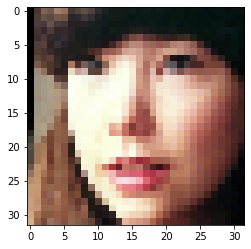

In [16]:
visualizar_imagen(x_train[12])

## Prueba de modelos

### Primer prueba

In [11]:
OPTIMIZADOR1 = optimizador.Adam(learning_rate=0.0002, beta_1=0.5) 
ERROR1 = 'binary_crossentropy' 

gan1 = crear_GAN(OPTIMIZADOR1, ERROR1)

Generador Creado
Discriminador Creado
GAN Creado


Comenzando Epoca 1... Fin
Tiempo transcurrido:  5.42 s
Tiempo restante aprox: 270.9m -> 4:30h
prediccion de ruido:  [[0.50084186]]
Comenzando Epoca 2... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 125.11m -> 2:5h
prediccion de ruido:  [[0.4972908]]
Comenzando Epoca 3... Fin
Tiempo transcurrido:  2.48 s
Tiempo restante aprox: 123.74m -> 2:3h
prediccion de ruido:  [[0.49293226]]
Comenzando Epoca 4... Fin
Tiempo transcurrido:  2.54 s
Tiempo restante aprox: 126.93m -> 2:6h
prediccion de ruido:  [[0.488381]]
Comenzando Epoca 5... Fin
Tiempo transcurrido:  2.54 s
Tiempo restante aprox: 127.05m -> 2:7h
prediccion de ruido:  [[0.4826366]]
Comenzando Epoca 6... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 125.19m -> 2:5h
prediccion de ruido:  [[0.47805652]]
Comenzando Epoca 7... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 124.78m -> 2:4h
prediccion de ruido:  [[0.47489995]]
Comenzando Epoca 8... Fin
Tiempo transcurrido:  2.65 s
Tiempo restante aprox: 132.09m -> 

Comenzando Epoca 83... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 121.95m -> 2:1h
prediccion de ruido:  [[0.13916415]]
Comenzando Epoca 84... Fin
Tiempo transcurrido:  2.48 s
Tiempo restante aprox: 120.42m -> 2:0h
prediccion de ruido:  [[0.11899546]]
Comenzando Epoca 85... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 121.97m -> 2:1h
prediccion de ruido:  [[0.12403286]]
Comenzando Epoca 86... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 122.68m -> 2:2h
prediccion de ruido:  [[0.10334879]]
Comenzando Epoca 87... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 121.48m -> 2:1h
prediccion de ruido:  [[0.12763649]]
Comenzando Epoca 88... Fin
Tiempo transcurrido:  2.62 s
Tiempo restante aprox: 127.28m -> 2:7h
prediccion de ruido:  [[0.11165255]]
Comenzando Epoca 89... Fin
Tiempo transcurrido:  2.57 s
Tiempo restante aprox: 124.71m -> 2:4h
prediccion de ruido:  [[0.11761659]]
Comenzando Epoca 90... Fin
Tiempo transcurrido:  2.64 s
Tiempo restante aprox

Comenzando Epoca 124... Fin
Tiempo transcurrido:  2.52 s
Tiempo restante aprox: 120.85m -> 2:0h
prediccion de ruido:  [[0.25391212]]
Comenzando Epoca 125... Fin
Tiempo transcurrido:  2.49 s
Tiempo restante aprox: 119.27m -> 1:59h
prediccion de ruido:  [[0.24098408]]
Comenzando Epoca 126... Fin
Tiempo transcurrido:  2.49 s
Tiempo restante aprox: 119.23m -> 1:59h
prediccion de ruido:  [[0.25408602]]
Comenzando Epoca 127... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 119.57m -> 1:59h
prediccion de ruido:  [[0.18154496]]
Comenzando Epoca 128... Fin
Tiempo transcurrido:  2.52 s
Tiempo restante aprox: 120.68m -> 2:0h
prediccion de ruido:  [[0.23405817]]
Comenzando Epoca 129... Fin
Tiempo transcurrido:  2.49 s
Tiempo restante aprox: 119.2m -> 1:59h
prediccion de ruido:  [[0.12126189]]
Comenzando Epoca 130... Fin
Tiempo transcurrido:  2.49 s
Tiempo restante aprox: 119.16m -> 1:59h
prediccion de ruido:  [[0.08570987]]
Comenzando Epoca 131... Fin
Tiempo transcurrido:  2.49 s
Tiempo re

Comenzando Epoca 165... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 117.94m -> 1:57h
prediccion de ruido:  [[0.09190074]]
Comenzando Epoca 166... Fin
Tiempo transcurrido:  2.49 s
Tiempo restante aprox: 117.66m -> 1:57h
prediccion de ruido:  [[0.0888477]]
Comenzando Epoca 167... Fin
Tiempo transcurrido:  2.49 s
Tiempo restante aprox: 117.58m -> 1:57h
prediccion de ruido:  [[0.18356249]]
Comenzando Epoca 168... Fin
Tiempo transcurrido:  2.49 s
Tiempo restante aprox: 117.35m -> 1:57h
prediccion de ruido:  [[0.18819976]]
Comenzando Epoca 169... Fin
Tiempo transcurrido:  2.49 s
Tiempo restante aprox: 117.4m -> 1:57h
prediccion de ruido:  [[0.07652918]]
Comenzando Epoca 170... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 118.06m -> 1:58h
prediccion de ruido:  [[0.16763082]]
Comenzando Epoca 171... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 117.74m -> 1:57h
prediccion de ruido:  [[0.21705556]]
Comenzando Epoca 172... Fin
Tiempo transcurrido:  2.49 s
Tiempo res

Comenzando Epoca 206... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 117.02m -> 1:57h
prediccion de ruido:  [[0.80133283]]
Comenzando Epoca 207... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 117.94m -> 1:57h
prediccion de ruido:  [[0.06737623]]
Comenzando Epoca 208... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 121.27m -> 2:1h
prediccion de ruido:  [[0.6316802]]
Comenzando Epoca 209... Fin
Tiempo transcurrido:  2.72 s
Tiempo restante aprox: 126.39m -> 2:6h
prediccion de ruido:  [[0.12788361]]
Comenzando Epoca 210... Fin
Tiempo transcurrido:  3.37 s
Tiempo restante aprox: 156.92m -> 2:36h
prediccion de ruido:  [[0.27513385]]
Comenzando Epoca 211... Fin
Tiempo transcurrido:  2.55 s
Tiempo restante aprox: 118.56m -> 1:58h
prediccion de ruido:  [[0.10032633]]
Comenzando Epoca 212... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 116.02m -> 1:56h
prediccion de ruido:  [[0.0698165]]
Comenzando Epoca 213... Fin
Tiempo transcurrido:  2.72 s
Tiempo res

Comenzando Epoca 247... Fin
Tiempo transcurrido:  2.48 s
Tiempo restante aprox: 113.9m -> 1:53h
prediccion de ruido:  [[0.73837674]]
Comenzando Epoca 248... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 114.53m -> 1:54h
prediccion de ruido:  [[0.12904173]]
Comenzando Epoca 249... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 114.48m -> 1:54h
prediccion de ruido:  [[0.63619053]]
Comenzando Epoca 250... Fin
Tiempo transcurrido:  2.48 s
Tiempo restante aprox: 113.73m -> 1:53h
prediccion de ruido:  [[0.14896682]]
Comenzando Epoca 251... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 115.12m -> 1:55h
prediccion de ruido:  [[0.5962744]]
Comenzando Epoca 252... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 115.79m -> 1:55h
prediccion de ruido:  [[0.00565803]]
Comenzando Epoca 253... Fin
Tiempo transcurrido:  2.48 s
Tiempo restante aprox: 113.6m -> 1:53h
prediccion de ruido:  [[0.0072892]]
Comenzando Epoca 254... Fin
Tiempo transcurrido:  2.5 s
Tiempo resta

Comenzando Epoca 288... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 112.86m -> 1:52h
prediccion de ruido:  [[0.6467383]]
Comenzando Epoca 289... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 113.53m -> 1:53h
prediccion de ruido:  [[0.42190918]]
Comenzando Epoca 290... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 114.32m -> 1:54h
prediccion de ruido:  [[0.44436228]]
Comenzando Epoca 291... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 113.58m -> 1:53h
prediccion de ruido:  [[0.138735]]
Comenzando Epoca 292... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 114.1m -> 1:54h
prediccion de ruido:  [[0.5822242]]
Comenzando Epoca 293... Fin
Tiempo transcurrido:  2.48 s
Tiempo restante aprox: 111.95m -> 1:51h
prediccion de ruido:  [[0.18863028]]
Comenzando Epoca 294... Fin
Tiempo transcurrido:  2.48 s
Tiempo restante aprox: 111.91m -> 1:51h
prediccion de ruido:  [[0.6069443]]
Comenzando Epoca 295... Fin
Tiempo transcurrido:  2.48 s
Tiempo resta

Comenzando Epoca 329... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 111.16m -> 1:51h
prediccion de ruido:  [[0.9158682]]
Comenzando Epoca 330... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 111.11m -> 1:51h
prediccion de ruido:  [[0.7620919]]
Comenzando Epoca 331... Fin
Tiempo transcurrido:  2.56 s
Tiempo restante aprox: 113.85m -> 1:53h
prediccion de ruido:  [[0.7325149]]
Comenzando Epoca 332... Fin
Tiempo transcurrido:  2.48 s
Tiempo restante aprox: 110.34m -> 1:50h
prediccion de ruido:  [[0.8182277]]
Comenzando Epoca 333... Fin
Tiempo transcurrido:  2.48 s
Tiempo restante aprox: 110.34m -> 1:50h
prediccion de ruido:  [[0.8271754]]
Comenzando Epoca 334... Fin
Tiempo transcurrido:  2.48 s
Tiempo restante aprox: 110.25m -> 1:50h
prediccion de ruido:  [[0.87583673]]
Comenzando Epoca 335... Fin
Tiempo transcurrido:  2.48 s
Tiempo restante aprox: 110.21m -> 1:50h
prediccion de ruido:  [[0.74636376]]
Comenzando Epoca 336... Fin
Tiempo transcurrido:  2.5 s
Tiempo restan

Comenzando Epoca 370... Fin
Tiempo transcurrido:  2.48 s
Tiempo restante aprox: 108.77m -> 1:48h
prediccion de ruido:  [[0.6821715]]
Comenzando Epoca 371... Fin
Tiempo transcurrido:  2.48 s
Tiempo restante aprox: 108.72m -> 1:48h
prediccion de ruido:  [[0.75274]]
Comenzando Epoca 372... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 109.37m -> 1:49h
prediccion de ruido:  [[0.7111113]]
Comenzando Epoca 373... Fin
Tiempo transcurrido:  2.48 s
Tiempo restante aprox: 108.64m -> 1:48h
prediccion de ruido:  [[0.89975065]]
Comenzando Epoca 374... Fin
Tiempo transcurrido:  2.48 s
Tiempo restante aprox: 108.6m -> 1:48h
prediccion de ruido:  [[0.8374386]]
Comenzando Epoca 375... Fin
Tiempo transcurrido:  2.48 s
Tiempo restante aprox: 108.69m -> 1:48h
prediccion de ruido:  [[0.67123884]]
Comenzando Epoca 376... Fin
Tiempo transcurrido:  2.48 s
Tiempo restante aprox: 108.52m -> 1:48h
prediccion de ruido:  [[0.540533]]
Comenzando Epoca 377... Fin
Tiempo transcurrido:  2.48 s
Tiempo restante

Comenzando Epoca 411... Fin
Tiempo transcurrido:  2.48 s
Tiempo restante aprox: 107.07m -> 1:47h
prediccion de ruido:  [[0.81190026]]
Comenzando Epoca 412... Fin
Tiempo transcurrido:  2.48 s
Tiempo restante aprox: 107.03m -> 1:47h
prediccion de ruido:  [[0.6898782]]
Comenzando Epoca 413... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 107.66m -> 1:47h
prediccion de ruido:  [[0.7268369]]
Comenzando Epoca 414... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 107.62m -> 1:47h
prediccion de ruido:  [[0.680117]]
Comenzando Epoca 415... Fin
Tiempo transcurrido:  2.48 s
Tiempo restante aprox: 106.99m -> 1:46h
prediccion de ruido:  [[0.6767711]]
Comenzando Epoca 416... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 107.53m -> 1:47h
prediccion de ruido:  [[0.8134067]]
Comenzando Epoca 417... Fin
Tiempo transcurrido:  2.48 s
Tiempo restante aprox: 106.82m -> 1:46h
prediccion de ruido:  [[0.63284636]]
Comenzando Epoca 418... Fin
Tiempo transcurrido:  2.48 s
Tiempo restant

Comenzando Epoca 452... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 106.04m -> 1:46h
prediccion de ruido:  [[0.9129211]]
Comenzando Epoca 453... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 106.0m -> 1:45h
prediccion de ruido:  [[0.5929159]]
Comenzando Epoca 454... Fin
Tiempo transcurrido:  2.48 s
Tiempo restante aprox: 105.29m -> 1:45h
prediccion de ruido:  [[0.47954744]]
Comenzando Epoca 455... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 105.91m -> 1:45h
prediccion de ruido:  [[0.8798934]]
Comenzando Epoca 456... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 105.87m -> 1:45h
prediccion de ruido:  [[0.35593766]]
Comenzando Epoca 457... Fin
Tiempo transcurrido:  2.48 s
Tiempo restante aprox: 105.25m -> 1:45h
prediccion de ruido:  [[0.7493364]]
Comenzando Epoca 458... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 105.83m -> 1:45h
prediccion de ruido:  [[0.628128]]
Comenzando Epoca 459... Fin
Tiempo transcurrido:  2.48 s
Tiempo restante a

Comenzando Epoca 493... Fin
Tiempo transcurrido:  2.48 s
Tiempo restante aprox: 103.68m -> 1:43h
prediccion de ruido:  [[0.29311198]]
Comenzando Epoca 494... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 104.29m -> 1:44h
prediccion de ruido:  [[0.08290306]]
Comenzando Epoca 495... Fin
Tiempo transcurrido:  2.48 s
Tiempo restante aprox: 103.64m -> 1:43h
prediccion de ruido:  [[0.29339612]]
Comenzando Epoca 496... Fin
Tiempo transcurrido:  2.48 s
Tiempo restante aprox: 103.68m -> 1:43h
prediccion de ruido:  [[0.34774983]]
Comenzando Epoca 497... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 104.86m -> 1:44h
prediccion de ruido:  [[0.28380877]]
Comenzando Epoca 498... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 104.12m -> 1:44h
prediccion de ruido:  [[0.2668966]]
Comenzando Epoca 499... Fin
Tiempo transcurrido:  2.48 s
Tiempo restante aprox: 103.43m -> 1:43h
prediccion de ruido:  [[0.10898209]]
Comenzando Epoca 500... Fin
Tiempo transcurrido:  2.62 s
Tiempo r

Comenzando Epoca 534... Fin
Tiempo transcurrido:  2.62 s
Tiempo restante aprox: 107.73m -> 1:47h
prediccion de ruido:  [[0.00685731]]
Comenzando Epoca 535... Fin
Tiempo transcurrido:  2.59 s
Tiempo restante aprox: 106.38m -> 1:46h
prediccion de ruido:  [[0.01921916]]
Comenzando Epoca 536... Fin
Tiempo transcurrido:  2.54 s
Tiempo restante aprox: 104.56m -> 1:44h
prediccion de ruido:  [[0.01616302]]
Comenzando Epoca 537... Fin
Tiempo transcurrido:  3.06 s
Tiempo restante aprox: 125.83m -> 2:5h
prediccion de ruido:  [[0.0104894]]
Comenzando Epoca 538... Fin
Tiempo transcurrido:  3.0 s
Tiempo restante aprox: 123.13m -> 2:3h
prediccion de ruido:  [[0.03060848]]
Comenzando Epoca 539... Fin
Tiempo transcurrido:  2.69 s
Tiempo restante aprox: 110.21m -> 1:50h
prediccion de ruido:  [[0.41886145]]
Comenzando Epoca 540... Fin
Tiempo transcurrido:  2.59 s
Tiempo restante aprox: 106.09m -> 1:46h
prediccion de ruido:  [[0.0247294]]
Comenzando Epoca 541... Fin
Tiempo transcurrido:  2.65 s
Tiempo res

Comenzando Epoca 575... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 101.63m -> 1:41h
prediccion de ruido:  [[0.02242866]]
Comenzando Epoca 576... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 101.1m -> 1:41h
prediccion de ruido:  [[0.09767413]]
Comenzando Epoca 577... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 101.14m -> 1:41h
prediccion de ruido:  [[0.18224594]]
Comenzando Epoca 578... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 101.03m -> 1:41h
prediccion de ruido:  [[0.2814322]]
Comenzando Epoca 579... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 100.92m -> 1:40h
prediccion de ruido:  [[0.40605667]]
Comenzando Epoca 580... Fin
Tiempo transcurrido:  2.49 s
Tiempo restante aprox: 100.3m -> 1:40h
prediccion de ruido:  [[0.60176295]]
Comenzando Epoca 581... Fin
Tiempo transcurrido:  2.49 s
Tiempo restante aprox: 100.34m -> 1:40h
prediccion de ruido:  [[0.40148735]]
Comenzando Epoca 582... Fin
Tiempo transcurrido:  2.48 s
Tiempo resta

Comenzando Epoca 616... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 99.61m -> 1:39h
prediccion de ruido:  [[0.21569341]]
Comenzando Epoca 617... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 99.53m -> 1:39h
prediccion de ruido:  [[0.07531494]]
Comenzando Epoca 618... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 99.09m -> 1:39h
prediccion de ruido:  [[0.03019568]]
Comenzando Epoca 619... Fin
Tiempo transcurrido:  2.52 s
Tiempo restante aprox: 100.2m -> 1:40h
prediccion de ruido:  [[0.01461616]]
Comenzando Epoca 620... Fin
Tiempo transcurrido:  2.56 s
Tiempo restante aprox: 101.57m -> 1:41h
prediccion de ruido:  [[0.01957762]]
Comenzando Epoca 621... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 99.63m -> 1:39h
prediccion de ruido:  [[0.17345765]]
Comenzando Epoca 622... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 99.58m -> 1:39h
prediccion de ruido:  [[0.11843741]]
Comenzando Epoca 623... Fin
Tiempo transcurrido:  2.51 s
Tiempo restan

Comenzando Epoca 657... Fin
Tiempo transcurrido:  2.68 s
Tiempo restante aprox: 104.57m -> 1:44h
prediccion de ruido:  [[5.446827e-09]]
Comenzando Epoca 658... Fin
Tiempo transcurrido:  2.77 s
Tiempo restante aprox: 108.18m -> 1:48h
prediccion de ruido:  [[0.18914798]]
Comenzando Epoca 659... Fin
Tiempo transcurrido:  2.92 s
Tiempo restante aprox: 113.85m -> 1:53h
prediccion de ruido:  [[0.07316783]]
Comenzando Epoca 660... Fin
Tiempo transcurrido:  2.76 s
Tiempo restante aprox: 107.52m -> 1:47h
prediccion de ruido:  [[0.7262398]]
Comenzando Epoca 661... Fin
Tiempo transcurrido:  2.62 s
Tiempo restante aprox: 102.34m -> 1:42h
prediccion de ruido:  [[0.02714124]]
Comenzando Epoca 662... Fin
Tiempo transcurrido:  2.71 s
Tiempo restante aprox: 105.54m -> 1:45h
prediccion de ruido:  [[0.03864828]]
Comenzando Epoca 663... Fin
Tiempo transcurrido:  2.64 s
Tiempo restante aprox: 102.76m -> 1:42h
prediccion de ruido:  [[0.00012431]]
Comenzando Epoca 664... Fin
Tiempo transcurrido:  2.7 s
Tiemp

Comenzando Epoca 698... Fin
Tiempo transcurrido:  2.52 s
Tiempo restante aprox: 96.89m -> 1:36h
prediccion de ruido:  [[0.2679909]]
Comenzando Epoca 699... Fin
Tiempo transcurrido:  2.54 s
Tiempo restante aprox: 97.3m -> 1:37h
prediccion de ruido:  [[0.18567845]]
Comenzando Epoca 700... Fin
Tiempo transcurrido:  2.62 s
Tiempo restante aprox: 100.52m -> 1:40h
prediccion de ruido:  [[0.11172646]]
Comenzando Epoca 701... Fin
Tiempo transcurrido:  2.56 s
Tiempo restante aprox: 98.11m -> 1:38h
prediccion de ruido:  [[0.13971192]]
Comenzando Epoca 702... Fin
Tiempo transcurrido:  2.55 s
Tiempo restante aprox: 97.62m -> 1:37h
prediccion de ruido:  [[0.03801244]]
Comenzando Epoca 703... Fin
Tiempo transcurrido:  2.59 s
Tiempo restante aprox: 99.37m -> 1:39h
prediccion de ruido:  [[0.17568761]]
Comenzando Epoca 704... Fin
Tiempo transcurrido:  2.58 s
Tiempo restante aprox: 98.77m -> 1:38h
prediccion de ruido:  [[0.14404482]]
Comenzando Epoca 705... Fin
Tiempo transcurrido:  2.71 s
Tiempo restan

Comenzando Epoca 739... Fin
Tiempo transcurrido:  2.59 s
Tiempo restante aprox: 97.56m -> 1:37h
prediccion de ruido:  [[0.6293774]]
Comenzando Epoca 740... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 95.44m -> 1:35h
prediccion de ruido:  [[0.38285467]]
Comenzando Epoca 741... Fin
Tiempo transcurrido:  2.49 s
Tiempo restante aprox: 93.77m -> 1:33h
prediccion de ruido:  [[0.3837817]]
Comenzando Epoca 742... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 95.15m -> 1:35h
prediccion de ruido:  [[0.38771552]]
Comenzando Epoca 743... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 94.32m -> 1:34h
prediccion de ruido:  [[0.5719743]]
Comenzando Epoca 744... Fin
Tiempo transcurrido:  2.52 s
Tiempo restante aprox: 94.62m -> 1:34h
prediccion de ruido:  [[0.38267857]]
Comenzando Epoca 745... Fin
Tiempo transcurrido:  2.52 s
Tiempo restante aprox: 94.77m -> 1:34h
prediccion de ruido:  [[0.49821937]]
Comenzando Epoca 746... Fin
Tiempo transcurrido:  2.62 s
Tiempo restante

Comenzando Epoca 780... Fin
Tiempo transcurrido:  2.79 s
Tiempo restante aprox: 103.27m -> 1:43h
prediccion de ruido:  [[0.0265238]]
Comenzando Epoca 781... Fin
Tiempo transcurrido:  2.71 s
Tiempo restante aprox: 100.37m -> 1:40h
prediccion de ruido:  [[0.30352876]]
Comenzando Epoca 782... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 96.36m -> 1:36h
prediccion de ruido:  [[0.34112197]]
Comenzando Epoca 783... Fin
Tiempo transcurrido:  2.56 s
Tiempo restante aprox: 94.59m -> 1:34h
prediccion de ruido:  [[0.0596965]]
Comenzando Epoca 784... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 96.53m -> 1:36h
prediccion de ruido:  [[0.19382384]]
Comenzando Epoca 785... Fin
Tiempo transcurrido:  2.77 s
Tiempo restante aprox: 102.31m -> 1:42h
prediccion de ruido:  [[0.21282876]]
Comenzando Epoca 786... Fin
Tiempo transcurrido:  2.86 s
Tiempo restante aprox: 105.52m -> 1:45h
prediccion de ruido:  [[0.01344389]]
Comenzando Epoca 787... Fin
Tiempo transcurrido:  2.76 s
Tiempo res

Comenzando Epoca 821... Fin
Tiempo transcurrido:  2.66 s
Tiempo restante aprox: 96.65m -> 1:36h
prediccion de ruido:  [[0.15648445]]
Comenzando Epoca 822... Fin
Tiempo transcurrido:  2.54 s
Tiempo restante aprox: 92.16m -> 1:32h
prediccion de ruido:  [[0.11978638]]
Comenzando Epoca 823... Fin
Tiempo transcurrido:  2.55 s
Tiempo restante aprox: 92.6m -> 1:32h
prediccion de ruido:  [[0.1048395]]
Comenzando Epoca 824... Fin
Tiempo transcurrido:  2.58 s
Tiempo restante aprox: 93.62m -> 1:33h
prediccion de ruido:  [[0.05697927]]
Comenzando Epoca 825... Fin
Tiempo transcurrido:  2.55 s
Tiempo restante aprox: 92.45m -> 1:32h
prediccion de ruido:  [[0.25631222]]
Comenzando Epoca 826... Fin
Tiempo transcurrido:  2.68 s
Tiempo restante aprox: 97.03m -> 1:37h
prediccion de ruido:  [[0.6737143]]
Comenzando Epoca 827... Fin
Tiempo transcurrido:  2.73 s
Tiempo restante aprox: 99.03m -> 1:39h
prediccion de ruido:  [[0.531883]]
Comenzando Epoca 828... Fin
Tiempo transcurrido:  2.55 s
Tiempo restante a

Comenzando Epoca 862... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 93.08m -> 1:33h
prediccion de ruido:  [[0.1775622]]
Comenzando Epoca 863... Fin
Tiempo transcurrido:  2.55 s
Tiempo restante aprox: 90.76m -> 1:30h
prediccion de ruido:  [[0.02654901]]
Comenzando Epoca 864... Fin
Tiempo transcurrido:  2.57 s
Tiempo restante aprox: 91.52m -> 1:31h
prediccion de ruido:  [[0.0610936]]
Comenzando Epoca 865... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 89.23m -> 1:29h
prediccion de ruido:  [[0.28772634]]
Comenzando Epoca 866... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 89.28m -> 1:29h
prediccion de ruido:  [[0.02234668]]
Comenzando Epoca 867... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 89.25m -> 1:29h
prediccion de ruido:  [[0.05610442]]
Comenzando Epoca 868... Fin
Tiempo transcurrido:  2.49 s
Tiempo restante aprox: 88.53m -> 1:28h
prediccion de ruido:  [[0.14432779]]
Comenzando Epoca 869... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante

Comenzando Epoca 903... Fin
Tiempo transcurrido:  2.62 s
Tiempo restante aprox: 91.61m -> 1:31h
prediccion de ruido:  [[0.0439209]]
Comenzando Epoca 904... Fin
Tiempo transcurrido:  2.65 s
Tiempo restante aprox: 92.7m -> 1:32h
prediccion de ruido:  [[0.04126942]]
Comenzando Epoca 905... Fin
Tiempo transcurrido:  2.55 s
Tiempo restante aprox: 89.06m -> 1:29h
prediccion de ruido:  [[0.12563264]]
Comenzando Epoca 906... Fin
Tiempo transcurrido:  2.48 s
Tiempo restante aprox: 86.68m -> 1:26h
prediccion de ruido:  [[0.00295842]]
Comenzando Epoca 907... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 88.2m -> 1:28h
prediccion de ruido:  [[0.00058106]]
Comenzando Epoca 908... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 87.55m -> 1:27h
prediccion de ruido:  [[0.02788085]]
Comenzando Epoca 909... Fin
Tiempo transcurrido:  2.55 s
Tiempo restante aprox: 89.04m -> 1:29h
prediccion de ruido:  [[0.11654964]]
Comenzando Epoca 910... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante 

Comenzando Epoca 944... Fin
Tiempo transcurrido:  2.58 s
Tiempo restante aprox: 88.57m -> 1:28h
prediccion de ruido:  [[0.2526309]]
Comenzando Epoca 945... Fin
Tiempo transcurrido:  2.63 s
Tiempo restante aprox: 90.07m -> 1:30h
prediccion de ruido:  [[0.00728521]]
Comenzando Epoca 946... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 85.76m -> 1:25h
prediccion de ruido:  [[0.15186706]]
Comenzando Epoca 947... Fin
Tiempo transcurrido:  2.59 s
Tiempo restante aprox: 88.6m -> 1:28h
prediccion de ruido:  [[0.20459202]]
Comenzando Epoca 948... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 85.41m -> 1:25h
prediccion de ruido:  [[0.28679764]]
Comenzando Epoca 949... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 85.36m -> 1:25h
prediccion de ruido:  [[0.05245745]]
Comenzando Epoca 950... Fin
Tiempo transcurrido:  2.48 s
Tiempo restante aprox: 84.79m -> 1:24h
prediccion de ruido:  [[0.26943183]]
Comenzando Epoca 951... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante ap

Comenzando Epoca 985... Fin
Tiempo transcurrido:  2.62 s
Tiempo restante aprox: 88.01m -> 1:28h
prediccion de ruido:  [[0.28074872]]
Comenzando Epoca 986... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 83.82m -> 1:23h
prediccion de ruido:  [[0.3791843]]
Comenzando Epoca 987... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 84.31m -> 1:24h
prediccion de ruido:  [[0.6711603]]
Comenzando Epoca 988... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 83.74m -> 1:23h
prediccion de ruido:  [[0.1380401]]
Comenzando Epoca 989... Fin
Tiempo transcurrido:  2.48 s
Tiempo restante aprox: 83.18m -> 1:23h
prediccion de ruido:  [[0.23693937]]
Comenzando Epoca 990... Fin
Tiempo transcurrido:  2.52 s
Tiempo restante aprox: 84.32m -> 1:24h
prediccion de ruido:  [[0.6773786]]
Comenzando Epoca 991... Fin
Tiempo transcurrido:  2.54 s
Tiempo restante aprox: 84.93m -> 1:24h
prediccion de ruido:  [[0.14280343]]
Comenzando Epoca 992... Fin
Tiempo transcurrido:  2.49 s
Tiempo restante ap

Comenzando Epoca 1026... Fin
Tiempo transcurrido:  2.57 s
Tiempo restante aprox: 84.73m -> 1:24h
prediccion de ruido:  [[0.07261184]]
Comenzando Epoca 1027... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 82.12m -> 1:22h
prediccion de ruido:  [[0.2725702]]
Comenzando Epoca 1028... Fin
Tiempo transcurrido:  2.59 s
Tiempo restante aprox: 85.02m -> 1:25h
prediccion de ruido:  [[0.01483667]]
Comenzando Epoca 1029... Fin
Tiempo transcurrido:  2.59 s
Tiempo restante aprox: 85.11m -> 1:25h
prediccion de ruido:  [[0.00846142]]
Comenzando Epoca 1030... Fin
Tiempo transcurrido:  2.59 s
Tiempo restante aprox: 85.07m -> 1:25h
prediccion de ruido:  [[0.05469689]]
Comenzando Epoca 1031... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 82.5m -> 1:22h
prediccion de ruido:  [[0.3283019]]
Comenzando Epoca 1032... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 83.0m -> 1:23h
prediccion de ruido:  [[0.25656405]]
Comenzando Epoca 1033... Fin
Tiempo transcurrido:  2.59 s
Tiempo re

Comenzando Epoca 1067... Fin
Tiempo transcurrido:  2.48 s
Tiempo restante aprox: 80.02m -> 1:20h
prediccion de ruido:  [[0.30846763]]
Comenzando Epoca 1068... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 80.41m -> 1:20h
prediccion de ruido:  [[0.05213928]]
Comenzando Epoca 1069... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 80.37m -> 1:20h
prediccion de ruido:  [[0.02656662]]
Comenzando Epoca 1070... Fin
Tiempo transcurrido:  2.46 s
Tiempo restante aprox: 79.33m -> 1:19h
prediccion de ruido:  [[0.03670448]]
Comenzando Epoca 1071... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 80.29m -> 1:20h
prediccion de ruido:  [[0.03588289]]
Comenzando Epoca 1072... Fin
Tiempo transcurrido:  2.48 s
Tiempo restante aprox: 79.75m -> 1:19h
prediccion de ruido:  [[0.10096824]]
Comenzando Epoca 1073... Fin
Tiempo transcurrido:  2.48 s
Tiempo restante aprox: 79.83m -> 1:19h
prediccion de ruido:  [[0.00211129]]
Comenzando Epoca 1074... Fin
Tiempo transcurrido:  2.48 s
Tiempo 

Comenzando Epoca 1108... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 79.2m -> 1:19h
prediccion de ruido:  [[0.08707663]]
Comenzando Epoca 1109... Fin
Tiempo transcurrido:  2.52 s
Tiempo restante aprox: 79.55m -> 1:19h
prediccion de ruido:  [[0.01968035]]
Comenzando Epoca 1110... Fin
Tiempo transcurrido:  2.49 s
Tiempo restante aprox: 78.55m -> 1:18h
prediccion de ruido:  [[0.03420663]]
Comenzando Epoca 1111... Fin
Tiempo transcurrido:  2.49 s
Tiempo restante aprox: 78.51m -> 1:18h
prediccion de ruido:  [[0.5225956]]
Comenzando Epoca 1112... Fin
Tiempo transcurrido:  2.49 s
Tiempo restante aprox: 78.44m -> 1:18h
prediccion de ruido:  [[0.05895519]]
Comenzando Epoca 1113... Fin
Tiempo transcurrido:  2.52 s
Tiempo restante aprox: 79.43m -> 1:19h
prediccion de ruido:  [[0.04818481]]
Comenzando Epoca 1114... Fin
Tiempo transcurrido:  2.56 s
Tiempo restante aprox: 80.39m -> 1:20h
prediccion de ruido:  [[0.06577823]]
Comenzando Epoca 1115... Fin
Tiempo transcurrido:  2.57 s
Tiempo

Comenzando Epoca 1149... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 77.14m -> 1:17h
prediccion de ruido:  [[0.02427444]]
Comenzando Epoca 1150... Fin
Tiempo transcurrido:  2.47 s
Tiempo restante aprox: 76.33m -> 1:16h
prediccion de ruido:  [[0.01623631]]
Comenzando Epoca 1151... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 76.96m -> 1:16h
prediccion de ruido:  [[0.01432222]]
Comenzando Epoca 1152... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 76.92m -> 1:16h
prediccion de ruido:  [[0.02689031]]
Comenzando Epoca 1153... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 76.88m -> 1:16h
prediccion de ruido:  [[0.02024028]]
Comenzando Epoca 1154... Fin
Tiempo transcurrido:  2.48 s
Tiempo restante aprox: 76.36m -> 1:16h
prediccion de ruido:  [[0.00939998]]
Comenzando Epoca 1155... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 76.82m -> 1:16h
prediccion de ruido:  [[0.00738043]]
Comenzando Epoca 1156... Fin
Tiempo transcurrido:  2.5 s
Tiempo res

Comenzando Epoca 1190... Fin
Tiempo transcurrido:  2.55 s
Tiempo restante aprox: 76.85m -> 1:16h
prediccion de ruido:  [[0.149324]]
Comenzando Epoca 1191... Fin
Tiempo transcurrido:  2.82 s
Tiempo restante aprox: 85.09m -> 1:25h
prediccion de ruido:  [[0.01186329]]
Comenzando Epoca 1192... Fin
Tiempo transcurrido:  2.54 s
Tiempo restante aprox: 76.45m -> 1:16h
prediccion de ruido:  [[0.02740738]]
Comenzando Epoca 1193... Fin
Tiempo transcurrido:  2.69 s
Tiempo restante aprox: 80.97m -> 1:20h
prediccion de ruido:  [[0.11842382]]
Comenzando Epoca 1194... Fin
Tiempo transcurrido:  2.99 s
Tiempo restante aprox: 90.1m -> 1:30h
prediccion de ruido:  [[0.06844935]]
Comenzando Epoca 1195... Fin
Tiempo transcurrido:  3.17 s
Tiempo restante aprox: 95.46m -> 1:35h
prediccion de ruido:  [[0.00725716]]
Comenzando Epoca 1196... Fin
Tiempo transcurrido:  3.55 s
Tiempo restante aprox: 106.77m -> 1:46h
prediccion de ruido:  [[0.09697571]]
Comenzando Epoca 1197... Fin
Tiempo transcurrido:  3.42 s
Tiempo

Comenzando Epoca 1231... Fin
Tiempo transcurrido:  2.55 s
Tiempo restante aprox: 75.19m -> 1:15h
prediccion de ruido:  [[0.01812333]]
Comenzando Epoca 1232... Fin
Tiempo transcurrido:  2.71 s
Tiempo restante aprox: 79.75m -> 1:19h
prediccion de ruido:  [[0.00758737]]
Comenzando Epoca 1233... Fin
Tiempo transcurrido:  2.89 s
Tiempo restante aprox: 85.13m -> 1:25h
prediccion de ruido:  [[0.00163242]]
Comenzando Epoca 1234... Fin
Tiempo transcurrido:  2.57 s
Tiempo restante aprox: 75.81m -> 1:15h
prediccion de ruido:  [[0.03071314]]
Comenzando Epoca 1235... Fin
Tiempo transcurrido:  2.56 s
Tiempo restante aprox: 75.47m -> 1:15h
prediccion de ruido:  [[0.01525331]]
Comenzando Epoca 1236... Fin
Tiempo transcurrido:  2.58 s
Tiempo restante aprox: 75.81m -> 1:15h
prediccion de ruido:  [[0.00582519]]
Comenzando Epoca 1237... Fin
Tiempo transcurrido:  2.82 s
Tiempo restante aprox: 82.82m -> 1:22h
prediccion de ruido:  [[0.00189629]]
Comenzando Epoca 1238... Fin
Tiempo transcurrido:  2.81 s
Tiem

Comenzando Epoca 1272... Fin
Tiempo transcurrido:  2.55 s
Tiempo restante aprox: 73.42m -> 1:13h
prediccion de ruido:  [[0.00557375]]
Comenzando Epoca 1273... Fin
Tiempo transcurrido:  2.49 s
Tiempo restante aprox: 71.68m -> 1:11h
prediccion de ruido:  [[0.00788319]]
Comenzando Epoca 1274... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 72.76m -> 1:12h
prediccion de ruido:  [[0.00325674]]
Comenzando Epoca 1275... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 72.25m -> 1:12h
prediccion de ruido:  [[0.0130133]]
Comenzando Epoca 1276... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 71.85m -> 1:11h
prediccion de ruido:  [[0.00977907]]
Comenzando Epoca 1277... Fin
Tiempo transcurrido:  2.48 s
Tiempo restante aprox: 71.17m -> 1:11h
prediccion de ruido:  [[0.02427185]]
Comenzando Epoca 1278... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 72.76m -> 1:12h
prediccion de ruido:  [[0.0160661]]
Comenzando Epoca 1279... Fin
Tiempo transcurrido:  2.48 s
Tiempo 

Comenzando Epoca 1313... Fin
Tiempo transcurrido:  2.55 s
Tiempo restante aprox: 71.62m -> 1:11h
prediccion de ruido:  [[0.00079504]]
Comenzando Epoca 1314... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 70.28m -> 1:10h
prediccion de ruido:  [[0.00855547]]
Comenzando Epoca 1315... Fin
Tiempo transcurrido:  2.52 s
Tiempo restante aprox: 70.86m -> 1:10h
prediccion de ruido:  [[0.00908569]]
Comenzando Epoca 1316... Fin
Tiempo transcurrido:  2.52 s
Tiempo restante aprox: 70.72m -> 1:10h
prediccion de ruido:  [[0.00991896]]
Comenzando Epoca 1317... Fin
Tiempo transcurrido:  2.48 s
Tiempo restante aprox: 69.62m -> 1:9h
prediccion de ruido:  [[0.00898963]]
Comenzando Epoca 1318... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 70.45m -> 1:10h
prediccion de ruido:  [[0.00465095]]
Comenzando Epoca 1319... Fin
Tiempo transcurrido:  2.48 s
Tiempo restante aprox: 69.59m -> 1:9h
prediccion de ruido:  [[0.00425953]]
Comenzando Epoca 1320... Fin
Tiempo transcurrido:  2.48 s
Tiempo 

Comenzando Epoca 1354... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 68.52m -> 1:8h
prediccion de ruido:  [[0.01423377]]
Comenzando Epoca 1355... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 68.54m -> 1:8h
prediccion de ruido:  [[0.00211048]]
Comenzando Epoca 1356... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 68.49m -> 1:8h
prediccion de ruido:  [[0.00683835]]
Comenzando Epoca 1357... Fin
Tiempo transcurrido:  2.69 s
Tiempo restante aprox: 73.79m -> 1:13h
prediccion de ruido:  [[0.00230557]]
Comenzando Epoca 1358... Fin
Tiempo transcurrido:  2.67 s
Tiempo restante aprox: 73.01m -> 1:13h
prediccion de ruido:  [[0.00105512]]
Comenzando Epoca 1359... Fin
Tiempo transcurrido:  2.92 s
Tiempo restante aprox: 79.92m -> 1:19h
prediccion de ruido:  [[0.00950471]]
Comenzando Epoca 1360... Fin
Tiempo transcurrido:  2.77 s
Tiempo restante aprox: 75.74m -> 1:15h
prediccion de ruido:  [[0.00040376]]
Comenzando Epoca 1361... Fin
Tiempo transcurrido:  2.75 s
Tiempo res

Comenzando Epoca 1395... Fin
Tiempo transcurrido:  2.73 s
Tiempo restante aprox: 73.07m -> 1:13h
prediccion de ruido:  [[0.00248033]]
Comenzando Epoca 1396... Fin
Tiempo transcurrido:  2.64 s
Tiempo restante aprox: 70.53m -> 1:10h
prediccion de ruido:  [[0.00460327]]
Comenzando Epoca 1397... Fin
Tiempo transcurrido:  2.59 s
Tiempo restante aprox: 69.26m -> 1:9h
prediccion de ruido:  [[0.00067928]]
Comenzando Epoca 1398... Fin
Tiempo transcurrido:  2.56 s
Tiempo restante aprox: 68.35m -> 1:8h
prediccion de ruido:  [[0.02231497]]
Comenzando Epoca 1399... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 67.06m -> 1:7h
prediccion de ruido:  [[0.00069687]]
Comenzando Epoca 1400... Fin
Tiempo transcurrido:  2.7 s
Tiempo restante aprox: 72.01m -> 1:12h
prediccion de ruido:  [[0.00171152]]
Comenzando Epoca 1401... Fin
Tiempo transcurrido:  2.52 s
Tiempo restante aprox: 67.08m -> 1:7h
prediccion de ruido:  [[0.00052872]]
Comenzando Epoca 1402... Fin
Tiempo transcurrido:  2.52 s
Tiempo re

Comenzando Epoca 1436... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 66.07m -> 1:6h
prediccion de ruido:  [[0.00016385]]
Comenzando Epoca 1437... Fin
Tiempo transcurrido:  2.52 s
Tiempo restante aprox: 65.69m -> 1:5h
prediccion de ruido:  [[0.00010921]]
Comenzando Epoca 1438... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 65.13m -> 1:5h
prediccion de ruido:  [[0.00736195]]
Comenzando Epoca 1439... Fin
Tiempo transcurrido:  2.6 s
Tiempo restante aprox: 67.75m -> 1:7h
prediccion de ruido:  [[0.00181317]]
Comenzando Epoca 1440... Fin
Tiempo transcurrido:  2.57 s
Tiempo restante aprox: 66.94m -> 1:6h
prediccion de ruido:  [[0.00266337]]
Comenzando Epoca 1441... Fin
Tiempo transcurrido:  2.55 s
Tiempo restante aprox: 66.24m -> 1:6h
prediccion de ruido:  [[0.00350749]]
Comenzando Epoca 1442... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 65.84m -> 1:5h
prediccion de ruido:  [[4.3961845e-05]]
Comenzando Epoca 1443... Fin
Tiempo transcurrido:  2.54 s
Tiempo res

Comenzando Epoca 1477... Fin
Tiempo transcurrido:  2.6 s
Tiempo restante aprox: 65.98m -> 1:5h
prediccion de ruido:  [[0.0004274]]
Comenzando Epoca 1478... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 63.35m -> 1:3h
prediccion de ruido:  [[0.00049555]]
Comenzando Epoca 1479... Fin
Tiempo transcurrido:  2.56 s
Tiempo restante aprox: 64.93m -> 1:4h
prediccion de ruido:  [[0.00187382]]
Comenzando Epoca 1480... Fin
Tiempo transcurrido:  2.52 s
Tiempo restante aprox: 63.96m -> 1:3h
prediccion de ruido:  [[0.00012994]]
Comenzando Epoca 1481... Fin
Tiempo transcurrido:  2.54 s
Tiempo restante aprox: 64.39m -> 1:4h
prediccion de ruido:  [[0.00994384]]
Comenzando Epoca 1482... Fin
Tiempo transcurrido:  2.54 s
Tiempo restante aprox: 64.32m -> 1:4h
prediccion de ruido:  [[0.00224754]]
Comenzando Epoca 1483... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 63.94m -> 1:3h
prediccion de ruido:  [[0.00487065]]
Comenzando Epoca 1484... Fin
Tiempo transcurrido:  2.52 s
Tiempo restant

Comenzando Epoca 1518... Fin
Tiempo transcurrido:  2.54 s
Tiempo restante aprox: 62.66m -> 1:2h
prediccion de ruido:  [[0.49428427]]
Comenzando Epoca 1519... Fin
Tiempo transcurrido:  2.52 s
Tiempo restante aprox: 62.17m -> 1:2h
prediccion de ruido:  [[0.23530242]]
Comenzando Epoca 1520... Fin
Tiempo transcurrido:  2.57 s
Tiempo restante aprox: 63.55m -> 1:3h
prediccion de ruido:  [[0.03668863]]
Comenzando Epoca 1521... Fin
Tiempo transcurrido:  2.55 s
Tiempo restante aprox: 62.86m -> 1:2h
prediccion de ruido:  [[0.00039634]]
Comenzando Epoca 1522... Fin
Tiempo transcurrido:  2.52 s
Tiempo restante aprox: 62.08m -> 1:2h
prediccion de ruido:  [[0.00333783]]
Comenzando Epoca 1523... Fin
Tiempo transcurrido:  2.55 s
Tiempo restante aprox: 62.92m -> 1:2h
prediccion de ruido:  [[0.1683707]]
Comenzando Epoca 1524... Fin
Tiempo transcurrido:  2.58 s
Tiempo restante aprox: 63.43m -> 1:3h
prediccion de ruido:  [[0.41233838]]
Comenzando Epoca 1525... Fin
Tiempo transcurrido:  2.58 s
Tiempo resta

Comenzando Epoca 1559... Fin
Tiempo transcurrido:  2.71 s
Tiempo restante aprox: 65.22m -> 1:5h
prediccion de ruido:  [[0.32912472]]
Comenzando Epoca 1560... Fin
Tiempo transcurrido:  2.77 s
Tiempo restante aprox: 66.61m -> 1:6h
prediccion de ruido:  [[0.5515338]]
Comenzando Epoca 1561... Fin
Tiempo transcurrido:  2.74 s
Tiempo restante aprox: 65.87m -> 1:5h
prediccion de ruido:  [[0.282259]]
Comenzando Epoca 1562... Fin
Tiempo transcurrido:  2.6 s
Tiempo restante aprox: 62.31m -> 1:2h
prediccion de ruido:  [[0.25944588]]
Comenzando Epoca 1563... Fin
Tiempo transcurrido:  2.58 s
Tiempo restante aprox: 61.91m -> 1:1h
prediccion de ruido:  [[0.4144703]]
Comenzando Epoca 1564... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 62.54m -> 1:2h
prediccion de ruido:  [[0.5434763]]
Comenzando Epoca 1565... Fin
Tiempo transcurrido:  2.58 s
Tiempo restante aprox: 61.65m -> 1:1h
prediccion de ruido:  [[0.2691307]]
Comenzando Epoca 1566... Fin
Tiempo transcurrido:  2.56 s
Tiempo restante ap

Comenzando Epoca 1600... Fin
Tiempo transcurrido:  2.74 s
Tiempo restante aprox: 63.95m -> 1:3h
prediccion de ruido:  [[0.7863581]]
Comenzando Epoca 1601... Fin
Tiempo transcurrido:  2.57 s
Tiempo restante aprox: 60.01m -> 1:0h
prediccion de ruido:  [[0.46672717]]
Comenzando Epoca 1602... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 58.97m -> 0:58h
prediccion de ruido:  [[0.07349536]]
Comenzando Epoca 1603... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 59.0m -> 0:59h
prediccion de ruido:  [[0.4807578]]
Comenzando Epoca 1604... Fin
Tiempo transcurrido:  2.85 s
Tiempo restante aprox: 66.26m -> 1:6h
prediccion de ruido:  [[0.07000956]]
Comenzando Epoca 1605... Fin
Tiempo transcurrido:  2.64 s
Tiempo restante aprox: 61.42m -> 1:1h
prediccion de ruido:  [[0.06970805]]
Comenzando Epoca 1606... Fin
Tiempo transcurrido:  2.54 s
Tiempo restante aprox: 58.97m -> 0:58h
prediccion de ruido:  [[0.63315284]]
Comenzando Epoca 1607... Fin
Tiempo transcurrido:  2.58 s
Tiempo rest

Comenzando Epoca 1641... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 56.62m -> 0:56h
prediccion de ruido:  [[0.45992163]]
Comenzando Epoca 1642... Fin
Tiempo transcurrido:  2.77 s
Tiempo restante aprox: 62.75m -> 1:2h
prediccion de ruido:  [[0.35533482]]
Comenzando Epoca 1643... Fin
Tiempo transcurrido:  2.73 s
Tiempo restante aprox: 61.72m -> 1:1h
prediccion de ruido:  [[0.22103226]]
Comenzando Epoca 1644... Fin
Tiempo transcurrido:  2.92 s
Tiempo restante aprox: 66.0m -> 1:6h
prediccion de ruido:  [[0.28211018]]
Comenzando Epoca 1645... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 57.26m -> 0:57h
prediccion de ruido:  [[0.2793976]]
Comenzando Epoca 1646... Fin
Tiempo transcurrido:  2.67 s
Tiempo restante aprox: 60.29m -> 1:0h
prediccion de ruido:  [[0.48693505]]
Comenzando Epoca 1647... Fin
Tiempo transcurrido:  2.72 s
Tiempo restante aprox: 61.27m -> 1:1h
prediccion de ruido:  [[0.58418286]]
Comenzando Epoca 1648... Fin
Tiempo transcurrido:  2.58 s
Tiempo resta

Comenzando Epoca 1682... Fin
Tiempo transcurrido:  2.54 s
Tiempo restante aprox: 55.94m -> 0:55h
prediccion de ruido:  [[0.00147012]]
Comenzando Epoca 1683... Fin
Tiempo transcurrido:  2.54 s
Tiempo restante aprox: 55.86m -> 0:55h
prediccion de ruido:  [[0.03500751]]
Comenzando Epoca 1684... Fin
Tiempo transcurrido:  2.52 s
Tiempo restante aprox: 55.24m -> 0:55h
prediccion de ruido:  [[0.1179955]]
Comenzando Epoca 1685... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 55.52m -> 0:55h
prediccion de ruido:  [[0.10037851]]
Comenzando Epoca 1686... Fin
Tiempo transcurrido:  2.48 s
Tiempo restante aprox: 54.36m -> 0:54h
prediccion de ruido:  [[0.13013649]]
Comenzando Epoca 1687... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 55.0m -> 0:55h
prediccion de ruido:  [[0.48368853]]
Comenzando Epoca 1688... Fin
Tiempo transcurrido:  2.48 s
Tiempo restante aprox: 54.28m -> 0:54h
prediccion de ruido:  [[0.15671328]]
Comenzando Epoca 1689... Fin
Tiempo transcurrido:  2.48 s
Tiempo

Comenzando Epoca 1723... Fin
Tiempo transcurrido:  2.48 s
Tiempo restante aprox: 52.83m -> 0:52h
prediccion de ruido:  [[0.09828472]]
Comenzando Epoca 1724... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 53.14m -> 0:53h
prediccion de ruido:  [[0.25398672]]
Comenzando Epoca 1725... Fin
Tiempo transcurrido:  2.48 s
Tiempo restante aprox: 52.75m -> 0:52h
prediccion de ruido:  [[0.12298164]]
Comenzando Epoca 1726... Fin
Tiempo transcurrido:  2.48 s
Tiempo restante aprox: 52.73m -> 0:52h
prediccion de ruido:  [[0.03669789]]
Comenzando Epoca 1727... Fin
Tiempo transcurrido:  2.48 s
Tiempo restante aprox: 52.71m -> 0:52h
prediccion de ruido:  [[0.03428259]]
Comenzando Epoca 1728... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 52.96m -> 0:52h
prediccion de ruido:  [[7.904436e-05]]
Comenzando Epoca 1729... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 52.92m -> 0:52h
prediccion de ruido:  [[0.06994161]]
Comenzando Epoca 1730... Fin
Tiempo transcurrido:  2.5 s
Tiempo

Comenzando Epoca 1764... Fin
Tiempo transcurrido:  2.55 s
Tiempo restante aprox: 52.6m -> 0:52h
prediccion de ruido:  [[0.0049856]]
Comenzando Epoca 1765... Fin
Tiempo transcurrido:  2.58 s
Tiempo restante aprox: 53.12m -> 0:53h
prediccion de ruido:  [[0.05693007]]
Comenzando Epoca 1766... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 52.02m -> 0:52h
prediccion de ruido:  [[0.00205812]]
Comenzando Epoca 1767... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 51.33m -> 0:51h
prediccion de ruido:  [[0.02429172]]
Comenzando Epoca 1768... Fin
Tiempo transcurrido:  2.73 s
Tiempo restante aprox: 56.11m -> 0:56h
prediccion de ruido:  [[0.00258365]]
Comenzando Epoca 1769... Fin
Tiempo transcurrido:  2.72 s
Tiempo restante aprox: 55.85m -> 0:55h
prediccion de ruido:  [[0.02936289]]
Comenzando Epoca 1770... Fin
Tiempo transcurrido:  2.59 s
Tiempo restante aprox: 53.17m -> 0:53h
prediccion de ruido:  [[0.00902495]]
Comenzando Epoca 1771... Fin
Tiempo transcurrido:  2.55 s
Tiempo 

Comenzando Epoca 1805... Fin
Tiempo transcurrido:  2.57 s
Tiempo restante aprox: 51.31m -> 0:51h
prediccion de ruido:  [[0.00075459]]
Comenzando Epoca 1806... Fin
Tiempo transcurrido:  2.48 s
Tiempo restante aprox: 49.4m -> 0:49h
prediccion de ruido:  [[0.00786427]]
Comenzando Epoca 1807... Fin
Tiempo transcurrido:  2.58 s
Tiempo restante aprox: 51.26m -> 0:51h
prediccion de ruido:  [[0.00330758]]
Comenzando Epoca 1808... Fin
Tiempo transcurrido:  2.48 s
Tiempo restante aprox: 49.36m -> 0:49h
prediccion de ruido:  [[0.00204146]]
Comenzando Epoca 1809... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 49.9m -> 0:49h
prediccion de ruido:  [[0.02485633]]
Comenzando Epoca 1810... Fin
Tiempo transcurrido:  2.48 s
Tiempo restante aprox: 49.24m -> 0:49h
prediccion de ruido:  [[0.02304855]]
Comenzando Epoca 1811... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 49.5m -> 0:49h
prediccion de ruido:  [[0.00701022]]
Comenzando Epoca 1812... Fin
Tiempo transcurrido:  2.5 s
Tiempo re

Comenzando Epoca 1846... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 48.65m -> 0:48h
prediccion de ruido:  [[0.00175202]]
Comenzando Epoca 1847... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 48.31m -> 0:48h
prediccion de ruido:  [[0.02913854]]
Comenzando Epoca 1848... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 47.97m -> 0:47h
prediccion de ruido:  [[0.01499483]]
Comenzando Epoca 1849... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 47.92m -> 0:47h
prediccion de ruido:  [[0.00196546]]
Comenzando Epoca 1850... Fin
Tiempo transcurrido:  2.48 s
Tiempo restante aprox: 47.58m -> 0:47h
prediccion de ruido:  [[0.00059256]]
Comenzando Epoca 1851... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 47.97m -> 0:47h
prediccion de ruido:  [[0.0025273]]
Comenzando Epoca 1852... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 48.1m -> 0:48h
prediccion de ruido:  [[0.00163203]]
Comenzando Epoca 1853... Fin
Tiempo transcurrido:  2.53 s
Tiempo re

Comenzando Epoca 1887... Fin
Tiempo transcurrido:  2.64 s
Tiempo restante aprox: 48.95m -> 0:48h
prediccion de ruido:  [[0.00229433]]
Comenzando Epoca 1888... Fin
Tiempo transcurrido:  2.59 s
Tiempo restante aprox: 48.04m -> 0:48h
prediccion de ruido:  [[0.00048107]]
Comenzando Epoca 1889... Fin
Tiempo transcurrido:  2.52 s
Tiempo restante aprox: 46.62m -> 0:46h
prediccion de ruido:  [[0.00062326]]
Comenzando Epoca 1890... Fin
Tiempo transcurrido:  2.57 s
Tiempo restante aprox: 47.57m -> 0:47h
prediccion de ruido:  [[0.00187257]]
Comenzando Epoca 1891... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 46.83m -> 0:46h
prediccion de ruido:  [[0.00275233]]
Comenzando Epoca 1892... Fin
Tiempo transcurrido:  2.58 s
Tiempo restante aprox: 47.63m -> 0:47h
prediccion de ruido:  [[0.00053647]]
Comenzando Epoca 1893... Fin
Tiempo transcurrido:  2.58 s
Tiempo restante aprox: 47.63m -> 0:47h
prediccion de ruido:  [[0.0016219]]
Comenzando Epoca 1894... Fin
Tiempo transcurrido:  2.56 s
Tiemp

Comenzando Epoca 1928... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 44.64m -> 0:44h
prediccion de ruido:  [[0.04235601]]
Comenzando Epoca 1929... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 44.91m -> 0:44h
prediccion de ruido:  [[0.00122884]]
Comenzando Epoca 1930... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 44.83m -> 0:44h
prediccion de ruido:  [[0.00146753]]
Comenzando Epoca 1931... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 44.51m -> 0:44h
prediccion de ruido:  [[0.00158387]]
Comenzando Epoca 1932... Fin
Tiempo transcurrido:  2.58 s
Tiempo restante aprox: 45.88m -> 0:45h
prediccion de ruido:  [[0.00036132]]
Comenzando Epoca 1933... Fin
Tiempo transcurrido:  2.56 s
Tiempo restante aprox: 45.54m -> 0:45h
prediccion de ruido:  [[0.00028816]]
Comenzando Epoca 1934... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 44.66m -> 0:44h
prediccion de ruido:  [[0.00303289]]
Comenzando Epoca 1935... Fin
Tiempo transcurrido:  2.53 s
Tiempo

Comenzando Epoca 1969... Fin
Tiempo transcurrido:  2.56 s
Tiempo restante aprox: 44.0m -> 0:44h
prediccion de ruido:  [[0.00121754]]
Comenzando Epoca 1970... Fin
Tiempo transcurrido:  2.6 s
Tiempo restante aprox: 44.64m -> 0:44h
prediccion de ruido:  [[4.5124492e-05]]
Comenzando Epoca 1971... Fin
Tiempo transcurrido:  2.56 s
Tiempo restante aprox: 44.01m -> 0:44h
prediccion de ruido:  [[7.7938545e-05]]
Comenzando Epoca 1972... Fin
Tiempo transcurrido:  2.66 s
Tiempo restante aprox: 45.69m -> 0:45h
prediccion de ruido:  [[0.00099933]]
Comenzando Epoca 1973... Fin
Tiempo transcurrido:  2.68 s
Tiempo restante aprox: 45.87m -> 0:45h
prediccion de ruido:  [[0.01287279]]
Comenzando Epoca 1974... Fin
Tiempo transcurrido:  2.66 s
Tiempo restante aprox: 45.48m -> 0:45h
prediccion de ruido:  [[0.00011679]]
Comenzando Epoca 1975... Fin
Tiempo transcurrido:  2.71 s
Tiempo restante aprox: 46.26m -> 0:46h
prediccion de ruido:  [[0.00042576]]
Comenzando Epoca 1976... Fin
Tiempo transcurrido:  2.62 s


Comenzando Epoca 2010... Fin
Tiempo transcurrido:  2.49 s
Tiempo restante aprox: 41.18m -> 0:41h
prediccion de ruido:  [[0.00258827]]
Comenzando Epoca 2011... Fin
Tiempo transcurrido:  2.49 s
Tiempo restante aprox: 41.08m -> 0:41h
prediccion de ruido:  [[0.01881143]]
Comenzando Epoca 2012... Fin
Tiempo transcurrido:  2.48 s
Tiempo restante aprox: 40.82m -> 0:40h
prediccion de ruido:  [[0.01093623]]
Comenzando Epoca 2013... Fin
Tiempo transcurrido:  2.49 s
Tiempo restante aprox: 41.03m -> 0:41h
prediccion de ruido:  [[0.00041983]]
Comenzando Epoca 2014... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 41.36m -> 0:41h
prediccion de ruido:  [[0.00823987]]
Comenzando Epoca 2015... Fin
Tiempo transcurrido:  2.59 s
Tiempo restante aprox: 42.63m -> 0:42h
prediccion de ruido:  [[0.00511345]]
Comenzando Epoca 2016... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 41.59m -> 0:41h
prediccion de ruido:  [[0.01919121]]
Comenzando Epoca 2017... Fin
Tiempo transcurrido:  2.53 s
Tiem

Comenzando Epoca 2051... Fin
Tiempo transcurrido:  2.54 s
Tiempo restante aprox: 40.16m -> 0:40h
prediccion de ruido:  [[0.00015676]]
Comenzando Epoca 2052... Fin
Tiempo transcurrido:  2.48 s
Tiempo restante aprox: 39.25m -> 0:39h
prediccion de ruido:  [[0.00383699]]
Comenzando Epoca 2053... Fin
Tiempo transcurrido:  2.55 s
Tiempo restante aprox: 40.21m -> 0:40h
prediccion de ruido:  [[0.00146544]]
Comenzando Epoca 2054... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 39.64m -> 0:39h
prediccion de ruido:  [[0.00155029]]
Comenzando Epoca 2055... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 39.39m -> 0:39h
prediccion de ruido:  [[0.00283411]]
Comenzando Epoca 2056... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 39.84m -> 0:39h
prediccion de ruido:  [[0.00027278]]
Comenzando Epoca 2057... Fin
Tiempo transcurrido:  2.48 s
Tiempo restante aprox: 39.03m -> 0:39h
prediccion de ruido:  [[0.00759825]]
Comenzando Epoca 2058... Fin
Tiempo transcurrido:  2.52 s
Tiemp

Comenzando Epoca 2092... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 37.84m -> 0:37h
prediccion de ruido:  [[0.01984981]]
Comenzando Epoca 2093... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 37.77m -> 0:37h
prediccion de ruido:  [[0.01164508]]
Comenzando Epoca 2094... Fin
Tiempo transcurrido:  2.52 s
Tiempo restante aprox: 38.11m -> 0:38h
prediccion de ruido:  [[0.00047097]]
Comenzando Epoca 2095... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 38.18m -> 0:38h
prediccion de ruido:  [[0.00776973]]
Comenzando Epoca 2096... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 38.21m -> 0:38h
prediccion de ruido:  [[0.00257391]]
Comenzando Epoca 2097... Fin
Tiempo transcurrido:  2.48 s
Tiempo restante aprox: 37.37m -> 0:37h
prediccion de ruido:  [[0.01126286]]
Comenzando Epoca 2098... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 38.09m -> 0:38h
prediccion de ruido:  [[0.01592982]]
Comenzando Epoca 2099... Fin
Tiempo transcurrido:  2.54 s
Tiempo

Comenzando Epoca 2133... Fin
Tiempo transcurrido:  2.54 s
Tiempo restante aprox: 36.69m -> 0:36h
prediccion de ruido:  [[0.10256889]]
Comenzando Epoca 2134... Fin
Tiempo transcurrido:  2.59 s
Tiempo restante aprox: 37.38m -> 0:37h
prediccion de ruido:  [[0.15000674]]
Comenzando Epoca 2135... Fin
Tiempo transcurrido:  2.48 s
Tiempo restante aprox: 35.8m -> 0:35h
prediccion de ruido:  [[0.00523624]]
Comenzando Epoca 2136... Fin
Tiempo transcurrido:  2.48 s
Tiempo restante aprox: 35.76m -> 0:35h
prediccion de ruido:  [[0.05392045]]
Comenzando Epoca 2137... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 36.17m -> 0:36h
prediccion de ruido:  [[0.18703175]]
Comenzando Epoca 2138... Fin
Tiempo transcurrido:  2.54 s
Tiempo restante aprox: 36.57m -> 0:36h
prediccion de ruido:  [[0.06328535]]
Comenzando Epoca 2139... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 36.08m -> 0:36h
prediccion de ruido:  [[0.02094087]]
Comenzando Epoca 2140... Fin
Tiempo transcurrido:  2.51 s
Tiemp

Comenzando Epoca 2174... Fin
Tiempo transcurrido:  2.57 s
Tiempo restante aprox: 35.36m -> 0:35h
prediccion de ruido:  [[0.00620425]]
Comenzando Epoca 2175... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 34.58m -> 0:34h
prediccion de ruido:  [[0.01034132]]
Comenzando Epoca 2176... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 34.53m -> 0:34h
prediccion de ruido:  [[0.00150892]]
Comenzando Epoca 2177... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 34.31m -> 0:34h
prediccion de ruido:  [[0.0107637]]
Comenzando Epoca 2178... Fin
Tiempo transcurrido:  2.58 s
Tiempo restante aprox: 35.34m -> 0:35h
prediccion de ruido:  [[0.00480932]]
Comenzando Epoca 2179... Fin
Tiempo transcurrido:  2.65 s
Tiempo restante aprox: 36.34m -> 0:36h
prediccion de ruido:  [[0.02582541]]
Comenzando Epoca 2180... Fin
Tiempo transcurrido:  2.59 s
Tiempo restante aprox: 35.48m -> 0:35h
prediccion de ruido:  [[0.11647028]]
Comenzando Epoca 2181... Fin
Tiempo transcurrido:  3.08 s
Tiempo

Comenzando Epoca 2215... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 32.7m -> 0:32h
prediccion de ruido:  [[0.00644377]]
Comenzando Epoca 2216... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 32.66m -> 0:32h
prediccion de ruido:  [[0.00226319]]
Comenzando Epoca 2217... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 32.63m -> 0:32h
prediccion de ruido:  [[0.0008257]]
Comenzando Epoca 2218... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 32.57m -> 0:32h
prediccion de ruido:  [[0.01443121]]
Comenzando Epoca 2219... Fin
Tiempo transcurrido:  2.48 s
Tiempo restante aprox: 32.33m -> 0:32h
prediccion de ruido:  [[0.00025716]]
Comenzando Epoca 2220... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 32.49m -> 0:32h
prediccion de ruido:  [[0.00079852]]
Comenzando Epoca 2221... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 32.84m -> 0:32h
prediccion de ruido:  [[0.00056136]]
Comenzando Epoca 2222... Fin
Tiempo transcurrido:  2.48 s
Tiempo rest

Comenzando Epoca 2256... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 30.99m -> 0:30h
prediccion de ruido:  [[1.83447e-05]]
Comenzando Epoca 2257... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 30.95m -> 0:30h
prediccion de ruido:  [[4.340139e-05]]
Comenzando Epoca 2258... Fin
Tiempo transcurrido:  2.46 s
Tiempo restante aprox: 30.52m -> 0:30h
prediccion de ruido:  [[1.9933815e-08]]
Comenzando Epoca 2259... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 30.87m -> 0:30h
prediccion de ruido:  [[0.0005509]]
Comenzando Epoca 2260... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 30.83m -> 0:30h
prediccion de ruido:  [[4.2692056e-05]]
Comenzando Epoca 2261... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 30.8m -> 0:30h
prediccion de ruido:  [[0.00102064]]
Comenzando Epoca 2262... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 30.74m -> 0:30h
prediccion de ruido:  [[0.00144774]]
Comenzando Epoca 2263... Fin
Tiempo transcurrido:  2.48 s
Tie

Comenzando Epoca 2297... Fin
Tiempo transcurrido:  2.52 s
Tiempo restante aprox: 29.52m -> 0:29h
prediccion de ruido:  [[0.00119707]]
Comenzando Epoca 2298... Fin
Tiempo transcurrido:  2.59 s
Tiempo restante aprox: 30.29m -> 0:30h
prediccion de ruido:  [[0.00381783]]
Comenzando Epoca 2299... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 29.57m -> 0:29h
prediccion de ruido:  [[0.00034422]]
Comenzando Epoca 2300... Fin
Tiempo transcurrido:  2.73 s
Tiempo restante aprox: 31.9m -> 0:31h
prediccion de ruido:  [[0.02817738]]
Comenzando Epoca 2301... Fin
Tiempo transcurrido:  2.59 s
Tiempo restante aprox: 30.27m -> 0:30h
prediccion de ruido:  [[0.03249431]]
Comenzando Epoca 2302... Fin
Tiempo transcurrido:  2.54 s
Tiempo restante aprox: 29.64m -> 0:29h
prediccion de ruido:  [[0.05774298]]
Comenzando Epoca 2303... Fin
Tiempo transcurrido:  2.59 s
Tiempo restante aprox: 30.13m -> 0:30h
prediccion de ruido:  [[0.00077456]]
Comenzando Epoca 2304... Fin
Tiempo transcurrido:  2.51 s
Tiemp

Comenzando Epoca 2338... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 27.58m -> 0:27h
prediccion de ruido:  [[0.12679017]]
Comenzando Epoca 2339... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 27.54m -> 0:27h
prediccion de ruido:  [[0.01545614]]
Comenzando Epoca 2340... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 27.67m -> 0:27h
prediccion de ruido:  [[0.08113143]]
Comenzando Epoca 2341... Fin
Tiempo transcurrido:  2.59 s
Tiempo restante aprox: 28.49m -> 0:28h
prediccion de ruido:  [[0.08148438]]
Comenzando Epoca 2342... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 27.76m -> 0:27h
prediccion de ruido:  [[0.15779889]]
Comenzando Epoca 2343... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 27.57m -> 0:27h
prediccion de ruido:  [[0.01155952]]
Comenzando Epoca 2344... Fin
Tiempo transcurrido:  2.74 s
Tiempo restante aprox: 30.02m -> 0:30h
prediccion de ruido:  [[0.07038048]]
Comenzando Epoca 2345... Fin
Tiempo transcurrido:  3.04 s
Tiempo

Comenzando Epoca 2379... Fin
Tiempo transcurrido:  2.63 s
Tiempo restante aprox: 27.29m -> 0:27h
prediccion de ruido:  [[0.06937337]]
Comenzando Epoca 2380... Fin
Tiempo transcurrido:  2.57 s
Tiempo restante aprox: 26.58m -> 0:26h
prediccion de ruido:  [[0.13065174]]
Comenzando Epoca 2381... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 25.97m -> 0:25h
prediccion de ruido:  [[0.6468438]]
Comenzando Epoca 2382... Fin
Tiempo transcurrido:  2.58 s
Tiempo restante aprox: 26.6m -> 0:26h
prediccion de ruido:  [[0.44210353]]
Comenzando Epoca 2383... Fin
Tiempo transcurrido:  2.55 s
Tiempo restante aprox: 26.23m -> 0:26h
prediccion de ruido:  [[0.28204337]]
Comenzando Epoca 2384... Fin
Tiempo transcurrido:  2.56 s
Tiempo restante aprox: 26.29m -> 0:26h
prediccion de ruido:  [[0.29480213]]
Comenzando Epoca 2385... Fin
Tiempo transcurrido:  2.59 s
Tiempo restante aprox: 26.6m -> 0:26h
prediccion de ruido:  [[0.12486076]]
Comenzando Epoca 2386... Fin
Tiempo transcurrido:  2.53 s
Tiempo 

Comenzando Epoca 2420... Fin
Tiempo transcurrido:  2.52 s
Tiempo restante aprox: 24.44m -> 0:24h
prediccion de ruido:  [[0.46384212]]
Comenzando Epoca 2421... Fin
Tiempo transcurrido:  2.56 s
Tiempo restante aprox: 24.72m -> 0:24h
prediccion de ruido:  [[0.40272033]]
Comenzando Epoca 2422... Fin
Tiempo transcurrido:  2.56 s
Tiempo restante aprox: 24.75m -> 0:24h
prediccion de ruido:  [[0.07475883]]
Comenzando Epoca 2423... Fin
Tiempo transcurrido:  2.54 s
Tiempo restante aprox: 24.42m -> 0:24h
prediccion de ruido:  [[0.12538064]]
Comenzando Epoca 2424... Fin
Tiempo transcurrido:  2.55 s
Tiempo restante aprox: 24.5m -> 0:24h
prediccion de ruido:  [[0.09105]]
Comenzando Epoca 2425... Fin
Tiempo transcurrido:  2.56 s
Tiempo restante aprox: 24.58m -> 0:24h
prediccion de ruido:  [[0.10998148]]
Comenzando Epoca 2426... Fin
Tiempo transcurrido:  2.77 s
Tiempo restante aprox: 26.54m -> 0:26h
prediccion de ruido:  [[0.28973967]]
Comenzando Epoca 2427... Fin
Tiempo transcurrido:  2.6 s
Tiempo re

Comenzando Epoca 2461... Fin
Tiempo transcurrido:  2.54 s
Tiempo restante aprox: 22.82m -> 0:22h
prediccion de ruido:  [[0.10817325]]
Comenzando Epoca 2462... Fin
Tiempo transcurrido:  2.56 s
Tiempo restante aprox: 22.96m -> 0:22h
prediccion de ruido:  [[0.01049435]]
Comenzando Epoca 2463... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 22.4m -> 0:22h
prediccion de ruido:  [[0.08221659]]
Comenzando Epoca 2464... Fin
Tiempo transcurrido:  2.48 s
Tiempo restante aprox: 22.24m -> 0:22h
prediccion de ruido:  [[0.02135357]]
Comenzando Epoca 2465... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 22.3m -> 0:22h
prediccion de ruido:  [[0.01275852]]
Comenzando Epoca 2466... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 22.26m -> 0:22h
prediccion de ruido:  [[0.01295266]]
Comenzando Epoca 2467... Fin
Tiempo transcurrido:  2.65 s
Tiempo restante aprox: 23.56m -> 0:23h
prediccion de ruido:  [[0.01164031]]
Comenzando Epoca 2468... Fin
Tiempo transcurrido:  2.79 s
Tiempo re

Comenzando Epoca 2502... Fin
Tiempo transcurrido:  2.54 s
Tiempo restante aprox: 21.14m -> 0:21h
prediccion de ruido:  [[0.0010989]]
Comenzando Epoca 2503... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 20.84m -> 0:20h
prediccion de ruido:  [[0.00240007]]
Comenzando Epoca 2504... Fin
Tiempo transcurrido:  2.54 s
Tiempo restante aprox: 21.06m -> 0:21h
prediccion de ruido:  [[0.00342536]]
Comenzando Epoca 2505... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 20.71m -> 0:20h
prediccion de ruido:  [[0.00229269]]
Comenzando Epoca 2506... Fin
Tiempo transcurrido:  2.56 s
Tiempo restante aprox: 21.13m -> 0:21h
prediccion de ruido:  [[0.00113723]]
Comenzando Epoca 2507... Fin
Tiempo transcurrido:  2.74 s
Tiempo restante aprox: 22.53m -> 0:22h
prediccion de ruido:  [[0.00049204]]
Comenzando Epoca 2508... Fin
Tiempo transcurrido:  2.52 s
Tiempo restante aprox: 20.68m -> 0:20h
prediccion de ruido:  [[0.00525272]]
Comenzando Epoca 2509... Fin
Tiempo transcurrido:  2.51 s
Tiempo

Comenzando Epoca 2543... Fin
Tiempo transcurrido:  2.65 s
Tiempo restante aprox: 20.22m -> 0:20h
prediccion de ruido:  [[0.00126511]]
Comenzando Epoca 2544... Fin
Tiempo transcurrido:  2.59 s
Tiempo restante aprox: 19.74m -> 0:19h
prediccion de ruido:  [[0.00494993]]
Comenzando Epoca 2545... Fin
Tiempo transcurrido:  2.68 s
Tiempo restante aprox: 20.4m -> 0:20h
prediccion de ruido:  [[0.00387222]]
Comenzando Epoca 2546... Fin
Tiempo transcurrido:  2.64 s
Tiempo restante aprox: 20.02m -> 0:20h
prediccion de ruido:  [[0.00186822]]
Comenzando Epoca 2547... Fin
Tiempo transcurrido:  2.64 s
Tiempo restante aprox: 20.01m -> 0:20h
prediccion de ruido:  [[0.00241688]]
Comenzando Epoca 2548... Fin
Tiempo transcurrido:  2.73 s
Tiempo restante aprox: 20.65m -> 0:20h
prediccion de ruido:  [[0.0060136]]
Comenzando Epoca 2549... Fin
Tiempo transcurrido:  2.66 s
Tiempo restante aprox: 20.02m -> 0:20h
prediccion de ruido:  [[0.00922665]]
Comenzando Epoca 2550... Fin
Tiempo transcurrido:  2.61 s
Tiempo

Comenzando Epoca 2584... Fin
Tiempo transcurrido:  2.52 s
Tiempo restante aprox: 17.49m -> 0:17h
prediccion de ruido:  [[0.01147941]]
Comenzando Epoca 2585... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 17.31m -> 0:17h
prediccion de ruido:  [[0.00145519]]
Comenzando Epoca 2586... Fin
Tiempo transcurrido:  2.48 s
Tiempo restante aprox: 17.18m -> 0:17h
prediccion de ruido:  [[0.00320631]]
Comenzando Epoca 2587... Fin
Tiempo transcurrido:  2.47 s
Tiempo restante aprox: 17.03m -> 0:17h
prediccion de ruido:  [[0.00253719]]
Comenzando Epoca 2588... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 17.3m -> 0:17h
prediccion de ruido:  [[0.00179186]]
Comenzando Epoca 2589... Fin
Tiempo transcurrido:  2.48 s
Tiempo restante aprox: 17.03m -> 0:17h
prediccion de ruido:  [[0.00816342]]
Comenzando Epoca 2590... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 17.31m -> 0:17h
prediccion de ruido:  [[0.01092863]]
Comenzando Epoca 2591... Fin
Tiempo transcurrido:  2.64 s
Tiempo

Comenzando Epoca 2625... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 15.71m -> 0:15h
prediccion de ruido:  [[0.00967464]]
Comenzando Epoca 2626... Fin
Tiempo transcurrido:  2.52 s
Tiempo restante aprox: 15.75m -> 0:15h
prediccion de ruido:  [[0.00115037]]
Comenzando Epoca 2627... Fin
Tiempo transcurrido:  2.52 s
Tiempo restante aprox: 15.73m -> 0:15h
prediccion de ruido:  [[0.01081708]]
Comenzando Epoca 2628... Fin
Tiempo transcurrido:  2.62 s
Tiempo restante aprox: 16.27m -> 0:16h
prediccion de ruido:  [[0.00289348]]
Comenzando Epoca 2629... Fin
Tiempo transcurrido:  2.52 s
Tiempo restante aprox: 15.64m -> 0:15h
prediccion de ruido:  [[0.00384331]]
Comenzando Epoca 2630... Fin
Tiempo transcurrido:  2.63 s
Tiempo restante aprox: 16.28m -> 0:16h
prediccion de ruido:  [[0.06501389]]
Comenzando Epoca 2631... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 16.08m -> 0:16h
prediccion de ruido:  [[0.160548]]
Comenzando Epoca 2632... Fin
Tiempo transcurrido:  2.56 s
Tiempo

Comenzando Epoca 2666... Fin
Tiempo transcurrido:  2.48 s
Tiempo restante aprox: 13.86m -> 0:13h
prediccion de ruido:  [[0.00481811]]
Comenzando Epoca 2667... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 13.9m -> 0:13h
prediccion de ruido:  [[0.01251653]]
Comenzando Epoca 2668... Fin
Tiempo transcurrido:  2.48 s
Tiempo restante aprox: 13.77m -> 0:13h
prediccion de ruido:  [[0.00248411]]
Comenzando Epoca 2669... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 13.82m -> 0:13h
prediccion de ruido:  [[0.00558662]]
Comenzando Epoca 2670... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 13.77m -> 0:13h
prediccion de ruido:  [[0.00307497]]
Comenzando Epoca 2671... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 13.73m -> 0:13h
prediccion de ruido:  [[0.02585503]]
Comenzando Epoca 2672... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 13.69m -> 0:13h
prediccion de ruido:  [[0.01185554]]
Comenzando Epoca 2673... Fin
Tiempo transcurrido:  2.5 s
Tiempo rest

Comenzando Epoca 2707... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 12.24m -> 0:12h
prediccion de ruido:  [[0.00094485]]
Comenzando Epoca 2708... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 12.19m -> 0:12h
prediccion de ruido:  [[0.0009127]]
Comenzando Epoca 2709... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 12.15m -> 0:12h
prediccion de ruido:  [[0.00024843]]
Comenzando Epoca 2710... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 12.11m -> 0:12h
prediccion de ruido:  [[0.00040931]]
Comenzando Epoca 2711... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 12.06m -> 0:12h
prediccion de ruido:  [[0.00206646]]
Comenzando Epoca 2712... Fin
Tiempo transcurrido:  2.48 s
Tiempo restante aprox: 11.95m -> 0:11h
prediccion de ruido:  [[0.00066942]]
Comenzando Epoca 2713... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 11.98m -> 0:11h
prediccion de ruido:  [[0.00611508]]
Comenzando Epoca 2714... Fin
Tiempo transcurrido:  2.5 s
Tiempo resta

Comenzando Epoca 2748... Fin
Tiempo transcurrido:  2.48 s
Tiempo restante aprox: 10.46m -> 0:10h
prediccion de ruido:  [[0.00023678]]
Comenzando Epoca 2749... Fin
Tiempo transcurrido:  2.48 s
Tiempo restante aprox: 10.42m -> 0:10h
prediccion de ruido:  [[0.00032076]]
Comenzando Epoca 2750... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 10.44m -> 0:10h
prediccion de ruido:  [[0.00016898]]
Comenzando Epoca 2751... Fin
Tiempo transcurrido:  2.49 s
Tiempo restante aprox: 10.36m -> 0:10h
prediccion de ruido:  [[0.00224569]]
Comenzando Epoca 2752... Fin
Tiempo transcurrido:  2.48 s
Tiempo restante aprox: 10.3m -> 0:10h
prediccion de ruido:  [[0.00743237]]
Comenzando Epoca 2753... Fin
Tiempo transcurrido:  2.47 s
Tiempo restante aprox: 10.23m -> 0:10h
prediccion de ruido:  [[0.00165996]]
Comenzando Epoca 2754... Fin
Tiempo transcurrido:  2.48 s
Tiempo restante aprox: 10.21m -> 0:10h
prediccion de ruido:  [[0.00148579]]
Comenzando Epoca 2755... Fin
Tiempo transcurrido:  2.5 s
Tiempo 

Comenzando Epoca 2789... Fin
Tiempo transcurrido:  2.48 s
Tiempo restante aprox: 8.77m -> 0:8h
prediccion de ruido:  [[0.01820174]]
Comenzando Epoca 2790... Fin
Tiempo transcurrido:  2.48 s
Tiempo restante aprox: 8.73m -> 0:8h
prediccion de ruido:  [[0.00925261]]
Comenzando Epoca 2791... Fin
Tiempo transcurrido:  2.46 s
Tiempo restante aprox: 8.63m -> 0:8h
prediccion de ruido:  [[0.01260749]]
Comenzando Epoca 2792... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 8.69m -> 0:8h
prediccion de ruido:  [[0.00672376]]
Comenzando Epoca 2793... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 8.65m -> 0:8h
prediccion de ruido:  [[0.02531704]]
Comenzando Epoca 2794... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 8.67m -> 0:8h
prediccion de ruido:  [[0.01686621]]
Comenzando Epoca 2795... Fin
Tiempo transcurrido:  2.48 s
Tiempo restante aprox: 8.52m -> 0:8h
prediccion de ruido:  [[0.00779948]]
Comenzando Epoca 2796... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante apro

Comenzando Epoca 2871... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 5.41m -> 0:5h
prediccion de ruido:  [[0.00215641]]
Comenzando Epoca 2872... Fin
Tiempo transcurrido:  2.48 s
Tiempo restante aprox: 5.33m -> 0:5h
prediccion de ruido:  [[0.01245359]]
Comenzando Epoca 2873... Fin
Tiempo transcurrido:  2.55 s
Tiempo restante aprox: 5.43m -> 0:5h
prediccion de ruido:  [[0.03051367]]
Comenzando Epoca 2874... Fin
Tiempo transcurrido:  2.64 s
Tiempo restante aprox: 5.59m -> 0:5h
prediccion de ruido:  [[0.00998509]]
Comenzando Epoca 2875... Fin
Tiempo transcurrido:  2.65 s
Tiempo restante aprox: 5.56m -> 0:5h
prediccion de ruido:  [[0.01502898]]
Comenzando Epoca 2876... Fin
Tiempo transcurrido:  2.49 s
Tiempo restante aprox: 5.19m -> 0:5h
prediccion de ruido:  [[0.00385609]]
Comenzando Epoca 2877... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 5.18m -> 0:5h
prediccion de ruido:  [[0.00891]]
Comenzando Epoca 2878... Fin
Tiempo transcurrido:  2.59 s
Tiempo restante aprox:

Comenzando Epoca 2953... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 2.0m -> 0:2h
prediccion de ruido:  [[0.01196975]]
Comenzando Epoca 2954... Fin
Tiempo transcurrido:  2.52 s
Tiempo restante aprox: 1.97m -> 0:1h
prediccion de ruido:  [[0.01823646]]
Comenzando Epoca 2955... Fin
Tiempo transcurrido:  2.55 s
Tiempo restante aprox: 1.95m -> 0:1h
prediccion de ruido:  [[0.01564032]]
Comenzando Epoca 2956... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 1.87m -> 0:1h
prediccion de ruido:  [[0.00727266]]
Comenzando Epoca 2957... Fin
Tiempo transcurrido:  2.49 s
Tiempo restante aprox: 1.82m -> 0:1h
prediccion de ruido:  [[0.0034208]]
Comenzando Epoca 2958... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 1.79m -> 0:1h
prediccion de ruido:  [[0.00500453]]
Comenzando Epoca 2959... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 1.76m -> 0:1h
prediccion de ruido:  [[0.00902101]]
Comenzando Epoca 2960... Fin
Tiempo transcurrido:  2.64 s
Tiempo restante aprox: 

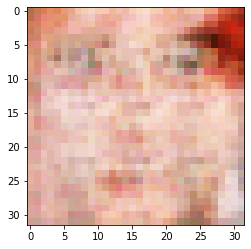

In [12]:
error_d_m1, error_g_m1, prediccion_falsa_m1 = entrenar(gan1, 3000, 150, "resultadosGAN-6")

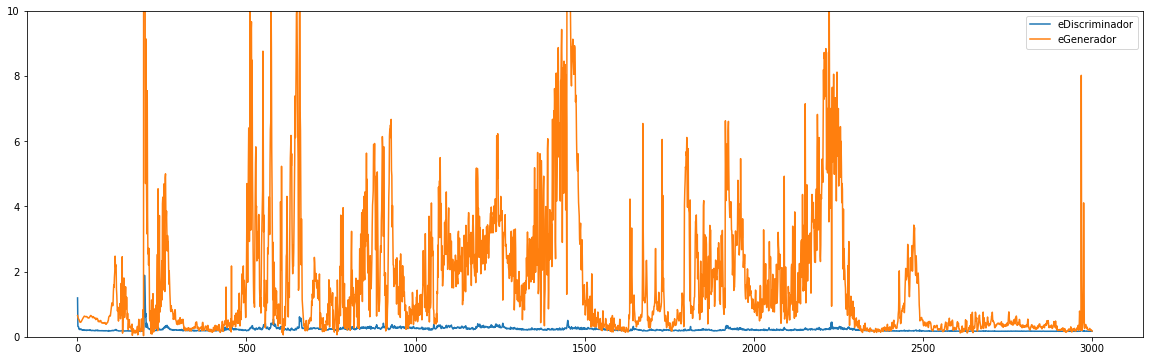

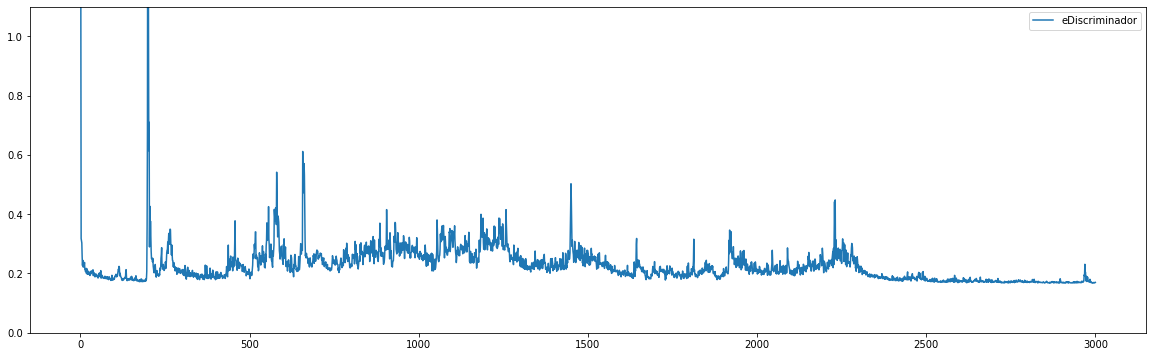

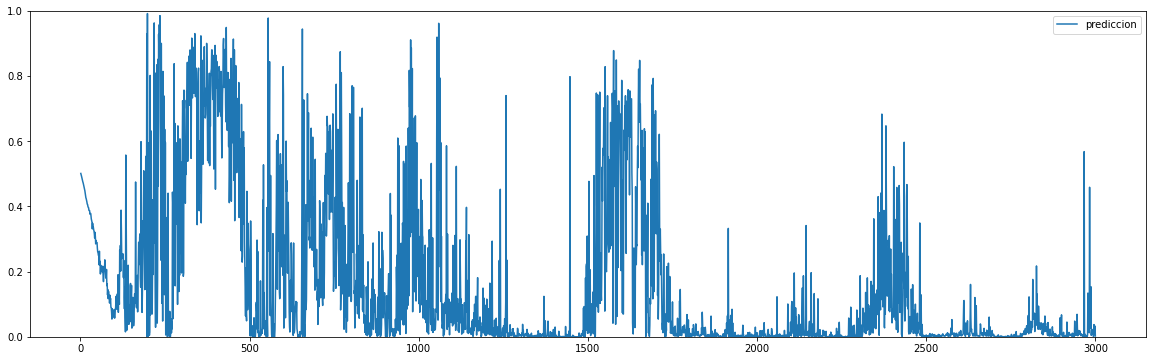

In [13]:
plot_acumulado(len(error_d_m1), 10, eDiscriminador = error_d_m1, eGenerador = error_g_m1)
plot_acumulado(len(error_d_m1), 1.1, eDiscriminador = error_d_m1)
plot_acumulado(len(prediccion_falsa_m1), 1, prediccion = prediccion_falsa_m1)

tf.Tensor([[0.00274569]], shape=(1, 1), dtype=float32)


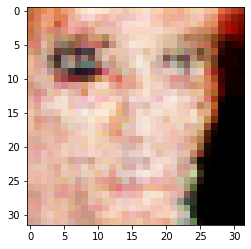

In [18]:
ruido = np.random.normal(0, 1, TAM_ENTRADA)
ruido =np.array([ruido])

predicion(gan1, ruido)


Es el modelo que mejor resultado tuvo:

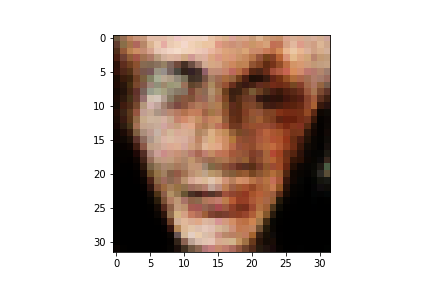

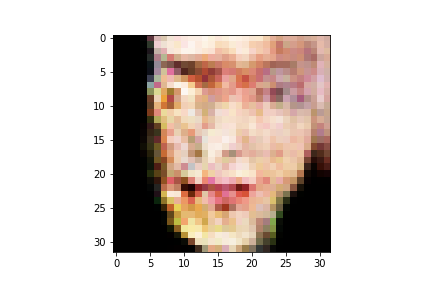

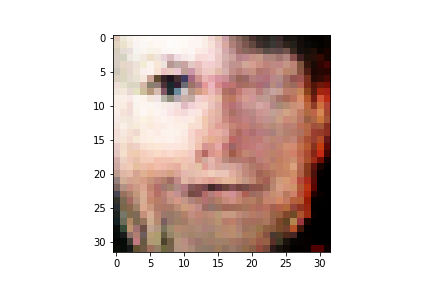

Pero al seguir entrenando perdio calidad

### Segundo modelo

Vamos a cambiar el dataset

In [11]:
x_train = cargar_datos("dataset2/data_tratada/")

Creando set de entrenamiento...
¡Listo!


In [12]:
OPTIMIZADOR2 = optimizador.Adam(learning_rate=0.0002, beta_1=0.5) 
ERROR2 = 'binary_crossentropy' 

gan2 = crear_GAN(OPTIMIZADOR2, ERROR2)

Generador Creado
Discriminador Creado
GAN Creado


Comenzando Epoca 1... Fin
Tiempo transcurrido:  8.13 s
Tiempo restante aprox: 406.67m -> 6:46h
prediccion de ruido:  [[0.50106144]]
Comenzando Epoca 2... Fin
Tiempo transcurrido:  2.56 s
Tiempo restante aprox: 127.93m -> 2:7h
prediccion de ruido:  [[0.49944168]]
Comenzando Epoca 3... Fin
Tiempo transcurrido:  2.55 s
Tiempo restante aprox: 127.5m -> 2:7h
prediccion de ruido:  [[0.49536657]]
Comenzando Epoca 4... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 130.45m -> 2:10h
prediccion de ruido:  [[0.49273372]]
Comenzando Epoca 5... Fin
Tiempo transcurrido:  2.65 s
Tiempo restante aprox: 132.12m -> 2:12h
prediccion de ruido:  [[0.4872716]]
Comenzando Epoca 6... Fin
Tiempo transcurrido:  2.62 s
Tiempo restante aprox: 130.63m -> 2:10h
prediccion de ruido:  [[0.48315826]]
Comenzando Epoca 7... Fin
Tiempo transcurrido:  2.58 s
Tiempo restante aprox: 128.55m -> 2:8h
prediccion de ruido:  [[0.47878844]]
Comenzando Epoca 8... Fin
Tiempo transcurrido:  2.62 s
Tiempo restante aprox: 130

Comenzando Epoca 83... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 122.91m -> 2:2h
prediccion de ruido:  [[0.05079627]]
Comenzando Epoca 84... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 122.87m -> 2:2h
prediccion de ruido:  [[0.03962174]]
Comenzando Epoca 85... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 122.07m -> 2:2h
prediccion de ruido:  [[0.05431965]]
Comenzando Epoca 86... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 121.27m -> 2:1h
prediccion de ruido:  [[0.03878865]]
Comenzando Epoca 87... Fin
Tiempo transcurrido:  2.54 s
Tiempo restante aprox: 123.5m -> 2:3h
prediccion de ruido:  [[0.04099324]]
Comenzando Epoca 88... Fin
Tiempo transcurrido:  2.55 s
Tiempo restante aprox: 123.65m -> 2:3h
prediccion de ruido:  [[0.06668967]]
Comenzando Epoca 89... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 122.71m -> 2:2h
prediccion de ruido:  [[0.04620704]]
Comenzando Epoca 90... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox:

Comenzando Epoca 124... Fin
Tiempo transcurrido:  2.48 s
Tiempo restante aprox: 118.94m -> 1:58h
prediccion de ruido:  [[0.1031858]]
Comenzando Epoca 125... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 119.64m -> 1:59h
prediccion de ruido:  [[0.08024698]]
Comenzando Epoca 126... Fin
Tiempo transcurrido:  2.48 s
Tiempo restante aprox: 118.95m -> 1:58h
prediccion de ruido:  [[0.05823377]]
Comenzando Epoca 127... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 121.25m -> 2:1h
prediccion de ruido:  [[0.12674803]]
Comenzando Epoca 128... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 119.52m -> 1:59h
prediccion de ruido:  [[0.06004632]]
Comenzando Epoca 129... Fin
Tiempo transcurrido:  2.48 s
Tiempo restante aprox: 118.78m -> 1:58h
prediccion de ruido:  [[0.02561831]]
Comenzando Epoca 130... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 119.44m -> 1:59h
prediccion de ruido:  [[0.00750145]]
Comenzando Epoca 131... Fin
Tiempo transcurrido:  2.48 s
Tiempo res

Comenzando Epoca 165... Fin
Tiempo transcurrido:  2.57 s
Tiempo restante aprox: 121.66m -> 2:1h
prediccion de ruido:  [[0.00089151]]
Comenzando Epoca 166... Fin
Tiempo transcurrido:  2.6 s
Tiempo restante aprox: 122.74m -> 2:2h
prediccion de ruido:  [[0.00212818]]
Comenzando Epoca 167... Fin
Tiempo transcurrido:  2.67 s
Tiempo restante aprox: 125.9m -> 2:5h
prediccion de ruido:  [[0.00079998]]
Comenzando Epoca 168... Fin
Tiempo transcurrido:  2.66 s
Tiempo restante aprox: 125.47m -> 2:5h
prediccion de ruido:  [[0.06071019]]
Comenzando Epoca 169... Fin
Tiempo transcurrido:  2.55 s
Tiempo restante aprox: 120.42m -> 2:0h
prediccion de ruido:  [[0.03995481]]
Comenzando Epoca 170... Fin
Tiempo transcurrido:  2.72 s
Tiempo restante aprox: 128.51m -> 2:8h
prediccion de ruido:  [[0.00923041]]
Comenzando Epoca 171... Fin
Tiempo transcurrido:  2.65 s
Tiempo restante aprox: 125.1m -> 2:5h
prediccion de ruido:  [[0.00911638]]
Comenzando Epoca 172... Fin
Tiempo transcurrido:  2.95 s
Tiempo restante

Comenzando Epoca 206... Fin
Tiempo transcurrido:  2.78 s
Tiempo restante aprox: 129.7m -> 2:9h
prediccion de ruido:  [[0.16992363]]
Comenzando Epoca 207... Fin
Tiempo transcurrido:  2.52 s
Tiempo restante aprox: 117.19m -> 1:57h
prediccion de ruido:  [[0.2839365]]
Comenzando Epoca 208... Fin
Tiempo transcurrido:  2.48 s
Tiempo restante aprox: 115.54m -> 1:55h
prediccion de ruido:  [[0.12409759]]
Comenzando Epoca 209... Fin
Tiempo transcurrido:  2.48 s
Tiempo restante aprox: 115.42m -> 1:55h
prediccion de ruido:  [[0.08379588]]
Comenzando Epoca 210... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 116.11m -> 1:56h
prediccion de ruido:  [[0.20718962]]
Comenzando Epoca 211... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 116.06m -> 1:56h
prediccion de ruido:  [[0.11506155]]
Comenzando Epoca 212... Fin
Tiempo transcurrido:  2.48 s
Tiempo restante aprox: 115.3m -> 1:55h
prediccion de ruido:  [[0.26978773]]
Comenzando Epoca 213... Fin
Tiempo transcurrido:  2.48 s
Tiempo rest

Comenzando Epoca 247... Fin
Tiempo transcurrido:  2.48 s
Tiempo restante aprox: 113.85m -> 1:53h
prediccion de ruido:  [[0.23062766]]
Comenzando Epoca 248... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 114.53m -> 1:54h
prediccion de ruido:  [[0.2037496]]
Comenzando Epoca 249... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 114.48m -> 1:54h
prediccion de ruido:  [[0.13718352]]
Comenzando Epoca 250... Fin
Tiempo transcurrido:  2.48 s
Tiempo restante aprox: 113.73m -> 1:53h
prediccion de ruido:  [[0.3147192]]
Comenzando Epoca 251... Fin
Tiempo transcurrido:  2.48 s
Tiempo restante aprox: 113.73m -> 1:53h
prediccion de ruido:  [[0.11992145]]
Comenzando Epoca 252... Fin
Tiempo transcurrido:  2.48 s
Tiempo restante aprox: 113.64m -> 1:53h
prediccion de ruido:  [[0.17816442]]
Comenzando Epoca 253... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 114.32m -> 1:54h
prediccion de ruido:  [[0.31134698]]
Comenzando Epoca 254... Fin
Tiempo transcurrido:  2.48 s
Tiempo res

Comenzando Epoca 288... Fin
Tiempo transcurrido:  2.46 s
Tiempo restante aprox: 111.45m -> 1:51h
prediccion de ruido:  [[0.4974007]]
Comenzando Epoca 289... Fin
Tiempo transcurrido:  2.46 s
Tiempo restante aprox: 111.41m -> 1:51h
prediccion de ruido:  [[0.26378992]]
Comenzando Epoca 290... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 112.78m -> 1:52h
prediccion de ruido:  [[0.4328112]]
Comenzando Epoca 291... Fin
Tiempo transcurrido:  2.48 s
Tiempo restante aprox: 112.03m -> 1:52h
prediccion de ruido:  [[0.7926982]]
Comenzando Epoca 292... Fin
Tiempo transcurrido:  2.48 s
Tiempo restante aprox: 111.99m -> 1:51h
prediccion de ruido:  [[0.00391474]]
Comenzando Epoca 293... Fin
Tiempo transcurrido:  2.48 s
Tiempo restante aprox: 111.95m -> 1:51h
prediccion de ruido:  [[0.25195554]]
Comenzando Epoca 294... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 112.7m -> 1:52h
prediccion de ruido:  [[2.3474474e-06]]
Comenzando Epoca 295... Fin
Tiempo transcurrido:  2.47 s
Tiempo r

Comenzando Epoca 329... Fin
Tiempo transcurrido:  2.48 s
Tiempo restante aprox: 110.59m -> 1:50h
prediccion de ruido:  [[0.5043849]]
Comenzando Epoca 330... Fin
Tiempo transcurrido:  2.48 s
Tiempo restante aprox: 110.42m -> 1:50h
prediccion de ruido:  [[0.28763753]]
Comenzando Epoca 331... Fin
Tiempo transcurrido:  2.48 s
Tiempo restante aprox: 110.38m -> 1:50h
prediccion de ruido:  [[0.41164118]]
Comenzando Epoca 332... Fin
Tiempo transcurrido:  2.48 s
Tiempo restante aprox: 110.34m -> 1:50h
prediccion de ruido:  [[0.29152554]]
Comenzando Epoca 333... Fin
Tiempo transcurrido:  2.48 s
Tiempo restante aprox: 110.3m -> 1:50h
prediccion de ruido:  [[0.48426136]]
Comenzando Epoca 334... Fin
Tiempo transcurrido:  2.48 s
Tiempo restante aprox: 110.25m -> 1:50h
prediccion de ruido:  [[0.35070485]]
Comenzando Epoca 335... Fin
Tiempo transcurrido:  2.48 s
Tiempo restante aprox: 110.21m -> 1:50h
prediccion de ruido:  [[0.40613183]]
Comenzando Epoca 336... Fin
Tiempo transcurrido:  2.5 s
Tiempo r

Comenzando Epoca 370... Fin
Tiempo transcurrido:  2.67 s
Tiempo restante aprox: 117.13m -> 1:57h
prediccion de ruido:  [[0.6336735]]
Comenzando Epoca 371... Fin
Tiempo transcurrido:  2.63 s
Tiempo restante aprox: 115.26m -> 1:55h
prediccion de ruido:  [[0.37875992]]
Comenzando Epoca 372... Fin
Tiempo transcurrido:  2.59 s
Tiempo restante aprox: 113.62m -> 1:53h
prediccion de ruido:  [[0.71214855]]
Comenzando Epoca 373... Fin
Tiempo transcurrido:  2.6 s
Tiempo restante aprox: 113.97m -> 1:53h
prediccion de ruido:  [[0.48761928]]
Comenzando Epoca 374... Fin
Tiempo transcurrido:  2.52 s
Tiempo restante aprox: 110.38m -> 1:50h
prediccion de ruido:  [[0.6991887]]
Comenzando Epoca 375... Fin
Tiempo transcurrido:  2.62 s
Tiempo restante aprox: 114.45m -> 1:54h
prediccion de ruido:  [[0.27435428]]
Comenzando Epoca 376... Fin
Tiempo transcurrido:  2.57 s
Tiempo restante aprox: 112.39m -> 1:52h
prediccion de ruido:  [[0.516847]]
Comenzando Epoca 377... Fin
Tiempo transcurrido:  2.53 s
Tiempo res

Comenzando Epoca 411... Fin
Tiempo transcurrido:  2.82 s
Tiempo restante aprox: 121.72m -> 2:1h
prediccion de ruido:  [[0.7818901]]
Comenzando Epoca 412... Fin
Tiempo transcurrido:  2.67 s
Tiempo restante aprox: 115.12m -> 1:55h
prediccion de ruido:  [[0.7359403]]
Comenzando Epoca 413... Fin
Tiempo transcurrido:  2.69 s
Tiempo restante aprox: 116.16m -> 1:56h
prediccion de ruido:  [[0.5786204]]
Comenzando Epoca 414... Fin
Tiempo transcurrido:  2.6 s
Tiempo restante aprox: 112.02m -> 1:52h
prediccion de ruido:  [[0.695019]]
Comenzando Epoca 415... Fin
Tiempo transcurrido:  2.64 s
Tiempo restante aprox: 113.87m -> 1:53h
prediccion de ruido:  [[0.7549835]]
Comenzando Epoca 416... Fin
Tiempo transcurrido:  2.6 s
Tiempo restante aprox: 112.02m -> 1:52h
prediccion de ruido:  [[0.7277664]]
Comenzando Epoca 417... Fin
Tiempo transcurrido:  2.52 s
Tiempo restante aprox: 108.66m -> 1:48h
prediccion de ruido:  [[0.6921069]]
Comenzando Epoca 418... Fin
Tiempo transcurrido:  2.59 s
Tiempo restante 

Comenzando Epoca 452... Fin
Tiempo transcurrido:  2.56 s
Tiempo restante aprox: 108.56m -> 1:48h
prediccion de ruido:  [[0.8039753]]
Comenzando Epoca 453... Fin
Tiempo transcurrido:  2.66 s
Tiempo restante aprox: 112.98m -> 1:52h
prediccion de ruido:  [[0.7166325]]
Comenzando Epoca 454... Fin
Tiempo transcurrido:  2.64 s
Tiempo restante aprox: 111.96m -> 1:51h
prediccion de ruido:  [[0.68305117]]
Comenzando Epoca 455... Fin
Tiempo transcurrido:  2.57 s
Tiempo restante aprox: 108.99m -> 1:48h
prediccion de ruido:  [[0.77920043]]
Comenzando Epoca 456... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 110.77m -> 1:50h
prediccion de ruido:  [[0.84171605]]
Comenzando Epoca 457... Fin
Tiempo transcurrido:  2.6 s
Tiempo restante aprox: 110.32m -> 1:50h
prediccion de ruido:  [[0.73121226]]
Comenzando Epoca 458... Fin
Tiempo transcurrido:  2.66 s
Tiempo restante aprox: 112.6m -> 1:52h
prediccion de ruido:  [[0.70807207]]
Comenzando Epoca 459... Fin
Tiempo transcurrido:  2.59 s
Tiempo re

Comenzando Epoca 493... Fin
Tiempo transcurrido:  2.62 s
Tiempo restante aprox: 109.46m -> 1:49h
prediccion de ruido:  [[0.59097636]]
Comenzando Epoca 494... Fin
Tiempo transcurrido:  2.64 s
Tiempo restante aprox: 110.45m -> 1:50h
prediccion de ruido:  [[0.41614693]]
Comenzando Epoca 495... Fin
Tiempo transcurrido:  2.64 s
Tiempo restante aprox: 110.22m -> 1:50h
prediccion de ruido:  [[0.6796255]]
Comenzando Epoca 496... Fin
Tiempo transcurrido:  2.58 s
Tiempo restante aprox: 107.69m -> 1:47h
prediccion de ruido:  [[0.38248104]]
Comenzando Epoca 497... Fin
Tiempo transcurrido:  2.62 s
Tiempo restante aprox: 109.15m -> 1:49h
prediccion de ruido:  [[0.4028898]]
Comenzando Epoca 498... Fin
Tiempo transcurrido:  2.63 s
Tiempo restante aprox: 109.69m -> 1:49h
prediccion de ruido:  [[0.3500955]]
Comenzando Epoca 499... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 105.62m -> 1:45h
prediccion de ruido:  [[0.42307356]]
Comenzando Epoca 500... Fin
Tiempo transcurrido:  2.75 s
Tiempo r

Comenzando Epoca 534... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 103.93m -> 1:43h
prediccion de ruido:  [[0.4033055]]
Comenzando Epoca 535... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 102.6m -> 1:42h
prediccion de ruido:  [[0.2221227]]
Comenzando Epoca 536... Fin
Tiempo transcurrido:  2.48 s
Tiempo restante aprox: 101.92m -> 1:41h
prediccion de ruido:  [[0.27990225]]
Comenzando Epoca 537... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 103.8m -> 1:43h
prediccion de ruido:  [[0.12876174]]
Comenzando Epoca 538... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 102.47m -> 1:42h
prediccion de ruido:  [[0.31076548]]
Comenzando Epoca 539... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 103.19m -> 1:43h
prediccion de ruido:  [[0.05668333]]
Comenzando Epoca 540... Fin
Tiempo transcurrido:  2.48 s
Tiempo restante aprox: 101.83m -> 1:41h
prediccion de ruido:  [[0.0630134]]
Comenzando Epoca 541... Fin
Tiempo transcurrido:  2.5 s
Tiempo restan

Comenzando Epoca 575... Fin
Tiempo transcurrido:  2.58 s
Tiempo restante aprox: 104.26m -> 1:44h
prediccion de ruido:  [[0.00088421]]
Comenzando Epoca 576... Fin
Tiempo transcurrido:  2.55 s
Tiempo restante aprox: 103.18m -> 1:43h
prediccion de ruido:  [[0.00954258]]
Comenzando Epoca 577... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 101.56m -> 1:41h
prediccion de ruido:  [[0.00347662]]
Comenzando Epoca 578... Fin
Tiempo transcurrido:  2.62 s
Tiempo restante aprox: 106.0m -> 1:45h
prediccion de ruido:  [[0.01177329]]
Comenzando Epoca 579... Fin
Tiempo transcurrido:  2.58 s
Tiempo restante aprox: 104.19m -> 1:44h
prediccion de ruido:  [[0.01108491]]
Comenzando Epoca 580... Fin
Tiempo transcurrido:  2.54 s
Tiempo restante aprox: 102.59m -> 1:42h
prediccion de ruido:  [[0.00489655]]
Comenzando Epoca 581... Fin
Tiempo transcurrido:  2.59 s
Tiempo restante aprox: 104.3m -> 1:44h
prediccion de ruido:  [[0.00440943]]
Comenzando Epoca 582... Fin
Tiempo transcurrido:  2.6 s
Tiempo r

Comenzando Epoca 616... Fin
Tiempo transcurrido:  2.56 s
Tiempo restante aprox: 101.65m -> 1:41h
prediccion de ruido:  [[0.00206497]]
Comenzando Epoca 617... Fin
Tiempo transcurrido:  2.55 s
Tiempo restante aprox: 101.14m -> 1:41h
prediccion de ruido:  [[0.00885671]]
Comenzando Epoca 618... Fin
Tiempo transcurrido:  2.55 s
Tiempo restante aprox: 101.35m -> 1:41h
prediccion de ruido:  [[0.02183479]]
Comenzando Epoca 619... Fin
Tiempo transcurrido:  2.62 s
Tiempo restante aprox: 104.1m -> 1:44h
prediccion de ruido:  [[0.00407603]]
Comenzando Epoca 620... Fin
Tiempo transcurrido:  2.52 s
Tiempo restante aprox: 100.03m -> 1:40h
prediccion de ruido:  [[0.00814095]]
Comenzando Epoca 621... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 99.76m -> 1:39h
prediccion de ruido:  [[0.03029922]]
Comenzando Epoca 622... Fin
Tiempo transcurrido:  2.59 s
Tiempo restante aprox: 102.69m -> 1:42h
prediccion de ruido:  [[0.2121653]]
Comenzando Epoca 623... Fin
Tiempo transcurrido:  2.57 s
Tiempo r

Comenzando Epoca 657... Fin
Tiempo transcurrido:  2.55 s
Tiempo restante aprox: 99.55m -> 1:39h
prediccion de ruido:  [[0.15978885]]
Comenzando Epoca 658... Fin
Tiempo transcurrido:  2.62 s
Tiempo restante aprox: 102.32m -> 1:42h
prediccion de ruido:  [[0.5666559]]
Comenzando Epoca 659... Fin
Tiempo transcurrido:  2.56 s
Tiempo restante aprox: 99.95m -> 1:39h
prediccion de ruido:  [[0.52342016]]
Comenzando Epoca 660... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 97.7m -> 1:37h
prediccion de ruido:  [[0.1933937]]
Comenzando Epoca 661... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 98.03m -> 1:38h
prediccion de ruido:  [[0.68938065]]
Comenzando Epoca 662... Fin
Tiempo transcurrido:  2.62 s
Tiempo restante aprox: 101.99m -> 1:41h
prediccion de ruido:  [[0.53254616]]
Comenzando Epoca 663... Fin
Tiempo transcurrido:  2.52 s
Tiempo restante aprox: 98.03m -> 1:38h
prediccion de ruido:  [[0.6613016]]
Comenzando Epoca 664... Fin
Tiempo transcurrido:  2.56 s
Tiempo restante

Comenzando Epoca 698... Fin
Tiempo transcurrido:  2.63 s
Tiempo restante aprox: 101.0m -> 1:40h
prediccion de ruido:  [[0.75612485]]
Comenzando Epoca 699... Fin
Tiempo transcurrido:  2.83 s
Tiempo restante aprox: 108.59m -> 1:48h
prediccion de ruido:  [[0.78230274]]
Comenzando Epoca 700... Fin
Tiempo transcurrido:  2.75 s
Tiempo restante aprox: 105.32m -> 1:45h
prediccion de ruido:  [[0.8192604]]
Comenzando Epoca 701... Fin
Tiempo transcurrido:  2.65 s
Tiempo restante aprox: 101.75m -> 1:41h
prediccion de ruido:  [[0.7622213]]
Comenzando Epoca 702... Fin
Tiempo transcurrido:  2.68 s
Tiempo restante aprox: 102.61m -> 1:42h
prediccion de ruido:  [[0.7185831]]
Comenzando Epoca 703... Fin
Tiempo transcurrido:  2.59 s
Tiempo restante aprox: 99.21m -> 1:39h
prediccion de ruido:  [[0.7245451]]
Comenzando Epoca 704... Fin
Tiempo transcurrido:  2.57 s
Tiempo restante aprox: 98.31m -> 1:38h
prediccion de ruido:  [[0.7099849]]
Comenzando Epoca 705... Fin
Tiempo transcurrido:  3.04 s
Tiempo restan

Comenzando Epoca 739... Fin
Tiempo transcurrido:  2.52 s
Tiempo restante aprox: 95.16m -> 1:35h
prediccion de ruido:  [[0.80472076]]
Comenzando Epoca 740... Fin
Tiempo transcurrido:  2.49 s
Tiempo restante aprox: 93.98m -> 1:33h
prediccion de ruido:  [[0.74826825]]
Comenzando Epoca 741... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 94.47m -> 1:34h
prediccion de ruido:  [[0.84002423]]
Comenzando Epoca 742... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 93.96m -> 1:33h
prediccion de ruido:  [[0.8053576]]
Comenzando Epoca 743... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 94.3m -> 1:34h
prediccion de ruido:  [[0.8232492]]
Comenzando Epoca 744... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 94.35m -> 1:34h
prediccion de ruido:  [[0.80708694]]
Comenzando Epoca 745... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 94.32m -> 1:34h
prediccion de ruido:  [[0.6991852]]
Comenzando Epoca 746... Fin
Tiempo transcurrido:  2.49 s
Tiempo restante a

Comenzando Epoca 780... Fin
Tiempo transcurrido:  2.49 s
Tiempo restante aprox: 92.13m -> 1:32h
prediccion de ruido:  [[0.7705369]]
Comenzando Epoca 781... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 93.58m -> 1:33h
prediccion de ruido:  [[0.71673715]]
Comenzando Epoca 782... Fin
Tiempo transcurrido:  2.49 s
Tiempo restante aprox: 92.08m -> 1:32h
prediccion de ruido:  [[0.7825328]]
Comenzando Epoca 783... Fin
Tiempo transcurrido:  2.49 s
Tiempo restante aprox: 92.0m -> 1:32h
prediccion de ruido:  [[0.7837066]]
Comenzando Epoca 784... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 92.38m -> 1:32h
prediccion de ruido:  [[0.50562334]]
Comenzando Epoca 785... Fin
Tiempo transcurrido:  2.49 s
Tiempo restante aprox: 91.92m -> 1:31h
prediccion de ruido:  [[0.4975393]]
Comenzando Epoca 786... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 92.46m -> 1:32h
prediccion de ruido:  [[0.594239]]
Comenzando Epoca 787... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox:

Comenzando Epoca 821... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 91.25m -> 1:31h
prediccion de ruido:  [[8.415294e-11]]
Comenzando Epoca 822... Fin
Tiempo transcurrido:  2.86 s
Tiempo restante aprox: 103.95m -> 1:43h
prediccion de ruido:  [[4.1756414e-11]]
Comenzando Epoca 823... Fin
Tiempo transcurrido:  2.67 s
Tiempo restante aprox: 96.84m -> 1:36h
prediccion de ruido:  [[4.774824e-10]]
Comenzando Epoca 824... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 91.13m -> 1:31h
prediccion de ruido:  [[1.0258939e-11]]
Comenzando Epoca 825... Fin
Tiempo transcurrido:  2.88 s
Tiempo restante aprox: 104.5m -> 1:44h
prediccion de ruido:  [[1.1961401e-08]]
Comenzando Epoca 826... Fin
Tiempo transcurrido:  3.12 s
Tiempo restante aprox: 112.92m -> 1:52h
prediccion de ruido:  [[2.1329693e-11]]
Comenzando Epoca 827... Fin
Tiempo transcurrido:  3.37 s
Tiempo restante aprox: 122.11m -> 2:2h
prediccion de ruido:  [[9.431467e-10]]
Comenzando Epoca 828... Fin
Tiempo transcurrido: 

Comenzando Epoca 862... Fin
Tiempo transcurrido:  2.77 s
Tiempo restante aprox: 98.93m -> 1:38h
prediccion de ruido:  [[0.01083633]]
Comenzando Epoca 863... Fin
Tiempo transcurrido:  3.09 s
Tiempo restante aprox: 110.04m -> 1:50h
prediccion de ruido:  [[0.0764285]]
Comenzando Epoca 864... Fin
Tiempo transcurrido:  2.74 s
Tiempo restante aprox: 97.43m -> 1:37h
prediccion de ruido:  [[0.01166826]]
Comenzando Epoca 865... Fin
Tiempo transcurrido:  2.66 s
Tiempo restante aprox: 94.87m -> 1:34h
prediccion de ruido:  [[0.01918074]]
Comenzando Epoca 866... Fin
Tiempo transcurrido:  2.6 s
Tiempo restante aprox: 92.68m -> 1:32h
prediccion de ruido:  [[0.00221762]]
Comenzando Epoca 867... Fin
Tiempo transcurrido:  2.96 s
Tiempo restante aprox: 105.28m -> 1:45h
prediccion de ruido:  [[0.04217905]]
Comenzando Epoca 868... Fin
Tiempo transcurrido:  2.89 s
Tiempo restante aprox: 102.78m -> 1:42h
prediccion de ruido:  [[0.0949989]]
Comenzando Epoca 869... Fin
Tiempo transcurrido:  2.94 s
Tiempo resta

Comenzando Epoca 903... Fin
Tiempo transcurrido:  2.7 s
Tiempo restante aprox: 94.31m -> 1:34h
prediccion de ruido:  [[0.410357]]
Comenzando Epoca 904... Fin
Tiempo transcurrido:  2.9 s
Tiempo restante aprox: 101.36m -> 1:41h
prediccion de ruido:  [[0.31559366]]
Comenzando Epoca 905... Fin
Tiempo transcurrido:  2.83 s
Tiempo restante aprox: 98.69m -> 1:38h
prediccion de ruido:  [[0.07252622]]
Comenzando Epoca 906... Fin
Tiempo transcurrido:  2.86 s
Tiempo restante aprox: 99.79m -> 1:39h
prediccion de ruido:  [[0.23169968]]
Comenzando Epoca 907... Fin
Tiempo transcurrido:  2.73 s
Tiempo restante aprox: 95.31m -> 1:35h
prediccion de ruido:  [[0.11919695]]
Comenzando Epoca 908... Fin
Tiempo transcurrido:  2.83 s
Tiempo restante aprox: 98.86m -> 1:38h
prediccion de ruido:  [[0.31856853]]
Comenzando Epoca 909... Fin
Tiempo transcurrido:  2.68 s
Tiempo restante aprox: 93.48m -> 1:33h
prediccion de ruido:  [[0.13983145]]
Comenzando Epoca 910... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante

Comenzando Epoca 944... Fin
Tiempo transcurrido:  2.78 s
Tiempo restante aprox: 95.33m -> 1:35h
prediccion de ruido:  [[0.43326104]]
Comenzando Epoca 945... Fin
Tiempo transcurrido:  2.48 s
Tiempo restante aprox: 84.86m -> 1:24h
prediccion de ruido:  [[0.20053506]]
Comenzando Epoca 946... Fin
Tiempo transcurrido:  2.71 s
Tiempo restante aprox: 92.85m -> 1:32h
prediccion de ruido:  [[0.02154854]]
Comenzando Epoca 947... Fin
Tiempo transcurrido:  2.59 s
Tiempo restante aprox: 88.77m -> 1:28h
prediccion de ruido:  [[0.09227133]]
Comenzando Epoca 948... Fin
Tiempo transcurrido:  2.55 s
Tiempo restante aprox: 87.35m -> 1:27h
prediccion de ruido:  [[0.09251848]]
Comenzando Epoca 949... Fin
Tiempo transcurrido:  3.14 s
Tiempo restante aprox: 107.33m -> 1:47h
prediccion de ruido:  [[0.2541325]]
Comenzando Epoca 950... Fin
Tiempo transcurrido:  2.74 s
Tiempo restante aprox: 93.49m -> 1:33h
prediccion de ruido:  [[0.05860379]]
Comenzando Epoca 951... Fin
Tiempo transcurrido:  2.76 s
Tiempo resta

Comenzando Epoca 985... Fin
Tiempo transcurrido:  2.78 s
Tiempo restante aprox: 93.5m -> 1:33h
prediccion de ruido:  [[0.0002341]]
Comenzando Epoca 986... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 87.58m -> 1:27h
prediccion de ruido:  [[0.00010326]]
Comenzando Epoca 987... Fin
Tiempo transcurrido:  2.79 s
Tiempo restante aprox: 93.66m -> 1:33h
prediccion de ruido:  [[0.00108173]]
Comenzando Epoca 988... Fin
Tiempo transcurrido:  2.73 s
Tiempo restante aprox: 91.64m -> 1:31h
prediccion de ruido:  [[0.0018487]]
Comenzando Epoca 989... Fin
Tiempo transcurrido:  2.48 s
Tiempo restante aprox: 83.18m -> 1:23h
prediccion de ruido:  [[0.00026825]]
Comenzando Epoca 990... Fin
Tiempo transcurrido:  2.82 s
Tiempo restante aprox: 94.62m -> 1:34h
prediccion de ruido:  [[0.00324503]]
Comenzando Epoca 991... Fin
Tiempo transcurrido:  2.7 s
Tiempo restante aprox: 90.56m -> 1:30h
prediccion de ruido:  [[0.00318703]]
Comenzando Epoca 992... Fin
Tiempo transcurrido:  2.6 s
Tiempo restante a

Comenzando Epoca 1026... Fin
Tiempo transcurrido:  2.52 s
Tiempo restante aprox: 83.03m -> 1:23h
prediccion de ruido:  [[0.19442442]]
Comenzando Epoca 1027... Fin
Tiempo transcurrido:  2.69 s
Tiempo restante aprox: 88.36m -> 1:28h
prediccion de ruido:  [[0.6168007]]
Comenzando Epoca 1028... Fin
Tiempo transcurrido:  2.58 s
Tiempo restante aprox: 84.84m -> 1:24h
prediccion de ruido:  [[0.08920616]]
Comenzando Epoca 1029... Fin
Tiempo transcurrido:  2.6 s
Tiempo restante aprox: 85.58m -> 1:25h
prediccion de ruido:  [[0.44139796]]
Comenzando Epoca 1030... Fin
Tiempo transcurrido:  2.62 s
Tiempo restante aprox: 86.0m -> 1:26h
prediccion de ruido:  [[0.21973622]]
Comenzando Epoca 1031... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 85.79m -> 1:25h
prediccion de ruido:  [[0.17878926]]
Comenzando Epoca 1032... Fin
Tiempo transcurrido:  2.73 s
Tiempo restante aprox: 89.46m -> 1:29h
prediccion de ruido:  [[0.25899756]]
Comenzando Epoca 1033... Fin
Tiempo transcurrido:  2.89 s
Tiempo 

Comenzando Epoca 1067... Fin
Tiempo transcurrido:  2.58 s
Tiempo restante aprox: 83.1m -> 1:23h
prediccion de ruido:  [[0.593778]]
Comenzando Epoca 1068... Fin
Tiempo transcurrido:  2.69 s
Tiempo restante aprox: 86.65m -> 1:26h
prediccion de ruido:  [[0.7533107]]
Comenzando Epoca 1069... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 80.37m -> 1:20h
prediccion de ruido:  [[0.7045758]]
Comenzando Epoca 1070... Fin
Tiempo transcurrido:  2.56 s
Tiempo restante aprox: 82.38m -> 1:22h
prediccion de ruido:  [[0.36626709]]
Comenzando Epoca 1071... Fin
Tiempo transcurrido:  2.63 s
Tiempo restante aprox: 84.53m -> 1:24h
prediccion de ruido:  [[0.73360103]]
Comenzando Epoca 1072... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 80.31m -> 1:20h
prediccion de ruido:  [[0.5060277]]
Comenzando Epoca 1073... Fin
Tiempo transcurrido:  2.48 s
Tiempo restante aprox: 79.8m -> 1:19h
prediccion de ruido:  [[0.63231695]]
Comenzando Epoca 1074... Fin
Tiempo transcurrido:  2.48 s
Tiempo restan

Comenzando Epoca 1108... Fin
Tiempo transcurrido:  2.48 s
Tiempo restante aprox: 78.26m -> 1:18h
prediccion de ruido:  [[0.47434327]]
Comenzando Epoca 1109... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 78.77m -> 1:18h
prediccion de ruido:  [[0.5891762]]
Comenzando Epoca 1110... Fin
Tiempo transcurrido:  2.48 s
Tiempo restante aprox: 78.17m -> 1:18h
prediccion de ruido:  [[0.43297935]]
Comenzando Epoca 1111... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 78.62m -> 1:18h
prediccion de ruido:  [[0.6886811]]
Comenzando Epoca 1112... Fin
Tiempo transcurrido:  2.46 s
Tiempo restante aprox: 77.6m -> 1:17h
prediccion de ruido:  [[0.5661464]]
Comenzando Epoca 1113... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 78.54m -> 1:18h
prediccion de ruido:  [[0.623801]]
Comenzando Epoca 1114... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 78.5m -> 1:18h
prediccion de ruido:  [[0.68644875]]
Comenzando Epoca 1115... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante 

Comenzando Epoca 1149... Fin
Tiempo transcurrido:  2.47 s
Tiempo restante aprox: 76.33m -> 1:16h
prediccion de ruido:  [[0.6506556]]
Comenzando Epoca 1150... Fin
Tiempo transcurrido:  2.48 s
Tiempo restante aprox: 76.41m -> 1:16h
prediccion de ruido:  [[0.28760958]]
Comenzando Epoca 1151... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 77.27m -> 1:17h
prediccion de ruido:  [[0.5529632]]
Comenzando Epoca 1152... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 77.09m -> 1:17h
prediccion de ruido:  [[0.61786324]]
Comenzando Epoca 1153... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 77.39m -> 1:17h
prediccion de ruido:  [[0.19761011]]
Comenzando Epoca 1154... Fin
Tiempo transcurrido:  2.65 s
Tiempo restante aprox: 81.52m -> 1:21h
prediccion de ruido:  [[0.25524664]]
Comenzando Epoca 1155... Fin
Tiempo transcurrido:  2.57 s
Tiempo restante aprox: 79.02m -> 1:19h
prediccion de ruido:  [[0.58464676]]
Comenzando Epoca 1156... Fin
Tiempo transcurrido:  2.79 s
Tiempo 

Comenzando Epoca 1190... Fin
Tiempo transcurrido:  3.56 s
Tiempo restante aprox: 107.6m -> 1:47h
prediccion de ruido:  [[0.36678794]]
Comenzando Epoca 1191... Fin
Tiempo transcurrido:  4.62 s
Tiempo restante aprox: 139.36m -> 2:19h
prediccion de ruido:  [[0.06965682]]
Comenzando Epoca 1192... Fin
Tiempo transcurrido:  2.55 s
Tiempo restante aprox: 77.01m -> 1:17h
prediccion de ruido:  [[0.08760008]]
Comenzando Epoca 1193... Fin
Tiempo transcurrido:  2.52 s
Tiempo restante aprox: 75.95m -> 1:15h
prediccion de ruido:  [[0.18509892]]
Comenzando Epoca 1194... Fin
Tiempo transcurrido:  2.58 s
Tiempo restante aprox: 77.65m -> 1:17h
prediccion de ruido:  [[0.04015505]]
Comenzando Epoca 1195... Fin
Tiempo transcurrido:  2.54 s
Tiempo restante aprox: 76.55m -> 1:16h
prediccion de ruido:  [[0.12089226]]
Comenzando Epoca 1196... Fin
Tiempo transcurrido:  2.58 s
Tiempo restante aprox: 77.69m -> 1:17h
prediccion de ruido:  [[0.01255846]]
Comenzando Epoca 1197... Fin
Tiempo transcurrido:  2.55 s
Tie

Comenzando Epoca 1231... Fin
Tiempo transcurrido:  2.91 s
Tiempo restante aprox: 85.91m -> 1:25h
prediccion de ruido:  [[0.06380612]]
Comenzando Epoca 1232... Fin
Tiempo transcurrido:  2.73 s
Tiempo restante aprox: 80.35m -> 1:20h
prediccion de ruido:  [[0.00721851]]
Comenzando Epoca 1233... Fin
Tiempo transcurrido:  2.57 s
Tiempo restante aprox: 75.61m -> 1:15h
prediccion de ruido:  [[0.03371263]]
Comenzando Epoca 1234... Fin
Tiempo transcurrido:  2.55 s
Tiempo restante aprox: 74.97m -> 1:14h
prediccion de ruido:  [[0.06268418]]
Comenzando Epoca 1235... Fin
Tiempo transcurrido:  2.54 s
Tiempo restante aprox: 74.81m -> 1:14h
prediccion de ruido:  [[0.0691525]]
Comenzando Epoca 1236... Fin
Tiempo transcurrido:  2.76 s
Tiempo restante aprox: 81.27m -> 1:21h
prediccion de ruido:  [[0.0051896]]
Comenzando Epoca 1237... Fin
Tiempo transcurrido:  2.79 s
Tiempo restante aprox: 82.12m -> 1:22h
prediccion de ruido:  [[0.00056195]]
Comenzando Epoca 1238... Fin
Tiempo transcurrido:  2.63 s
Tiempo

Comenzando Epoca 1272... Fin
Tiempo transcurrido:  2.82 s
Tiempo restante aprox: 81.39m -> 1:21h
prediccion de ruido:  [[0.00051963]]
Comenzando Epoca 1273... Fin
Tiempo transcurrido:  2.72 s
Tiempo restante aprox: 78.2m -> 1:18h
prediccion de ruido:  [[0.00076649]]
Comenzando Epoca 1274... Fin
Tiempo transcurrido:  2.99 s
Tiempo restante aprox: 86.16m -> 1:26h
prediccion de ruido:  [[0.00013798]]
Comenzando Epoca 1275... Fin
Tiempo transcurrido:  2.73 s
Tiempo restante aprox: 78.54m -> 1:18h
prediccion de ruido:  [[8.487658e-05]]
Comenzando Epoca 1276... Fin
Tiempo transcurrido:  2.68 s
Tiempo restante aprox: 76.91m -> 1:16h
prediccion de ruido:  [[0.00036827]]
Comenzando Epoca 1277... Fin
Tiempo transcurrido:  2.63 s
Tiempo restante aprox: 75.49m -> 1:15h
prediccion de ruido:  [[0.00048438]]
Comenzando Epoca 1278... Fin
Tiempo transcurrido:  2.52 s
Tiempo restante aprox: 72.46m -> 1:12h
prediccion de ruido:  [[0.00099415]]
Comenzando Epoca 1279... Fin
Tiempo transcurrido:  2.64 s
Tie

Comenzando Epoca 1313... Fin
Tiempo transcurrido:  2.69 s
Tiempo restante aprox: 75.71m -> 1:15h
prediccion de ruido:  [[0.00014532]]
Comenzando Epoca 1314... Fin
Tiempo transcurrido:  2.55 s
Tiempo restante aprox: 71.7m -> 1:11h
prediccion de ruido:  [[7.0694805e-05]]
Comenzando Epoca 1315... Fin
Tiempo transcurrido:  2.6 s
Tiempo restante aprox: 72.95m -> 1:12h
prediccion de ruido:  [[5.1144063e-05]]
Comenzando Epoca 1316... Fin
Tiempo transcurrido:  2.52 s
Tiempo restante aprox: 70.78m -> 1:10h
prediccion de ruido:  [[0.00014716]]
Comenzando Epoca 1317... Fin
Tiempo transcurrido:  2.58 s
Tiempo restante aprox: 72.39m -> 1:12h
prediccion de ruido:  [[8.62261e-05]]
Comenzando Epoca 1318... Fin
Tiempo transcurrido:  2.6 s
Tiempo restante aprox: 72.8m -> 1:12h
prediccion de ruido:  [[0.00038466]]
Comenzando Epoca 1319... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 70.79m -> 1:10h
prediccion de ruido:  [[9.358157e-05]]
Comenzando Epoca 1320... Fin
Tiempo transcurrido:  2.53 s

Comenzando Epoca 1354... Fin
Tiempo transcurrido:  2.52 s
Tiempo restante aprox: 69.1m -> 1:9h
prediccion de ruido:  [[3.0675743e-05]]
Comenzando Epoca 1355... Fin
Tiempo transcurrido:  2.59 s
Tiempo restante aprox: 70.95m -> 1:10h
prediccion de ruido:  [[0.00363028]]
Comenzando Epoca 1356... Fin
Tiempo transcurrido:  2.68 s
Tiempo restante aprox: 73.59m -> 1:13h
prediccion de ruido:  [[0.01494026]]
Comenzando Epoca 1357... Fin
Tiempo transcurrido:  2.57 s
Tiempo restante aprox: 70.32m -> 1:10h
prediccion de ruido:  [[0.00107834]]
Comenzando Epoca 1358... Fin
Tiempo transcurrido:  2.58 s
Tiempo restante aprox: 70.74m -> 1:10h
prediccion de ruido:  [[0.00883535]]
Comenzando Epoca 1359... Fin
Tiempo transcurrido:  2.58 s
Tiempo restante aprox: 70.7m -> 1:10h
prediccion de ruido:  [[0.00155166]]
Comenzando Epoca 1360... Fin
Tiempo transcurrido:  2.62 s
Tiempo restante aprox: 71.58m -> 1:11h
prediccion de ruido:  [[0.00124341]]
Comenzando Epoca 1361... Fin
Tiempo transcurrido:  2.52 s
Tiem

Comenzando Epoca 1395... Fin
Tiempo transcurrido:  2.73 s
Tiempo restante aprox: 73.16m -> 1:13h
prediccion de ruido:  [[0.01823977]]
Comenzando Epoca 1396... Fin
Tiempo transcurrido:  2.63 s
Tiempo restante aprox: 70.23m -> 1:10h
prediccion de ruido:  [[0.00108168]]
Comenzando Epoca 1397... Fin
Tiempo transcurrido:  2.7 s
Tiempo restante aprox: 72.29m -> 1:12h
prediccion de ruido:  [[0.04583314]]
Comenzando Epoca 1398... Fin
Tiempo transcurrido:  2.66 s
Tiempo restante aprox: 71.1m -> 1:11h
prediccion de ruido:  [[0.30493367]]
Comenzando Epoca 1399... Fin
Tiempo transcurrido:  2.87 s
Tiempo restante aprox: 76.7m -> 1:16h
prediccion de ruido:  [[0.03146374]]
Comenzando Epoca 1400... Fin
Tiempo transcurrido:  3.08 s
Tiempo restante aprox: 82.28m -> 1:22h
prediccion de ruido:  [[0.00313386]]
Comenzando Epoca 1401... Fin
Tiempo transcurrido:  2.67 s
Tiempo restante aprox: 71.32m -> 1:11h
prediccion de ruido:  [[0.01635391]]
Comenzando Epoca 1402... Fin
Tiempo transcurrido:  2.5 s
Tiempo r

Comenzando Epoca 1436... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 65.32m -> 1:5h
prediccion de ruido:  [[0.0014981]]
Comenzando Epoca 1437... Fin
Tiempo transcurrido:  2.47 s
Tiempo restante aprox: 64.35m -> 1:4h
prediccion de ruido:  [[0.00192472]]
Comenzando Epoca 1438... Fin
Tiempo transcurrido:  2.58 s
Tiempo restante aprox: 67.3m -> 1:7h
prediccion de ruido:  [[0.04989693]]
Comenzando Epoca 1439... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 65.19m -> 1:5h
prediccion de ruido:  [[0.01777849]]
Comenzando Epoca 1440... Fin
Tiempo transcurrido:  2.64 s
Tiempo restante aprox: 68.68m -> 1:8h
prediccion de ruido:  [[0.27824032]]
Comenzando Epoca 1441... Fin
Tiempo transcurrido:  2.65 s
Tiempo restante aprox: 68.78m -> 1:8h
prediccion de ruido:  [[0.02033621]]
Comenzando Epoca 1442... Fin
Tiempo transcurrido:  2.64 s
Tiempo restante aprox: 68.56m -> 1:8h
prediccion de ruido:  [[0.01441664]]
Comenzando Epoca 1443... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante

Comenzando Epoca 1477... Fin
Tiempo transcurrido:  2.62 s
Tiempo restante aprox: 66.57m -> 1:6h
prediccion de ruido:  [[0.00054789]]
Comenzando Epoca 1478... Fin
Tiempo transcurrido:  2.74 s
Tiempo restante aprox: 69.56m -> 1:9h
prediccion de ruido:  [[0.00019041]]
Comenzando Epoca 1479... Fin
Tiempo transcurrido:  2.62 s
Tiempo restante aprox: 66.37m -> 1:6h
prediccion de ruido:  [[0.00758991]]
Comenzando Epoca 1480... Fin
Tiempo transcurrido:  2.59 s
Tiempo restante aprox: 65.55m -> 1:5h
prediccion de ruido:  [[0.0001972]]
Comenzando Epoca 1481... Fin
Tiempo transcurrido:  2.68 s
Tiempo restante aprox: 68.01m -> 1:8h
prediccion de ruido:  [[0.00355753]]
Comenzando Epoca 1482... Fin
Tiempo transcurrido:  2.64 s
Tiempo restante aprox: 66.94m -> 1:6h
prediccion de ruido:  [[8.150428e-05]]
Comenzando Epoca 1483... Fin
Tiempo transcurrido:  2.58 s
Tiempo restante aprox: 65.35m -> 1:5h
prediccion de ruido:  [[0.00337341]]
Comenzando Epoca 1484... Fin
Tiempo transcurrido:  2.66 s
Tiempo res

Comenzando Epoca 1518... Fin
Tiempo transcurrido:  2.63 s
Tiempo restante aprox: 64.97m -> 1:4h
prediccion de ruido:  [[0.00202936]]
Comenzando Epoca 1519... Fin
Tiempo transcurrido:  2.7 s
Tiempo restante aprox: 66.76m -> 1:6h
prediccion de ruido:  [[0.00142878]]
Comenzando Epoca 1520... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 61.64m -> 1:1h
prediccion de ruido:  [[0.00205606]]
Comenzando Epoca 1521... Fin
Tiempo transcurrido:  2.72 s
Tiempo restante aprox: 67.09m -> 1:7h
prediccion de ruido:  [[0.00024119]]
Comenzando Epoca 1522... Fin
Tiempo transcurrido:  2.78 s
Tiempo restante aprox: 68.47m -> 1:8h
prediccion de ruido:  [[0.00248808]]
Comenzando Epoca 1523... Fin
Tiempo transcurrido:  2.62 s
Tiempo restante aprox: 64.66m -> 1:4h
prediccion de ruido:  [[0.00416461]]
Comenzando Epoca 1524... Fin
Tiempo transcurrido:  2.67 s
Tiempo restante aprox: 65.62m -> 1:5h
prediccion de ruido:  [[0.00478572]]
Comenzando Epoca 1525... Fin
Tiempo transcurrido:  2.71 s
Tiempo restan

Comenzando Epoca 1559... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 60.81m -> 1:0h
prediccion de ruido:  [[0.02232352]]
Comenzando Epoca 1560... Fin
Tiempo transcurrido:  2.52 s
Tiempo restante aprox: 60.5m -> 1:0h
prediccion de ruido:  [[0.06197509]]
Comenzando Epoca 1561... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 59.9m -> 0:59h
prediccion de ruido:  [[0.13853765]]
Comenzando Epoca 1562... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 60.28m -> 1:0h
prediccion de ruido:  [[0.07001662]]
Comenzando Epoca 1563... Fin
Tiempo transcurrido:  2.48 s
Tiempo restante aprox: 59.45m -> 0:59h
prediccion de ruido:  [[0.09345707]]
Comenzando Epoca 1564... Fin
Tiempo transcurrido:  2.55 s
Tiempo restante aprox: 61.17m -> 1:1h
prediccion de ruido:  [[0.0700244]]
Comenzando Epoca 1565... Fin
Tiempo transcurrido:  2.48 s
Tiempo restante aprox: 59.41m -> 0:59h
prediccion de ruido:  [[0.05317926]]
Comenzando Epoca 1566... Fin
Tiempo transcurrido:  2.5 s
Tiempo restan

Comenzando Epoca 1600... Fin
Tiempo transcurrido:  2.88 s
Tiempo restante aprox: 67.2m -> 1:7h
prediccion de ruido:  [[0.7045271]]
Comenzando Epoca 1601... Fin
Tiempo transcurrido:  2.6 s
Tiempo restante aprox: 60.74m -> 1:0h
prediccion de ruido:  [[0.51154166]]
Comenzando Epoca 1602... Fin
Tiempo transcurrido:  3.03 s
Tiempo restante aprox: 70.66m -> 1:10h
prediccion de ruido:  [[0.37490895]]
Comenzando Epoca 1603... Fin
Tiempo transcurrido:  2.84 s
Tiempo restante aprox: 66.13m -> 1:6h
prediccion de ruido:  [[0.31342426]]
Comenzando Epoca 1604... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 58.11m -> 0:58h
prediccion de ruido:  [[0.17955509]]
Comenzando Epoca 1605... Fin
Tiempo transcurrido:  2.69 s
Tiempo restante aprox: 62.52m -> 1:2h
prediccion de ruido:  [[0.3683337]]
Comenzando Epoca 1606... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 58.14m -> 0:58h
prediccion de ruido:  [[0.39836597]]
Comenzando Epoca 1607... Fin
Tiempo transcurrido:  2.52 s
Tiempo restant

Comenzando Epoca 1641... Fin
Tiempo transcurrido:  2.54 s
Tiempo restante aprox: 57.5m -> 0:57h
prediccion de ruido:  [[0.00023574]]
Comenzando Epoca 1642... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 56.86m -> 0:56h
prediccion de ruido:  [[0.0002141]]
Comenzando Epoca 1643... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 56.66m -> 0:56h
prediccion de ruido:  [[0.00234672]]
Comenzando Epoca 1644... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 57.28m -> 0:57h
prediccion de ruido:  [[0.00020289]]
Comenzando Epoca 1645... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 56.54m -> 0:56h
prediccion de ruido:  [[0.00015536]]
Comenzando Epoca 1646... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 56.65m -> 0:56h
prediccion de ruido:  [[0.00083235]]
Comenzando Epoca 1647... Fin
Tiempo transcurrido:  2.52 s
Tiempo restante aprox: 56.84m -> 0:56h
prediccion de ruido:  [[7.548352e-05]]
Comenzando Epoca 1648... Fin
Tiempo transcurrido:  2.55 s
Tiempo

Comenzando Epoca 1682... Fin
Tiempo transcurrido:  2.55 s
Tiempo restante aprox: 56.14m -> 0:56h
prediccion de ruido:  [[8.876083e-05]]
Comenzando Epoca 1683... Fin
Tiempo transcurrido:  2.6 s
Tiempo restante aprox: 57.03m -> 0:57h
prediccion de ruido:  [[0.0010871]]
Comenzando Epoca 1684... Fin
Tiempo transcurrido:  2.55 s
Tiempo restante aprox: 55.88m -> 0:55h
prediccion de ruido:  [[0.00052425]]
Comenzando Epoca 1685... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 55.57m -> 0:55h
prediccion de ruido:  [[0.00101638]]
Comenzando Epoca 1686... Fin
Tiempo transcurrido:  2.56 s
Tiempo restante aprox: 56.19m -> 0:56h
prediccion de ruido:  [[0.00031117]]
Comenzando Epoca 1687... Fin
Tiempo transcurrido:  2.48 s
Tiempo restante aprox: 54.39m -> 0:54h
prediccion de ruido:  [[0.00078124]]
Comenzando Epoca 1688... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 55.38m -> 0:55h
prediccion de ruido:  [[0.00049502]]
Comenzando Epoca 1689... Fin
Tiempo transcurrido:  2.52 s
Tiem

Comenzando Epoca 1723... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 53.98m -> 0:53h
prediccion de ruido:  [[0.00039157]]
Comenzando Epoca 1724... Fin
Tiempo transcurrido:  2.52 s
Tiempo restante aprox: 53.59m -> 0:53h
prediccion de ruido:  [[0.00012568]]
Comenzando Epoca 1725... Fin
Tiempo transcurrido:  2.52 s
Tiempo restante aprox: 53.5m -> 0:53h
prediccion de ruido:  [[0.00294298]]
Comenzando Epoca 1726... Fin
Tiempo transcurrido:  2.55 s
Tiempo restante aprox: 54.15m -> 0:54h
prediccion de ruido:  [[0.00086534]]
Comenzando Epoca 1727... Fin
Tiempo transcurrido:  2.57 s
Tiempo restante aprox: 54.48m -> 0:54h
prediccion de ruido:  [[0.01425448]]
Comenzando Epoca 1728... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 52.94m -> 0:52h
prediccion de ruido:  [[0.00187129]]
Comenzando Epoca 1729... Fin
Tiempo transcurrido:  2.59 s
Tiempo restante aprox: 54.85m -> 0:54h
prediccion de ruido:  [[0.00037792]]
Comenzando Epoca 1730... Fin
Tiempo transcurrido:  2.56 s
Tiempo

Comenzando Epoca 1764... Fin
Tiempo transcurrido:  2.57 s
Tiempo restante aprox: 52.89m -> 0:52h
prediccion de ruido:  [[2.6882411e-05]]
Comenzando Epoca 1765... Fin
Tiempo transcurrido:  2.55 s
Tiempo restante aprox: 52.46m -> 0:52h
prediccion de ruido:  [[0.00195697]]
Comenzando Epoca 1766... Fin
Tiempo transcurrido:  2.54 s
Tiempo restante aprox: 52.25m -> 0:52h
prediccion de ruido:  [[0.00065005]]
Comenzando Epoca 1767... Fin
Tiempo transcurrido:  2.58 s
Tiempo restante aprox: 52.98m -> 0:52h
prediccion de ruido:  [[0.00051191]]
Comenzando Epoca 1768... Fin
Tiempo transcurrido:  2.52 s
Tiempo restante aprox: 51.74m -> 0:51h
prediccion de ruido:  [[0.0001174]]
Comenzando Epoca 1769... Fin
Tiempo transcurrido:  2.56 s
Tiempo restante aprox: 52.47m -> 0:52h
prediccion de ruido:  [[0.00028273]]
Comenzando Epoca 1770... Fin
Tiempo transcurrido:  2.54 s
Tiempo restante aprox: 52.06m -> 0:52h
prediccion de ruido:  [[3.6580586e-05]]
Comenzando Epoca 1771... Fin
Tiempo transcurrido:  2.57 s

Comenzando Epoca 1805... Fin
Tiempo transcurrido:  2.52 s
Tiempo restante aprox: 50.31m -> 0:50h
prediccion de ruido:  [[0.00020173]]
Comenzando Epoca 1806... Fin
Tiempo transcurrido:  2.56 s
Tiempo restante aprox: 50.93m -> 0:50h
prediccion de ruido:  [[0.00013381]]
Comenzando Epoca 1807... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 51.86m -> 0:51h
prediccion de ruido:  [[0.00032544]]
Comenzando Epoca 1808... Fin
Tiempo transcurrido:  2.49 s
Tiempo restante aprox: 49.55m -> 0:49h
prediccion de ruido:  [[0.00855041]]
Comenzando Epoca 1809... Fin
Tiempo transcurrido:  2.49 s
Tiempo restante aprox: 49.38m -> 0:49h
prediccion de ruido:  [[0.00985757]]
Comenzando Epoca 1810... Fin
Tiempo transcurrido:  2.52 s
Tiempo restante aprox: 50.0m -> 0:50h
prediccion de ruido:  [[0.00096026]]
Comenzando Epoca 1811... Fin
Tiempo transcurrido:  2.56 s
Tiempo restante aprox: 50.86m -> 0:50h
prediccion de ruido:  [[0.00824639]]
Comenzando Epoca 1812... Fin
Tiempo transcurrido:  2.5 s
Tiempo

Comenzando Epoca 1846... Fin
Tiempo transcurrido:  2.64 s
Tiempo restante aprox: 50.84m -> 0:50h
prediccion de ruido:  [[0.00074837]]
Comenzando Epoca 1847... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 50.24m -> 0:50h
prediccion de ruido:  [[0.00069693]]
Comenzando Epoca 1848... Fin
Tiempo transcurrido:  2.54 s
Tiempo restante aprox: 48.77m -> 0:48h
prediccion de ruido:  [[0.00408509]]
Comenzando Epoca 1849... Fin
Tiempo transcurrido:  2.72 s
Tiempo restante aprox: 52.17m -> 0:52h
prediccion de ruido:  [[0.0021655]]
Comenzando Epoca 1850... Fin
Tiempo transcurrido:  2.73 s
Tiempo restante aprox: 52.33m -> 0:52h
prediccion de ruido:  [[0.00598052]]
Comenzando Epoca 1851... Fin
Tiempo transcurrido:  2.52 s
Tiempo restante aprox: 48.33m -> 0:48h
prediccion de ruido:  [[0.00929093]]
Comenzando Epoca 1852... Fin
Tiempo transcurrido:  2.79 s
Tiempo restante aprox: 53.46m -> 0:53h
prediccion de ruido:  [[0.00406745]]
Comenzando Epoca 1853... Fin
Tiempo transcurrido:  2.76 s
Tiemp

Comenzando Epoca 1887... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 46.34m -> 0:46h
prediccion de ruido:  [[0.00172046]]
Comenzando Epoca 1888... Fin
Tiempo transcurrido:  2.48 s
Tiempo restante aprox: 46.01m -> 0:46h
prediccion de ruido:  [[0.04717144]]
Comenzando Epoca 1889... Fin
Tiempo transcurrido:  2.48 s
Tiempo restante aprox: 45.97m -> 0:45h
prediccion de ruido:  [[0.00332373]]
Comenzando Epoca 1890... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 46.22m -> 0:46h
prediccion de ruido:  [[0.01394987]]
Comenzando Epoca 1891... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 46.18m -> 0:46h
prediccion de ruido:  [[0.04272112]]
Comenzando Epoca 1892... Fin
Tiempo transcurrido:  2.49 s
Tiempo restante aprox: 45.94m -> 0:45h
prediccion de ruido:  [[1.6020442e-05]]
Comenzando Epoca 1893... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 46.09m -> 0:46h
prediccion de ruido:  [[0.00169027]]
Comenzando Epoca 1894... Fin
Tiempo transcurrido:  2.5 s
Tiempo

Comenzando Epoca 1928... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 44.64m -> 0:44h
prediccion de ruido:  [[8.001444e-08]]
Comenzando Epoca 1929... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 44.89m -> 0:44h
prediccion de ruido:  [[2.6105829e-08]]
Comenzando Epoca 1930... Fin
Tiempo transcurrido:  2.48 s
Tiempo restante aprox: 44.31m -> 0:44h
prediccion de ruido:  [[1.7228352e-07]]
Comenzando Epoca 1931... Fin
Tiempo transcurrido:  2.48 s
Tiempo restante aprox: 44.25m -> 0:44h
prediccion de ruido:  [[6.633414e-09]]
Comenzando Epoca 1932... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 45.07m -> 0:45h
prediccion de ruido:  [[2.1637703e-08]]
Comenzando Epoca 1933... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 44.43m -> 0:44h
prediccion de ruido:  [[1.1634922e-08]]
Comenzando Epoca 1934... Fin
Tiempo transcurrido:  2.48 s
Tiempo restante aprox: 44.11m -> 0:44h
prediccion de ruido:  [[9.7691355e-08]]
Comenzando Epoca 1935... Fin
Tiempo transcurr

Comenzando Epoca 2009... Fin
Tiempo transcurrido:  2.52 s
Tiempo restante aprox: 41.59m -> 0:41h
prediccion de ruido:  [[0.00016484]]
Comenzando Epoca 2010... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 41.44m -> 0:41h
prediccion de ruido:  [[4.7290512e-05]]
Comenzando Epoca 2011... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 41.35m -> 0:41h
prediccion de ruido:  [[3.090528e-05]]
Comenzando Epoca 2012... Fin
Tiempo transcurrido:  2.6 s
Tiempo restante aprox: 42.89m -> 0:42h
prediccion de ruido:  [[5.8161946e-05]]
Comenzando Epoca 2013... Fin
Tiempo transcurrido:  2.63 s
Tiempo restante aprox: 43.28m -> 0:43h
prediccion de ruido:  [[0.00013956]]
Comenzando Epoca 2014... Fin
Tiempo transcurrido:  2.54 s
Tiempo restante aprox: 41.79m -> 0:41h
prediccion de ruido:  [[4.2271608e-05]]
Comenzando Epoca 2015... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 41.25m -> 0:41h
prediccion de ruido:  [[4.1040734e-05]]
Comenzando Epoca 2016... Fin
Tiempo transcurrido:

Comenzando Epoca 2050... Fin
Tiempo transcurrido:  2.86 s
Tiempo restante aprox: 45.35m -> 0:45h
prediccion de ruido:  [[0.0006707]]
Comenzando Epoca 2051... Fin
Tiempo transcurrido:  2.56 s
Tiempo restante aprox: 40.49m -> 0:40h
prediccion de ruido:  [[0.00135782]]
Comenzando Epoca 2052... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 41.25m -> 0:41h
prediccion de ruido:  [[0.00197205]]
Comenzando Epoca 2053... Fin
Tiempo transcurrido:  2.54 s
Tiempo restante aprox: 40.2m -> 0:40h
prediccion de ruido:  [[0.0004583]]
Comenzando Epoca 2054... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 39.94m -> 0:39h
prediccion de ruido:  [[0.00033402]]
Comenzando Epoca 2055... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 39.59m -> 0:39h
prediccion de ruido:  [[0.00108597]]
Comenzando Epoca 2056... Fin
Tiempo transcurrido:  2.58 s
Tiempo restante aprox: 40.7m -> 0:40h
prediccion de ruido:  [[0.00486463]]
Comenzando Epoca 2057... Fin
Tiempo transcurrido:  2.53 s
Tiempo r

Comenzando Epoca 2091... Fin
Tiempo transcurrido:  2.52 s
Tiempo restante aprox: 38.27m -> 0:38h
prediccion de ruido:  [[0.00222188]]
Comenzando Epoca 2092... Fin
Tiempo transcurrido:  2.54 s
Tiempo restante aprox: 38.5m -> 0:38h
prediccion de ruido:  [[0.00212196]]
Comenzando Epoca 2093... Fin
Tiempo transcurrido:  2.56 s
Tiempo restante aprox: 38.76m -> 0:38h
prediccion de ruido:  [[0.00994304]]
Comenzando Epoca 2094... Fin
Tiempo transcurrido:  2.57 s
Tiempo restante aprox: 38.88m -> 0:38h
prediccion de ruido:  [[0.00089732]]
Comenzando Epoca 2095... Fin
Tiempo transcurrido:  2.58 s
Tiempo restante aprox: 38.98m -> 0:38h
prediccion de ruido:  [[0.00030228]]
Comenzando Epoca 2096... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 39.4m -> 0:39h
prediccion de ruido:  [[0.00134453]]
Comenzando Epoca 2097... Fin
Tiempo transcurrido:  2.56 s
Tiempo restante aprox: 38.56m -> 0:38h
prediccion de ruido:  [[0.00147849]]
Comenzando Epoca 2098... Fin
Tiempo transcurrido:  2.57 s
Tiempo

Comenzando Epoca 2132... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 36.4m -> 0:36h
prediccion de ruido:  [[0.13575795]]
Comenzando Epoca 2133... Fin
Tiempo transcurrido:  2.52 s
Tiempo restante aprox: 36.42m -> 0:36h
prediccion de ruido:  [[0.06563869]]
Comenzando Epoca 2134... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 36.33m -> 0:36h
prediccion de ruido:  [[0.02208671]]
Comenzando Epoca 2135... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 36.22m -> 0:36h
prediccion de ruido:  [[0.0963712]]
Comenzando Epoca 2136... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 36.25m -> 0:36h
prediccion de ruido:  [[0.10773608]]
Comenzando Epoca 2137... Fin
Tiempo transcurrido:  2.52 s
Tiempo restante aprox: 36.23m -> 0:36h
prediccion de ruido:  [[0.24176112]]
Comenzando Epoca 2138... Fin
Tiempo transcurrido:  2.54 s
Tiempo restante aprox: 36.54m -> 0:36h
prediccion de ruido:  [[0.07770187]]
Comenzando Epoca 2139... Fin
Tiempo transcurrido:  2.54 s
Tiempo

Comenzando Epoca 2173... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 34.93m -> 0:34h
prediccion de ruido:  [[0.26043615]]
Comenzando Epoca 2174... Fin
Tiempo transcurrido:  2.55 s
Tiempo restante aprox: 35.16m -> 0:35h
prediccion de ruido:  [[0.05341947]]
Comenzando Epoca 2175... Fin
Tiempo transcurrido:  2.55 s
Tiempo restante aprox: 35.04m -> 0:35h
prediccion de ruido:  [[0.05333674]]
Comenzando Epoca 2176... Fin
Tiempo transcurrido:  2.55 s
Tiempo restante aprox: 35.0m -> 0:34h
prediccion de ruido:  [[0.57360643]]
Comenzando Epoca 2177... Fin
Tiempo transcurrido:  2.54 s
Tiempo restante aprox: 34.89m -> 0:34h
prediccion de ruido:  [[0.10421371]]
Comenzando Epoca 2178... Fin
Tiempo transcurrido:  2.52 s
Tiempo restante aprox: 34.6m -> 0:34h
prediccion de ruido:  [[0.01938748]]
Comenzando Epoca 2179... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 34.43m -> 0:34h
prediccion de ruido:  [[0.11776307]]
Comenzando Epoca 2180... Fin
Tiempo transcurrido:  2.52 s
Tiempo

Comenzando Epoca 2214... Fin
Tiempo transcurrido:  2.62 s
Tiempo restante aprox: 34.33m -> 0:34h
prediccion de ruido:  [[0.0145306]]
Comenzando Epoca 2215... Fin
Tiempo transcurrido:  2.52 s
Tiempo restante aprox: 33.05m -> 0:33h
prediccion de ruido:  [[0.00885922]]
Comenzando Epoca 2216... Fin
Tiempo transcurrido:  2.52 s
Tiempo restante aprox: 32.99m -> 0:32h
prediccion de ruido:  [[0.01126543]]
Comenzando Epoca 2217... Fin
Tiempo transcurrido:  2.52 s
Tiempo restante aprox: 32.98m -> 0:32h
prediccion de ruido:  [[0.03667179]]
Comenzando Epoca 2218... Fin
Tiempo transcurrido:  2.54 s
Tiempo restante aprox: 33.09m -> 0:33h
prediccion de ruido:  [[0.04133454]]
Comenzando Epoca 2219... Fin
Tiempo transcurrido:  2.52 s
Tiempo restante aprox: 32.81m -> 0:32h
prediccion de ruido:  [[0.00648573]]
Comenzando Epoca 2220... Fin
Tiempo transcurrido:  2.52 s
Tiempo restante aprox: 32.79m -> 0:32h
prediccion de ruido:  [[0.00862074]]
Comenzando Epoca 2221... Fin
Tiempo transcurrido:  2.52 s
Tiemp

Comenzando Epoca 2255... Fin
Tiempo transcurrido:  2.63 s
Tiempo restante aprox: 32.65m -> 0:32h
prediccion de ruido:  [[0.00314409]]
Comenzando Epoca 2256... Fin
Tiempo transcurrido:  2.56 s
Tiempo restante aprox: 31.74m -> 0:31h
prediccion de ruido:  [[0.00691035]]
Comenzando Epoca 2257... Fin
Tiempo transcurrido:  2.56 s
Tiempo restante aprox: 31.72m -> 0:31h
prediccion de ruido:  [[0.00905299]]
Comenzando Epoca 2258... Fin
Tiempo transcurrido:  2.54 s
Tiempo restante aprox: 31.48m -> 0:31h
prediccion de ruido:  [[0.00718978]]
Comenzando Epoca 2259... Fin
Tiempo transcurrido:  2.56 s
Tiempo restante aprox: 31.66m -> 0:31h
prediccion de ruido:  [[0.03652871]]
Comenzando Epoca 2260... Fin
Tiempo transcurrido:  2.55 s
Tiempo restante aprox: 31.43m -> 0:31h
prediccion de ruido:  [[0.00546184]]
Comenzando Epoca 2261... Fin
Tiempo transcurrido:  2.52 s
Tiempo restante aprox: 31.06m -> 0:31h
prediccion de ruido:  [[0.02621728]]
Comenzando Epoca 2262... Fin
Tiempo transcurrido:  2.52 s
Tiem

Comenzando Epoca 2296... Fin
Tiempo transcurrido:  2.52 s
Tiempo restante aprox: 29.57m -> 0:29h
prediccion de ruido:  [[0.00170889]]
Comenzando Epoca 2297... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 29.47m -> 0:29h
prediccion de ruido:  [[0.0003368]]
Comenzando Epoca 2298... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 29.36m -> 0:29h
prediccion de ruido:  [[0.00018269]]
Comenzando Epoca 2299... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 29.25m -> 0:29h
prediccion de ruido:  [[0.00029284]]
Comenzando Epoca 2300... Fin
Tiempo transcurrido:  2.73 s
Tiempo restante aprox: 31.89m -> 0:31h
prediccion de ruido:  [[0.00069037]]
Comenzando Epoca 2301... Fin
Tiempo transcurrido:  2.58 s
Tiempo restante aprox: 30.15m -> 0:30h
prediccion de ruido:  [[0.00016928]]
Comenzando Epoca 2302... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 29.49m -> 0:29h
prediccion de ruido:  [[0.00165594]]
Comenzando Epoca 2303... Fin
Tiempo transcurrido:  2.54 s
Tiempo

Comenzando Epoca 2337... Fin
Tiempo transcurrido:  2.52 s
Tiempo restante aprox: 27.84m -> 0:27h
prediccion de ruido:  [[0.00279462]]
Comenzando Epoca 2338... Fin
Tiempo transcurrido:  2.52 s
Tiempo restante aprox: 27.87m -> 0:27h
prediccion de ruido:  [[0.00682244]]
Comenzando Epoca 2339... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 27.87m -> 0:27h
prediccion de ruido:  [[0.0070115]]
Comenzando Epoca 2340... Fin
Tiempo transcurrido:  2.52 s
Tiempo restante aprox: 27.8m -> 0:27h
prediccion de ruido:  [[0.0010505]]
Comenzando Epoca 2341... Fin
Tiempo transcurrido:  2.52 s
Tiempo restante aprox: 27.77m -> 0:27h
prediccion de ruido:  [[0.00270227]]
Comenzando Epoca 2342... Fin
Tiempo transcurrido:  2.54 s
Tiempo restante aprox: 27.85m -> 0:27h
prediccion de ruido:  [[0.01403412]]
Comenzando Epoca 2343... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 27.52m -> 0:27h
prediccion de ruido:  [[0.00710025]]
Comenzando Epoca 2344... Fin
Tiempo transcurrido:  2.51 s
Tiempo 

Comenzando Epoca 2378... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 26.28m -> 0:26h
prediccion de ruido:  [[0.09502071]]
Comenzando Epoca 2379... Fin
Tiempo transcurrido:  2.52 s
Tiempo restante aprox: 26.12m -> 0:26h
prediccion de ruido:  [[0.08183122]]
Comenzando Epoca 2380... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 26.02m -> 0:26h
prediccion de ruido:  [[0.00889567]]
Comenzando Epoca 2381... Fin
Tiempo transcurrido:  2.52 s
Tiempo restante aprox: 26.03m -> 0:26h
prediccion de ruido:  [[0.7456492]]
Comenzando Epoca 2382... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 26.08m -> 0:26h
prediccion de ruido:  [[0.51738536]]
Comenzando Epoca 2383... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 26.01m -> 0:26h
prediccion de ruido:  [[0.21284446]]
Comenzando Epoca 2384... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 26.02m -> 0:26h
prediccion de ruido:  [[0.7040839]]
Comenzando Epoca 2385... Fin
Tiempo transcurrido:  2.52 s
Tiempo

Comenzando Epoca 2419... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 24.39m -> 0:24h
prediccion de ruido:  [[1.0985777e-05]]
Comenzando Epoca 2420... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 24.18m -> 0:24h
prediccion de ruido:  [[6.9019466e-06]]
Comenzando Epoca 2421... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 24.18m -> 0:24h
prediccion de ruido:  [[2.2127476e-06]]
Comenzando Epoca 2422... Fin
Tiempo transcurrido:  2.52 s
Tiempo restante aprox: 24.31m -> 0:24h
prediccion de ruido:  [[7.796258e-08]]
Comenzando Epoca 2423... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 24.11m -> 0:24h
prediccion de ruido:  [[1.0952004e-06]]
Comenzando Epoca 2424... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 24.04m -> 0:24h
prediccion de ruido:  [[1.5657441e-06]]
Comenzando Epoca 2425... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 24.11m -> 0:24h
prediccion de ruido:  [[1.3470977e-06]]
Comenzando Epoca 2426... Fin
Tiempo transcurri

Comenzando Epoca 2460... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 22.55m -> 0:22h
prediccion de ruido:  [[0.00071433]]
Comenzando Epoca 2461... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 22.57m -> 0:22h
prediccion de ruido:  [[0.00224808]]
Comenzando Epoca 2462... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 22.55m -> 0:22h
prediccion de ruido:  [[0.00067914]]
Comenzando Epoca 2463... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 22.51m -> 0:22h
prediccion de ruido:  [[0.000287]]
Comenzando Epoca 2464... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 22.41m -> 0:22h
prediccion de ruido:  [[0.00046107]]
Comenzando Epoca 2465... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 22.41m -> 0:22h
prediccion de ruido:  [[0.00105113]]
Comenzando Epoca 2466... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 22.33m -> 0:22h
prediccion de ruido:  [[0.00035971]]
Comenzando Epoca 2467... Fin
Tiempo transcurrido:  2.52 s
Tiempo re

Comenzando Epoca 2501... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 21.75m -> 0:21h
prediccion de ruido:  [[0.01038432]]
Comenzando Epoca 2502... Fin
Tiempo transcurrido:  2.62 s
Tiempo restante aprox: 21.78m -> 0:21h
prediccion de ruido:  [[0.00822982]]
Comenzando Epoca 2503... Fin
Tiempo transcurrido:  2.58 s
Tiempo restante aprox: 21.45m -> 0:21h
prediccion de ruido:  [[0.00335586]]
Comenzando Epoca 2504... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 20.93m -> 0:20h
prediccion de ruido:  [[0.01455721]]
Comenzando Epoca 2505... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 20.73m -> 0:20h
prediccion de ruido:  [[0.00908244]]
Comenzando Epoca 2506... Fin
Tiempo transcurrido:  2.52 s
Tiempo restante aprox: 20.76m -> 0:20h
prediccion de ruido:  [[0.00706792]]
Comenzando Epoca 2507... Fin
Tiempo transcurrido:  2.52 s
Tiempo restante aprox: 20.78m -> 0:20h
prediccion de ruido:  [[0.006412]]
Comenzando Epoca 2508... Fin
Tiempo transcurrido:  2.52 s
Tiempo

Comenzando Epoca 2542... Fin
Tiempo transcurrido:  2.54 s
Tiempo restante aprox: 19.43m -> 0:19h
prediccion de ruido:  [[0.06103906]]
Comenzando Epoca 2543... Fin
Tiempo transcurrido:  2.56 s
Tiempo restante aprox: 19.53m -> 0:19h
prediccion de ruido:  [[0.01299548]]
Comenzando Epoca 2544... Fin
Tiempo transcurrido:  2.56 s
Tiempo restante aprox: 19.48m -> 0:19h
prediccion de ruido:  [[0.04543504]]
Comenzando Epoca 2545... Fin
Tiempo transcurrido:  2.55 s
Tiempo restante aprox: 19.38m -> 0:19h
prediccion de ruido:  [[0.01289052]]
Comenzando Epoca 2546... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 19.15m -> 0:19h
prediccion de ruido:  [[0.01351267]]
Comenzando Epoca 2547... Fin
Tiempo transcurrido:  2.52 s
Tiempo restante aprox: 19.09m -> 0:19h
prediccion de ruido:  [[0.02304953]]
Comenzando Epoca 2548... Fin
Tiempo transcurrido:  2.52 s
Tiempo restante aprox: 18.99m -> 0:18h
prediccion de ruido:  [[0.0062587]]
Comenzando Epoca 2549... Fin
Tiempo transcurrido:  2.53 s
Tiemp

Comenzando Epoca 2583... Fin
Tiempo transcurrido:  2.75 s
Tiempo restante aprox: 19.16m -> 0:19h
prediccion de ruido:  [[6.1539146e-07]]
Comenzando Epoca 2584... Fin
Tiempo transcurrido:  2.85 s
Tiempo restante aprox: 19.8m -> 0:19h
prediccion de ruido:  [[5.8723697e-07]]
Comenzando Epoca 2585... Fin
Tiempo transcurrido:  2.74 s
Tiempo restante aprox: 18.97m -> 0:18h
prediccion de ruido:  [[9.1415875e-10]]
Comenzando Epoca 2586... Fin
Tiempo transcurrido:  2.74 s
Tiempo restante aprox: 18.93m -> 0:18h
prediccion de ruido:  [[0.00054485]]
Comenzando Epoca 2587... Fin
Tiempo transcurrido:  2.74 s
Tiempo restante aprox: 18.93m -> 0:18h
prediccion de ruido:  [[0.00020525]]
Comenzando Epoca 2588... Fin
Tiempo transcurrido:  2.95 s
Tiempo restante aprox: 20.28m -> 0:20h
prediccion de ruido:  [[1.6637714e-05]]
Comenzando Epoca 2589... Fin
Tiempo transcurrido:  2.83 s
Tiempo restante aprox: 19.43m -> 0:19h
prediccion de ruido:  [[1.4465818e-06]]
Comenzando Epoca 2590... Fin
Tiempo transcurrido

Comenzando Epoca 2624... Fin
Tiempo transcurrido:  2.79 s
Tiempo restante aprox: 17.5m -> 0:17h
prediccion de ruido:  [[0.02000308]]
Comenzando Epoca 2625... Fin
Tiempo transcurrido:  2.96 s
Tiempo restante aprox: 18.56m -> 0:18h
prediccion de ruido:  [[0.02715477]]
Comenzando Epoca 2626... Fin
Tiempo transcurrido:  2.55 s
Tiempo restante aprox: 15.91m -> 0:15h
prediccion de ruido:  [[0.0137668]]
Comenzando Epoca 2627... Fin
Tiempo transcurrido:  2.58 s
Tiempo restante aprox: 16.1m -> 0:16h
prediccion de ruido:  [[0.014779]]
Comenzando Epoca 2628... Fin
Tiempo transcurrido:  2.79 s
Tiempo restante aprox: 17.36m -> 0:17h
prediccion de ruido:  [[0.03062201]]
Comenzando Epoca 2629... Fin
Tiempo transcurrido:  2.82 s
Tiempo restante aprox: 17.5m -> 0:17h
prediccion de ruido:  [[0.00168031]]
Comenzando Epoca 2630... Fin
Tiempo transcurrido:  2.54 s
Tiempo restante aprox: 15.73m -> 0:15h
prediccion de ruido:  [[0.00186321]]
Comenzando Epoca 2631... Fin
Tiempo transcurrido:  2.53 s
Tiempo res

Comenzando Epoca 2665... Fin
Tiempo transcurrido:  2.77 s
Tiempo restante aprox: 15.53m -> 0:15h
prediccion de ruido:  [[0.23155904]]
Comenzando Epoca 2666... Fin
Tiempo transcurrido:  2.71 s
Tiempo restante aprox: 15.14m -> 0:15h
prediccion de ruido:  [[0.11534044]]
Comenzando Epoca 2667... Fin
Tiempo transcurrido:  2.68 s
Tiempo restante aprox: 14.9m -> 0:14h
prediccion de ruido:  [[0.08460939]]
Comenzando Epoca 2668... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 14.47m -> 0:14h
prediccion de ruido:  [[0.01690438]]
Comenzando Epoca 2669... Fin
Tiempo transcurrido:  2.62 s
Tiempo restante aprox: 14.5m -> 0:14h
prediccion de ruido:  [[0.03011101]]
Comenzando Epoca 2670... Fin
Tiempo transcurrido:  2.52 s
Tiempo restante aprox: 13.92m -> 0:13h
prediccion de ruido:  [[0.06422752]]
Comenzando Epoca 2671... Fin
Tiempo transcurrido:  2.56 s
Tiempo restante aprox: 14.07m -> 0:14h
prediccion de ruido:  [[0.10973519]]
Comenzando Epoca 2672... Fin
Tiempo transcurrido:  2.5 s
Tiempo 

Comenzando Epoca 2706... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 12.3m -> 0:12h
prediccion de ruido:  [[0.13366178]]
Comenzando Epoca 2707... Fin
Tiempo transcurrido:  2.49 s
Tiempo restante aprox: 12.2m -> 0:12h
prediccion de ruido:  [[0.03874975]]
Comenzando Epoca 2708... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 12.34m -> 0:12h
prediccion de ruido:  [[0.01201108]]
Comenzando Epoca 2709... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 12.18m -> 0:12h
prediccion de ruido:  [[0.12532291]]
Comenzando Epoca 2710... Fin
Tiempo transcurrido:  2.52 s
Tiempo restante aprox: 12.22m -> 0:12h
prediccion de ruido:  [[0.03194872]]
Comenzando Epoca 2711... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 12.07m -> 0:12h
prediccion de ruido:  [[0.00533378]]
Comenzando Epoca 2712... Fin
Tiempo transcurrido:  2.52 s
Tiempo restante aprox: 12.13m -> 0:12h
prediccion de ruido:  [[0.13561344]]
Comenzando Epoca 2713... Fin
Tiempo transcurrido:  2.52 s
Tiempo re

Comenzando Epoca 2747... Fin
Tiempo transcurrido:  2.7 s
Tiempo restante aprox: 11.45m -> 0:11h
prediccion de ruido:  [[6.913679e-08]]
Comenzando Epoca 2748... Fin
Tiempo transcurrido:  2.65 s
Tiempo restante aprox: 11.19m -> 0:11h
prediccion de ruido:  [[4.8835665e-07]]
Comenzando Epoca 2749... Fin
Tiempo transcurrido:  2.64 s
Tiempo restante aprox: 11.1m -> 0:11h
prediccion de ruido:  [[1.2713863e-05]]
Comenzando Epoca 2750... Fin
Tiempo transcurrido:  2.63 s
Tiempo restante aprox: 10.99m -> 0:10h
prediccion de ruido:  [[7.4626982e-06]]
Comenzando Epoca 2751... Fin
Tiempo transcurrido:  2.62 s
Tiempo restante aprox: 10.9m -> 0:10h
prediccion de ruido:  [[2.3904582e-07]]
Comenzando Epoca 2752... Fin
Tiempo transcurrido:  2.56 s
Tiempo restante aprox: 10.61m -> 0:10h
prediccion de ruido:  [[1.3844452e-07]]
Comenzando Epoca 2753... Fin
Tiempo transcurrido:  2.6 s
Tiempo restante aprox: 10.73m -> 0:10h
prediccion de ruido:  [[1.8717732e-06]]
Comenzando Epoca 2754... Fin
Tiempo transcurri

Comenzando Epoca 2788... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 8.92m -> 0:8h
prediccion de ruido:  [[0.09122792]]
Comenzando Epoca 2789... Fin
Tiempo transcurrido:  2.52 s
Tiempo restante aprox: 8.9m -> 0:8h
prediccion de ruido:  [[0.05391306]]
Comenzando Epoca 2790... Fin
Tiempo transcurrido:  2.54 s
Tiempo restante aprox: 8.92m -> 0:8h
prediccion de ruido:  [[0.13609132]]
Comenzando Epoca 2791... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 8.76m -> 0:8h
prediccion de ruido:  [[0.12778547]]
Comenzando Epoca 2792... Fin
Tiempo transcurrido:  2.54 s
Tiempo restante aprox: 8.86m -> 0:8h
prediccion de ruido:  [[0.03964075]]
Comenzando Epoca 2793... Fin
Tiempo transcurrido:  2.52 s
Tiempo restante aprox: 8.73m -> 0:8h
prediccion de ruido:  [[0.62144613]]
Comenzando Epoca 2794... Fin
Tiempo transcurrido:  2.58 s
Tiempo restante aprox: 8.89m -> 0:8h
prediccion de ruido:  [[0.01822975]]
Comenzando Epoca 2795... Fin
Tiempo transcurrido:  2.56 s
Tiempo restante apro

Comenzando Epoca 2870... Fin
Tiempo transcurrido:  2.54 s
Tiempo restante aprox: 5.55m -> 0:5h
prediccion de ruido:  [[0.45188394]]
Comenzando Epoca 2871... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 5.44m -> 0:5h
prediccion de ruido:  [[0.42807648]]
Comenzando Epoca 2872... Fin
Tiempo transcurrido:  2.58 s
Tiempo restante aprox: 5.54m -> 0:5h
prediccion de ruido:  [[0.6520029]]
Comenzando Epoca 2873... Fin
Tiempo transcurrido:  2.55 s
Tiempo restante aprox: 5.43m -> 0:5h
prediccion de ruido:  [[0.36657923]]
Comenzando Epoca 2874... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 5.28m -> 0:5h
prediccion de ruido:  [[0.6289926]]
Comenzando Epoca 2875... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 5.27m -> 0:5h
prediccion de ruido:  [[0.43989328]]
Comenzando Epoca 2876... Fin
Tiempo transcurrido:  2.57 s
Tiempo restante aprox: 5.36m -> 0:5h
prediccion de ruido:  [[0.3516508]]
Comenzando Epoca 2877... Fin
Tiempo transcurrido:  2.54 s
Tiempo restante aprox:

Comenzando Epoca 2912... Fin
Tiempo transcurrido:  2.48 s
Tiempo restante aprox: 3.68m -> 0:3h
prediccion de ruido:  [[0.01178437]]
Comenzando Epoca 2913... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 3.66m -> 0:3h
prediccion de ruido:  [[0.25703236]]
Comenzando Epoca 2914... Fin
Tiempo transcurrido:  2.48 s
Tiempo restante aprox: 3.6m -> 0:3h
prediccion de ruido:  [[0.01868069]]
Comenzando Epoca 2915... Fin
Tiempo transcurrido:  2.48 s
Tiempo restante aprox: 3.56m -> 0:3h
prediccion de ruido:  [[0.29493034]]
Comenzando Epoca 2916... Fin
Tiempo transcurrido:  2.54 s
Tiempo restante aprox: 3.6m -> 0:3h
prediccion de ruido:  [[0.07784894]]
Comenzando Epoca 2917... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 3.49m -> 0:3h
prediccion de ruido:  [[0.02903172]]
Comenzando Epoca 2918... Fin
Tiempo transcurrido:  2.48 s
Tiempo restante aprox: 3.43m -> 0:3h
prediccion de ruido:  [[0.08356193]]
Comenzando Epoca 2919... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 

Comenzando Epoca 2994... Fin
Tiempo transcurrido:  2.49 s
Tiempo restante aprox: 0.29m -> 0:0h
prediccion de ruido:  [[0.00041717]]
Comenzando Epoca 2995... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 0.25m -> 0:0h
prediccion de ruido:  [[9.207222e-05]]
Comenzando Epoca 2996... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 0.21m -> 0:0h
prediccion de ruido:  [[0.00012842]]
Comenzando Epoca 2997... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 0.17m -> 0:0h
prediccion de ruido:  [[5.9582624e-05]]
Comenzando Epoca 2998... Fin
Tiempo transcurrido:  2.48 s
Tiempo restante aprox: 0.12m -> 0:0h
prediccion de ruido:  [[0.00028622]]
Comenzando Epoca 2999... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 0.08m -> 0:0h
prediccion de ruido:  [[0.00016195]]
Comenzando Epoca 3000... Fin
Tiempo transcurrido:  2.75 s
Tiempo restante aprox: 0.05m -> 0:0h
prediccion de ruido:  [[0.00064191]]


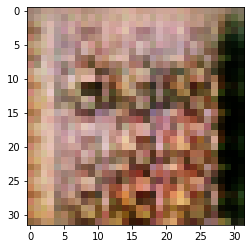

In [13]:
error_d_m2, error_g_m2, prediccion_falsa_m2 = entrenar(gan2, 3000, 150, "resultadosGAN-6/modelo2")

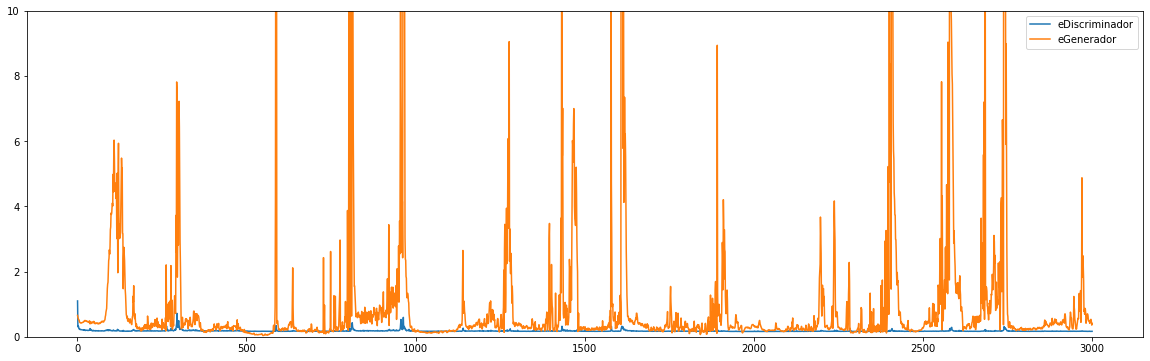

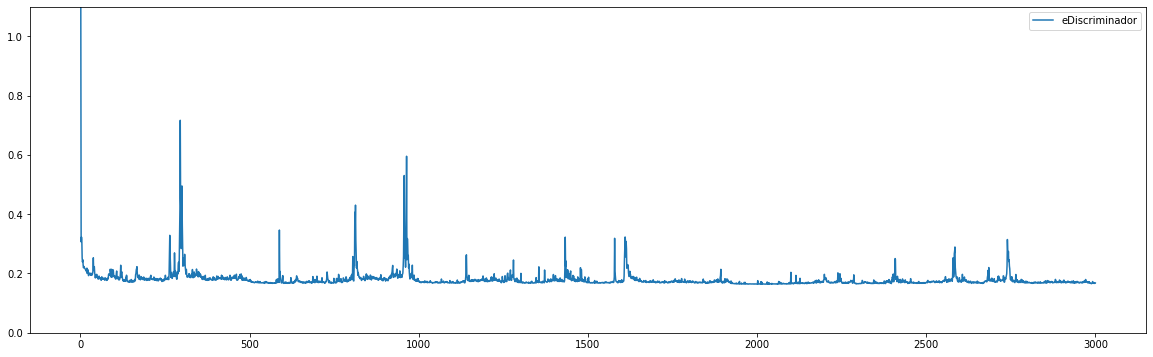

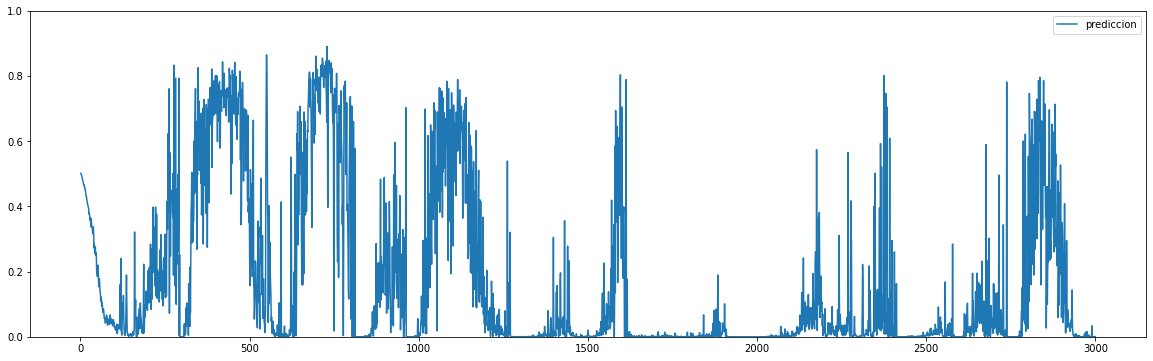

In [14]:
plot_acumulado(len(error_d_m2), 10, eDiscriminador = error_d_m2, eGenerador = error_g_m2)
plot_acumulado(len(error_d_m2), 1.1, eDiscriminador = error_d_m2)
plot_acumulado(len(prediccion_falsa_m2), 1, prediccion = prediccion_falsa_m2)

No hubo mejora con otro dataset

### Tercer modelo

dataset 2 con imagenes de 64x64

In [11]:
TAM_IMG = 64
x_train = cargar_datos("dataset2/data_tratada/")

print("")

OPTIMIZADOR3 = optimizador.Adam(learning_rate=0.0002, beta_1=0.5) 
ERROR3 = 'binary_crossentropy' 

gan3 = crear_GAN(OPTIMIZADOR3, ERROR3)

Creando set de entrenamiento...
¡Listo!

Generador Creado
Discriminador Creado
GAN Creado


Comenzando Epoca 1... Fin
Tiempo transcurrido:  10.68 s
Tiempo restante aprox: 533.75m -> 8:53h
prediccion de ruido:  [[0.49959236]]
Comenzando Epoca 2... Fin
Tiempo transcurrido:  8.75 s
Tiempo restante aprox: 437.32m -> 7:17h
prediccion de ruido:  [[0.4951073]]
Comenzando Epoca 3... Fin
Tiempo transcurrido:  8.78 s
Tiempo restante aprox: 438.47m -> 7:18h
prediccion de ruido:  [[0.48899835]]
Comenzando Epoca 4... Fin
Tiempo transcurrido:  8.79 s
Tiempo restante aprox: 438.96m -> 7:18h
prediccion de ruido:  [[0.48218864]]
Comenzando Epoca 5... Fin
Tiempo transcurrido:  8.71 s
Tiempo restante aprox: 434.79m -> 7:14h
prediccion de ruido:  [[0.47668475]]
Comenzando Epoca 6... Fin
Tiempo transcurrido:  9.04 s
Tiempo restante aprox: 451.13m -> 7:31h
prediccion de ruido:  [[0.46921358]]
Comenzando Epoca 7... Fin
Tiempo transcurrido:  8.79 s
Tiempo restante aprox: 438.46m -> 7:18h
prediccion de ruido:  [[0.46284238]]
Comenzando Epoca 8... Fin
Tiempo transcurrido:  9.22 s
Tiempo restante aprox

Comenzando Epoca 42... Fin
Tiempo transcurrido:  9.39 s
Tiempo restante aprox: 462.98m -> 7:42h
prediccion de ruido:  [[0.2514677]]
Comenzando Epoca 43... Fin
Tiempo transcurrido:  9.51 s
Tiempo restante aprox: 468.74m -> 7:48h
prediccion de ruido:  [[0.24295989]]
Comenzando Epoca 44... Fin
Tiempo transcurrido:  9.26 s
Tiempo restante aprox: 456.14m -> 7:36h
prediccion de ruido:  [[0.23783606]]
Comenzando Epoca 45... Fin
Tiempo transcurrido:  9.08 s
Tiempo restante aprox: 447.16m -> 7:27h
prediccion de ruido:  [[0.2273129]]
Comenzando Epoca 46... Fin
Tiempo transcurrido:  8.97 s
Tiempo restante aprox: 441.58m -> 7:21h
prediccion de ruido:  [[0.22734904]]
Comenzando Epoca 47... Fin
Tiempo transcurrido:  9.07 s
Tiempo restante aprox: 446.67m -> 7:26h
prediccion de ruido:  [[0.21538028]]
Comenzando Epoca 48... Fin
Tiempo transcurrido:  9.01 s
Tiempo restante aprox: 443.68m -> 7:23h
prediccion de ruido:  [[0.21166685]]
Comenzando Epoca 49... Fin
Tiempo transcurrido:  9.0 s
Tiempo restante 

Comenzando Epoca 83... Fin
Tiempo transcurrido:  8.96 s
Tiempo restante aprox: 435.86m -> 7:15h
prediccion de ruido:  [[0.0199804]]
Comenzando Epoca 84... Fin
Tiempo transcurrido:  8.69 s
Tiempo restante aprox: 422.53m -> 7:2h
prediccion de ruido:  [[0.01885796]]
Comenzando Epoca 85... Fin
Tiempo transcurrido:  8.85 s
Tiempo restante aprox: 430.05m -> 7:10h
prediccion de ruido:  [[0.02209461]]
Comenzando Epoca 86... Fin
Tiempo transcurrido:  8.85 s
Tiempo restante aprox: 429.81m -> 7:9h
prediccion de ruido:  [[0.01388323]]
Comenzando Epoca 87... Fin
Tiempo transcurrido:  8.89 s
Tiempo restante aprox: 431.8m -> 7:11h
prediccion de ruido:  [[0.01679468]]
Comenzando Epoca 88... Fin
Tiempo transcurrido:  8.81 s
Tiempo restante aprox: 427.59m -> 7:7h
prediccion de ruido:  [[0.01402372]]
Comenzando Epoca 89... Fin
Tiempo transcurrido:  8.81 s
Tiempo restante aprox: 427.8m -> 7:7h
prediccion de ruido:  [[0.0124349]]
Comenzando Epoca 90... Fin
Tiempo transcurrido:  8.71 s
Tiempo restante aprox

Comenzando Epoca 124... Fin
Tiempo transcurrido:  8.67 s
Tiempo restante aprox: 415.92m -> 6:55h
prediccion de ruido:  [[0.00118217]]
Comenzando Epoca 125... Fin
Tiempo transcurrido:  8.68 s
Tiempo restante aprox: 415.87m -> 6:55h
prediccion de ruido:  [[0.00106001]]
Comenzando Epoca 126... Fin
Tiempo transcurrido:  8.66 s
Tiempo restante aprox: 415.12m -> 6:55h
prediccion de ruido:  [[0.00107604]]
Comenzando Epoca 127... Fin
Tiempo transcurrido:  8.69 s
Tiempo restante aprox: 416.23m -> 6:56h
prediccion de ruido:  [[0.00107166]]
Comenzando Epoca 128... Fin
Tiempo transcurrido:  8.74 s
Tiempo restante aprox: 418.32m -> 6:58h
prediccion de ruido:  [[0.00083444]]
Comenzando Epoca 129... Fin
Tiempo transcurrido:  9.12 s
Tiempo restante aprox: 436.44m -> 7:16h
prediccion de ruido:  [[0.00087813]]
Comenzando Epoca 130... Fin
Tiempo transcurrido:  8.89 s
Tiempo restante aprox: 425.32m -> 7:5h
prediccion de ruido:  [[0.00092474]]
Comenzando Epoca 131... Fin
Tiempo transcurrido:  8.97 s
Tiempo

Comenzando Epoca 165... Fin
Tiempo transcurrido:  9.05 s
Tiempo restante aprox: 427.95m -> 7:7h
prediccion de ruido:  [[0.00017333]]
Comenzando Epoca 166... Fin
Tiempo transcurrido:  9.0 s
Tiempo restante aprox: 425.2m -> 7:5h
prediccion de ruido:  [[0.00018719]]
Comenzando Epoca 167... Fin
Tiempo transcurrido:  8.76 s
Tiempo restante aprox: 413.7m -> 6:53h
prediccion de ruido:  [[0.0001497]]
Comenzando Epoca 168... Fin
Tiempo transcurrido:  8.75 s
Tiempo restante aprox: 413.33m -> 6:53h
prediccion de ruido:  [[0.00020641]]
Comenzando Epoca 169... Fin
Tiempo transcurrido:  8.66 s
Tiempo restante aprox: 408.66m -> 6:48h
prediccion de ruido:  [[0.00013915]]
Comenzando Epoca 170... Fin
Tiempo transcurrido:  8.92 s
Tiempo restante aprox: 420.99m -> 7:0h
prediccion de ruido:  [[0.00027275]]
Comenzando Epoca 171... Fin
Tiempo transcurrido:  8.8 s
Tiempo restante aprox: 414.97m -> 6:54h
prediccion de ruido:  [[0.00012247]]
Comenzando Epoca 172... Fin
Tiempo transcurrido:  8.84 s
Tiempo restan

Comenzando Epoca 206... Fin
Tiempo transcurrido:  8.72 s
Tiempo restante aprox: 406.37m -> 6:46h
prediccion de ruido:  [[4.8104408e-05]]
Comenzando Epoca 207... Fin
Tiempo transcurrido:  8.75 s
Tiempo restante aprox: 407.53m -> 6:47h
prediccion de ruido:  [[5.2510724e-05]]
Comenzando Epoca 208... Fin
Tiempo transcurrido:  8.67 s
Tiempo restante aprox: 403.76m -> 6:43h
prediccion de ruido:  [[7.213796e-05]]
Comenzando Epoca 209... Fin
Tiempo transcurrido:  8.68 s
Tiempo restante aprox: 403.7m -> 6:43h
prediccion de ruido:  [[9.690021e-05]]
Comenzando Epoca 210... Fin
Tiempo transcurrido:  8.65 s
Tiempo restante aprox: 402.2m -> 6:42h
prediccion de ruido:  [[1.5996808e-05]]
Comenzando Epoca 211... Fin
Tiempo transcurrido:  8.67 s
Tiempo restante aprox: 403.32m -> 6:43h
prediccion de ruido:  [[7.6249244e-06]]
Comenzando Epoca 212... Fin
Tiempo transcurrido:  8.69 s
Tiempo restante aprox: 403.9m -> 6:43h
prediccion de ruido:  [[2.3412376e-05]]
Comenzando Epoca 213... Fin
Tiempo transcurrid

Comenzando Epoca 287... Fin
Tiempo transcurrido:  8.66 s
Tiempo restante aprox: 391.81m -> 6:31h
prediccion de ruido:  [[5.5720247e-05]]
Comenzando Epoca 288... Fin
Tiempo transcurrido:  8.68 s
Tiempo restante aprox: 392.42m -> 6:32h
prediccion de ruido:  [[1.5249639e-05]]
Comenzando Epoca 289... Fin
Tiempo transcurrido:  8.7 s
Tiempo restante aprox: 393.46m -> 6:33h
prediccion de ruido:  [[1.2402646e-05]]
Comenzando Epoca 290... Fin
Tiempo transcurrido:  8.73 s
Tiempo restante aprox: 394.29m -> 6:34h
prediccion de ruido:  [[9.213124e-07]]
Comenzando Epoca 291... Fin
Tiempo transcurrido:  8.65 s
Tiempo restante aprox: 390.62m -> 6:30h
prediccion de ruido:  [[3.6937893e-06]]
Comenzando Epoca 292... Fin
Tiempo transcurrido:  8.67 s
Tiempo restante aprox: 391.61m -> 6:31h
prediccion de ruido:  [[2.7531618e-05]]
Comenzando Epoca 293... Fin
Tiempo transcurrido:  8.67 s
Tiempo restante aprox: 391.47m -> 6:31h
prediccion de ruido:  [[3.55826e-06]]
Comenzando Epoca 294... Fin
Tiempo transcurri

Comenzando Epoca 328... Fin
Tiempo transcurrido:  8.79 s
Tiempo restante aprox: 391.81m -> 6:31h
prediccion de ruido:  [[0.00577673]]
Comenzando Epoca 329... Fin
Tiempo transcurrido:  8.72 s
Tiempo restante aprox: 388.55m -> 6:28h
prediccion de ruido:  [[0.01087108]]
Comenzando Epoca 330... Fin
Tiempo transcurrido:  8.75 s
Tiempo restante aprox: 389.47m -> 6:29h
prediccion de ruido:  [[0.00766423]]
Comenzando Epoca 331... Fin
Tiempo transcurrido:  8.72 s
Tiempo restante aprox: 387.99m -> 6:27h
prediccion de ruido:  [[0.00210923]]
Comenzando Epoca 332... Fin
Tiempo transcurrido:  8.8 s
Tiempo restante aprox: 391.31m -> 6:31h
prediccion de ruido:  [[0.00359046]]
Comenzando Epoca 333... Fin
Tiempo transcurrido:  8.75 s
Tiempo restante aprox: 388.94m -> 6:28h
prediccion de ruido:  [[0.00786269]]
Comenzando Epoca 334... Fin
Tiempo transcurrido:  8.72 s
Tiempo restante aprox: 387.73m -> 6:27h
prediccion de ruido:  [[0.0044125]]
Comenzando Epoca 335... Fin
Tiempo transcurrido:  8.72 s
Tiempo 

Comenzando Epoca 369... Fin
Tiempo transcurrido:  8.72 s
Tiempo restante aprox: 382.43m -> 6:22h
prediccion de ruido:  [[0.7068903]]
Comenzando Epoca 370... Fin
Tiempo transcurrido:  8.72 s
Tiempo restante aprox: 382.39m -> 6:22h
prediccion de ruido:  [[0.79526705]]
Comenzando Epoca 371... Fin
Tiempo transcurrido:  8.68 s
Tiempo restante aprox: 380.33m -> 6:20h
prediccion de ruido:  [[0.71943593]]
Comenzando Epoca 372... Fin
Tiempo transcurrido:  8.64 s
Tiempo restante aprox: 378.77m -> 6:18h
prediccion de ruido:  [[0.86960375]]
Comenzando Epoca 373... Fin
Tiempo transcurrido:  8.68 s
Tiempo restante aprox: 379.99m -> 6:19h
prediccion de ruido:  [[0.8689648]]
Comenzando Epoca 374... Fin
Tiempo transcurrido:  8.69 s
Tiempo restante aprox: 380.58m -> 6:20h
prediccion de ruido:  [[0.9527775]]
Comenzando Epoca 375... Fin
Tiempo transcurrido:  8.7 s
Tiempo restante aprox: 380.98m -> 6:20h
prediccion de ruido:  [[0.839667]]
Comenzando Epoca 376... Fin
Tiempo transcurrido:  8.67 s
Tiempo rest

Comenzando Epoca 410... Fin
Tiempo transcurrido:  8.74 s
Tiempo restante aprox: 377.25m -> 6:17h
prediccion de ruido:  [[4.9019556e-05]]
Comenzando Epoca 411... Fin
Tiempo transcurrido:  8.72 s
Tiempo restante aprox: 376.52m -> 6:16h
prediccion de ruido:  [[0.00480008]]
Comenzando Epoca 412... Fin
Tiempo transcurrido:  8.67 s
Tiempo restante aprox: 374.27m -> 6:14h
prediccion de ruido:  [[3.8737667e-07]]
Comenzando Epoca 413... Fin
Tiempo transcurrido:  8.67 s
Tiempo restante aprox: 374.12m -> 6:14h
prediccion de ruido:  [[2.7752547e-11]]
Comenzando Epoca 414... Fin
Tiempo transcurrido:  8.68 s
Tiempo restante aprox: 374.07m -> 6:14h
prediccion de ruido:  [[1.5914977e-12]]
Comenzando Epoca 415... Fin
Tiempo transcurrido:  8.67 s
Tiempo restante aprox: 373.83m -> 6:13h
prediccion de ruido:  [[1.1299551e-06]]
Comenzando Epoca 416... Fin
Tiempo transcurrido:  8.68 s
Tiempo restante aprox: 373.86m -> 6:13h
prediccion de ruido:  [[0.07782483]]
Comenzando Epoca 417... Fin
Tiempo transcurrido

Comenzando Epoca 451... Fin
Tiempo transcurrido:  8.64 s
Tiempo restante aprox: 367.3m -> 6:7h
prediccion de ruido:  [[3.3478027e-06]]
Comenzando Epoca 452... Fin
Tiempo transcurrido:  8.7 s
Tiempo restante aprox: 369.81m -> 6:9h
prediccion de ruido:  [[0.00284365]]
Comenzando Epoca 453... Fin
Tiempo transcurrido:  8.65 s
Tiempo restante aprox: 367.14m -> 6:7h
prediccion de ruido:  [[2.8017325e-06]]
Comenzando Epoca 454... Fin
Tiempo transcurrido:  8.63 s
Tiempo restante aprox: 366.21m -> 6:6h
prediccion de ruido:  [[0.00025916]]
Comenzando Epoca 455... Fin
Tiempo transcurrido:  8.67 s
Tiempo restante aprox: 368.05m -> 6:8h
prediccion de ruido:  [[0.00052714]]
Comenzando Epoca 456... Fin
Tiempo transcurrido:  8.67 s
Tiempo restante aprox: 367.91m -> 6:7h
prediccion de ruido:  [[0.00160336]]
Comenzando Epoca 457... Fin
Tiempo transcurrido:  8.67 s
Tiempo restante aprox: 367.76m -> 6:7h
prediccion de ruido:  [[0.00105274]]
Comenzando Epoca 458... Fin
Tiempo transcurrido:  8.63 s
Tiempo r

Comenzando Epoca 492... Fin
Tiempo transcurrido:  8.66 s
Tiempo restante aprox: 362.14m -> 6:2h
prediccion de ruido:  [[0.9998953]]
Comenzando Epoca 493... Fin
Tiempo transcurrido:  8.76 s
Tiempo restante aprox: 366.01m -> 6:6h
prediccion de ruido:  [[0.7180327]]
Comenzando Epoca 494... Fin
Tiempo transcurrido:  8.65 s
Tiempo restante aprox: 361.23m -> 6:1h
prediccion de ruido:  [[0.41000527]]
Comenzando Epoca 495... Fin
Tiempo transcurrido:  8.72 s
Tiempo restante aprox: 364.22m -> 6:4h
prediccion de ruido:  [[0.93231165]]
Comenzando Epoca 496... Fin
Tiempo transcurrido:  8.66 s
Tiempo restante aprox: 361.47m -> 6:1h
prediccion de ruido:  [[0.07441553]]
Comenzando Epoca 497... Fin
Tiempo transcurrido:  8.66 s
Tiempo restante aprox: 361.33m -> 6:1h
prediccion de ruido:  [[0.03792751]]
Comenzando Epoca 498... Fin
Tiempo transcurrido:  8.7 s
Tiempo restante aprox: 363.14m -> 6:3h
prediccion de ruido:  [[0.9596063]]
Comenzando Epoca 499... Fin
Tiempo transcurrido:  8.66 s
Tiempo restante 

Comenzando Epoca 533... Fin
Tiempo transcurrido:  8.71 s
Tiempo restante aprox: 358.12m -> 5:58h
prediccion de ruido:  [[0.79730594]]
Comenzando Epoca 534... Fin
Tiempo transcurrido:  8.69 s
Tiempo restante aprox: 357.27m -> 5:57h
prediccion de ruido:  [[0.715901]]
Comenzando Epoca 535... Fin
Tiempo transcurrido:  8.8 s
Tiempo restante aprox: 361.87m -> 6:1h
prediccion de ruido:  [[0.5696546]]
Comenzando Epoca 536... Fin
Tiempo transcurrido:  8.72 s
Tiempo restante aprox: 358.39m -> 5:58h
prediccion de ruido:  [[0.5466354]]
Comenzando Epoca 537... Fin
Tiempo transcurrido:  8.73 s
Tiempo restante aprox: 358.65m -> 5:58h
prediccion de ruido:  [[0.53464794]]
Comenzando Epoca 538... Fin
Tiempo transcurrido:  8.74 s
Tiempo restante aprox: 358.62m -> 5:58h
prediccion de ruido:  [[0.5066673]]
Comenzando Epoca 539... Fin
Tiempo transcurrido:  8.71 s
Tiempo restante aprox: 357.29m -> 5:57h
prediccion de ruido:  [[0.5411258]]
Comenzando Epoca 540... Fin
Tiempo transcurrido:  8.74 s
Tiempo restan

Comenzando Epoca 574... Fin
Tiempo transcurrido:  8.74 s
Tiempo restante aprox: 353.54m -> 5:53h
prediccion de ruido:  [[0.25626153]]
Comenzando Epoca 575... Fin
Tiempo transcurrido:  8.72 s
Tiempo restante aprox: 352.6m -> 5:52h
prediccion de ruido:  [[0.52061516]]
Comenzando Epoca 576... Fin
Tiempo transcurrido:  8.81 s
Tiempo restante aprox: 355.99m -> 5:55h
prediccion de ruido:  [[0.23383728]]
Comenzando Epoca 577... Fin
Tiempo transcurrido:  8.71 s
Tiempo restante aprox: 351.98m -> 5:51h
prediccion de ruido:  [[0.43935087]]
Comenzando Epoca 578... Fin
Tiempo transcurrido:  8.71 s
Tiempo restante aprox: 351.62m -> 5:51h
prediccion de ruido:  [[0.67044663]]
Comenzando Epoca 579... Fin
Tiempo transcurrido:  8.68 s
Tiempo restante aprox: 350.33m -> 5:50h
prediccion de ruido:  [[0.42613304]]
Comenzando Epoca 580... Fin
Tiempo transcurrido:  8.74 s
Tiempo restante aprox: 352.5m -> 5:52h
prediccion de ruido:  [[0.5061505]]
Comenzando Epoca 581... Fin
Tiempo transcurrido:  8.76 s
Tiempo r

Comenzando Epoca 615... Fin
Tiempo transcurrido:  8.74 s
Tiempo restante aprox: 347.44m -> 5:47h
prediccion de ruido:  [[0.66276854]]
Comenzando Epoca 616... Fin
Tiempo transcurrido:  8.71 s
Tiempo restante aprox: 346.14m -> 5:46h
prediccion de ruido:  [[0.6164272]]
Comenzando Epoca 617... Fin
Tiempo transcurrido:  8.76 s
Tiempo restante aprox: 347.97m -> 5:47h
prediccion de ruido:  [[0.59196687]]
Comenzando Epoca 618... Fin
Tiempo transcurrido:  8.71 s
Tiempo restante aprox: 345.81m -> 5:45h
prediccion de ruido:  [[0.1646545]]
Comenzando Epoca 619... Fin
Tiempo transcurrido:  8.71 s
Tiempo restante aprox: 345.7m -> 5:45h
prediccion de ruido:  [[0.37724912]]
Comenzando Epoca 620... Fin
Tiempo transcurrido:  8.72 s
Tiempo restante aprox: 346.23m -> 5:46h
prediccion de ruido:  [[0.48757258]]
Comenzando Epoca 621... Fin
Tiempo transcurrido:  8.73 s
Tiempo restante aprox: 346.43m -> 5:46h
prediccion de ruido:  [[0.2646898]]
Comenzando Epoca 622... Fin
Tiempo transcurrido:  8.7 s
Tiempo res

Comenzando Epoca 656... Fin
Tiempo transcurrido:  8.76 s
Tiempo restante aprox: 342.2m -> 5:42h
prediccion de ruido:  [[0.53856355]]
Comenzando Epoca 657... Fin
Tiempo transcurrido:  8.72 s
Tiempo restante aprox: 340.72m -> 5:40h
prediccion de ruido:  [[0.4748136]]
Comenzando Epoca 658... Fin
Tiempo transcurrido:  8.77 s
Tiempo restante aprox: 342.4m -> 5:42h
prediccion de ruido:  [[0.463209]]
Comenzando Epoca 659... Fin
Tiempo transcurrido:  8.77 s
Tiempo restante aprox: 342.21m -> 5:42h
prediccion de ruido:  [[0.13548666]]
Comenzando Epoca 660... Fin
Tiempo transcurrido:  8.71 s
Tiempo restante aprox: 339.94m -> 5:39h
prediccion de ruido:  [[0.3844851]]
Comenzando Epoca 661... Fin
Tiempo transcurrido:  8.73 s
Tiempo restante aprox: 340.33m -> 5:40h
prediccion de ruido:  [[0.32125804]]
Comenzando Epoca 662... Fin
Tiempo transcurrido:  8.72 s
Tiempo restante aprox: 339.95m -> 5:39h
prediccion de ruido:  [[0.08362731]]
Comenzando Epoca 663... Fin
Tiempo transcurrido:  8.77 s
Tiempo rest

Comenzando Epoca 697... Fin
Tiempo transcurrido:  8.72 s
Tiempo restante aprox: 334.86m -> 5:34h
prediccion de ruido:  [[0.7555528]]
Comenzando Epoca 698... Fin
Tiempo transcurrido:  8.72 s
Tiempo restante aprox: 334.72m -> 5:34h
prediccion de ruido:  [[0.8171568]]
Comenzando Epoca 699... Fin
Tiempo transcurrido:  8.72 s
Tiempo restante aprox: 334.55m -> 5:34h
prediccion de ruido:  [[0.91423094]]
Comenzando Epoca 700... Fin
Tiempo transcurrido:  8.91 s
Tiempo restante aprox: 341.7m -> 5:41h
prediccion de ruido:  [[0.8556432]]
Comenzando Epoca 701... Fin
Tiempo transcurrido:  8.67 s
Tiempo restante aprox: 332.49m -> 5:32h
prediccion de ruido:  [[0.7986958]]
Comenzando Epoca 702... Fin
Tiempo transcurrido:  8.72 s
Tiempo restante aprox: 334.14m -> 5:34h
prediccion de ruido:  [[0.9044808]]
Comenzando Epoca 703... Fin
Tiempo transcurrido:  8.71 s
Tiempo restante aprox: 333.51m -> 5:33h
prediccion de ruido:  [[0.94164497]]
Comenzando Epoca 704... Fin
Tiempo transcurrido:  8.74 s
Tiempo rest

Comenzando Epoca 738... Fin
Tiempo transcurrido:  8.74 s
Tiempo restante aprox: 329.49m -> 5:29h
prediccion de ruido:  [[0.8153183]]
Comenzando Epoca 739... Fin
Tiempo transcurrido:  8.74 s
Tiempo restante aprox: 329.35m -> 5:29h
prediccion de ruido:  [[0.85262316]]
Comenzando Epoca 740... Fin
Tiempo transcurrido:  8.72 s
Tiempo restante aprox: 328.49m -> 5:28h
prediccion de ruido:  [[0.78765893]]
Comenzando Epoca 741... Fin
Tiempo transcurrido:  8.81 s
Tiempo restante aprox: 331.84m -> 5:31h
prediccion de ruido:  [[0.76047665]]
Comenzando Epoca 742... Fin
Tiempo transcurrido:  8.85 s
Tiempo restante aprox: 333.02m -> 5:33h
prediccion de ruido:  [[0.788143]]
Comenzando Epoca 743... Fin
Tiempo transcurrido:  8.74 s
Tiempo restante aprox: 328.95m -> 5:28h
prediccion de ruido:  [[0.8016446]]
Comenzando Epoca 744... Fin
Tiempo transcurrido:  8.71 s
Tiempo restante aprox: 327.75m -> 5:27h
prediccion de ruido:  [[0.7097097]]
Comenzando Epoca 745... Fin
Tiempo transcurrido:  8.7 s
Tiempo rest

Comenzando Epoca 779... Fin
Tiempo transcurrido:  8.72 s
Tiempo restante aprox: 322.96m -> 5:22h
prediccion de ruido:  [[0.99799776]]
Comenzando Epoca 780... Fin
Tiempo transcurrido:  8.74 s
Tiempo restante aprox: 323.47m -> 5:23h
prediccion de ruido:  [[0.9907315]]
Comenzando Epoca 781... Fin
Tiempo transcurrido:  8.74 s
Tiempo restante aprox: 323.25m -> 5:23h
prediccion de ruido:  [[0.96184]]
Comenzando Epoca 782... Fin
Tiempo transcurrido:  8.79 s
Tiempo restante aprox: 324.91m -> 5:24h
prediccion de ruido:  [[0.9999863]]
Comenzando Epoca 783... Fin
Tiempo transcurrido:  8.72 s
Tiempo restante aprox: 322.38m -> 5:22h
prediccion de ruido:  [[0.9995073]]
Comenzando Epoca 784... Fin
Tiempo transcurrido:  8.72 s
Tiempo restante aprox: 322.08m -> 5:22h
prediccion de ruido:  [[0.98596025]]
Comenzando Epoca 785... Fin
Tiempo transcurrido:  8.74 s
Tiempo restante aprox: 322.67m -> 5:22h
prediccion de ruido:  [[0.53013176]]
Comenzando Epoca 786... Fin
Tiempo transcurrido:  8.71 s
Tiempo rest

Comenzando Epoca 820... Fin
Tiempo transcurrido:  8.78 s
Tiempo restante aprox: 319.26m -> 5:19h
prediccion de ruido:  [[0.34006608]]
Comenzando Epoca 821... Fin
Tiempo transcurrido:  8.71 s
Tiempo restante aprox: 316.57m -> 5:16h
prediccion de ruido:  [[0.9172096]]
Comenzando Epoca 822... Fin
Tiempo transcurrido:  8.72 s
Tiempo restante aprox: 316.7m -> 5:16h
prediccion de ruido:  [[0.9756466]]
Comenzando Epoca 823... Fin
Tiempo transcurrido:  8.79 s
Tiempo restante aprox: 318.91m -> 5:18h
prediccion de ruido:  [[0.69697636]]
Comenzando Epoca 824... Fin
Tiempo transcurrido:  8.74 s
Tiempo restante aprox: 317.01m -> 5:17h
prediccion de ruido:  [[0.97185266]]
Comenzando Epoca 825... Fin
Tiempo transcurrido:  8.72 s
Tiempo restante aprox: 316.27m -> 5:16h
prediccion de ruido:  [[0.90735525]]
Comenzando Epoca 826... Fin
Tiempo transcurrido:  8.72 s
Tiempo restante aprox: 316.12m -> 5:16h
prediccion de ruido:  [[0.6042559]]
Comenzando Epoca 827... Fin
Tiempo transcurrido:  8.77 s
Tiempo re

Comenzando Epoca 861... Fin
Tiempo transcurrido:  8.95 s
Tiempo restante aprox: 319.15m -> 5:19h
prediccion de ruido:  [[0.41963214]]
Comenzando Epoca 862... Fin
Tiempo transcurrido:  8.78 s
Tiempo restante aprox: 312.83m -> 5:12h
prediccion de ruido:  [[0.7847874]]
Comenzando Epoca 863... Fin
Tiempo transcurrido:  8.68 s
Tiempo restante aprox: 309.18m -> 5:9h
prediccion de ruido:  [[0.47632372]]
Comenzando Epoca 864... Fin
Tiempo transcurrido:  8.74 s
Tiempo restante aprox: 311.45m -> 5:11h
prediccion de ruido:  [[0.54555225]]
Comenzando Epoca 865... Fin
Tiempo transcurrido:  8.74 s
Tiempo restante aprox: 311.04m -> 5:11h
prediccion de ruido:  [[0.87731326]]
Comenzando Epoca 866... Fin
Tiempo transcurrido:  8.7 s
Tiempo restante aprox: 309.75m -> 5:9h
prediccion de ruido:  [[0.7222285]]
Comenzando Epoca 867... Fin
Tiempo transcurrido:  8.75 s
Tiempo restante aprox: 311.05m -> 5:11h
prediccion de ruido:  [[0.9085355]]
Comenzando Epoca 868... Fin
Tiempo transcurrido:  8.76 s
Tiempo rest

Comenzando Epoca 902... Fin
Tiempo transcurrido:  8.71 s
Tiempo restante aprox: 304.63m -> 5:4h
prediccion de ruido:  [[0.1719926]]
Comenzando Epoca 903... Fin
Tiempo transcurrido:  8.75 s
Tiempo restante aprox: 306.12m -> 5:6h
prediccion de ruido:  [[0.420869]]
Comenzando Epoca 904... Fin
Tiempo transcurrido:  8.71 s
Tiempo restante aprox: 304.27m -> 5:4h
prediccion de ruido:  [[0.1663647]]
Comenzando Epoca 905... Fin
Tiempo transcurrido:  8.72 s
Tiempo restante aprox: 304.74m -> 5:4h
prediccion de ruido:  [[0.12552962]]
Comenzando Epoca 906... Fin
Tiempo transcurrido:  8.74 s
Tiempo restante aprox: 305.28m -> 5:5h
prediccion de ruido:  [[0.53594965]]
Comenzando Epoca 907... Fin
Tiempo transcurrido:  8.7 s
Tiempo restante aprox: 303.8m -> 5:3h
prediccion de ruido:  [[0.61584747]]
Comenzando Epoca 908... Fin
Tiempo transcurrido:  8.72 s
Tiempo restante aprox: 304.2m -> 5:4h
prediccion de ruido:  [[0.35667515]]
Comenzando Epoca 909... Fin
Tiempo transcurrido:  8.75 s
Tiempo restante apr

Comenzando Epoca 943... Fin
Tiempo transcurrido:  8.75 s
Tiempo restante aprox: 300.18m -> 5:0h
prediccion de ruido:  [[0.03442669]]
Comenzando Epoca 944... Fin
Tiempo transcurrido:  8.71 s
Tiempo restante aprox: 298.57m -> 4:58h
prediccion de ruido:  [[0.03983361]]
Comenzando Epoca 945... Fin
Tiempo transcurrido:  8.72 s
Tiempo restante aprox: 298.94m -> 4:58h
prediccion de ruido:  [[0.00991815]]
Comenzando Epoca 946... Fin
Tiempo transcurrido:  8.69 s
Tiempo restante aprox: 297.71m -> 4:57h
prediccion de ruido:  [[0.04282245]]
Comenzando Epoca 947... Fin
Tiempo transcurrido:  8.8 s
Tiempo restante aprox: 301.34m -> 5:1h
prediccion de ruido:  [[0.02268556]]
Comenzando Epoca 948... Fin
Tiempo transcurrido:  8.69 s
Tiempo restante aprox: 297.32m -> 4:57h
prediccion de ruido:  [[0.05039752]]
Comenzando Epoca 949... Fin
Tiempo transcurrido:  8.71 s
Tiempo restante aprox: 297.77m -> 4:57h
prediccion de ruido:  [[0.03885436]]
Comenzando Epoca 950... Fin
Tiempo transcurrido:  8.72 s
Tiempo r

Comenzando Epoca 984... Fin
Tiempo transcurrido:  8.75 s
Tiempo restante aprox: 294.2m -> 4:54h
prediccion de ruido:  [[0.02403131]]
Comenzando Epoca 985... Fin
Tiempo transcurrido:  8.72 s
Tiempo restante aprox: 293.01m -> 4:53h
prediccion de ruido:  [[0.14713135]]
Comenzando Epoca 986... Fin
Tiempo transcurrido:  8.74 s
Tiempo restante aprox: 293.48m -> 4:53h
prediccion de ruido:  [[0.08222735]]
Comenzando Epoca 987... Fin
Tiempo transcurrido:  8.69 s
Tiempo restante aprox: 291.65m -> 4:51h
prediccion de ruido:  [[0.02398768]]
Comenzando Epoca 988... Fin
Tiempo transcurrido:  8.81 s
Tiempo restante aprox: 295.71m -> 4:55h
prediccion de ruido:  [[0.04115608]]
Comenzando Epoca 989... Fin
Tiempo transcurrido:  8.7 s
Tiempo restante aprox: 291.9m -> 4:51h
prediccion de ruido:  [[0.03463432]]
Comenzando Epoca 990... Fin
Tiempo transcurrido:  8.75 s
Tiempo restante aprox: 293.39m -> 4:53h
prediccion de ruido:  [[0.2477603]]
Comenzando Epoca 991... Fin
Tiempo transcurrido:  8.72 s
Tiempo re

Comenzando Epoca 1025... Fin
Tiempo transcurrido:  8.74 s
Tiempo restante aprox: 287.71m -> 4:47h
prediccion de ruido:  [[0.27645618]]
Comenzando Epoca 1026... Fin
Tiempo transcurrido:  8.71 s
Tiempo restante aprox: 286.73m -> 4:46h
prediccion de ruido:  [[0.05015039]]
Comenzando Epoca 1027... Fin
Tiempo transcurrido:  8.75 s
Tiempo restante aprox: 287.93m -> 4:47h
prediccion de ruido:  [[0.21562162]]
Comenzando Epoca 1028... Fin
Tiempo transcurrido:  8.74 s
Tiempo restante aprox: 287.27m -> 4:47h
prediccion de ruido:  [[0.09223831]]
Comenzando Epoca 1029... Fin
Tiempo transcurrido:  8.78 s
Tiempo restante aprox: 288.62m -> 4:48h
prediccion de ruido:  [[0.25265396]]
Comenzando Epoca 1030... Fin
Tiempo transcurrido:  8.72 s
Tiempo restante aprox: 286.47m -> 4:46h
prediccion de ruido:  [[0.1928325]]
Comenzando Epoca 1031... Fin
Tiempo transcurrido:  8.74 s
Tiempo restante aprox: 286.9m -> 4:46h
prediccion de ruido:  [[0.21194261]]
Comenzando Epoca 1032... Fin
Tiempo transcurrido:  8.75 s

Comenzando Epoca 1066... Fin
Tiempo transcurrido:  8.7 s
Tiempo restante aprox: 280.73m -> 4:40h
prediccion de ruido:  [[0.0321027]]
Comenzando Epoca 1067... Fin
Tiempo transcurrido:  8.7 s
Tiempo restante aprox: 280.58m -> 4:40h
prediccion de ruido:  [[0.11364359]]
Comenzando Epoca 1068... Fin
Tiempo transcurrido:  8.99 s
Tiempo restante aprox: 289.74m -> 4:49h
prediccion de ruido:  [[0.03319883]]
Comenzando Epoca 1069... Fin
Tiempo transcurrido:  8.71 s
Tiempo restante aprox: 280.46m -> 4:40h
prediccion de ruido:  [[0.07051843]]
Comenzando Epoca 1070... Fin
Tiempo transcurrido:  8.75 s
Tiempo restante aprox: 281.53m -> 4:41h
prediccion de ruido:  [[0.04629606]]
Comenzando Epoca 1071... Fin
Tiempo transcurrido:  8.69 s
Tiempo restante aprox: 279.57m -> 4:39h
prediccion de ruido:  [[0.0372237]]
Comenzando Epoca 1072... Fin
Tiempo transcurrido:  8.71 s
Tiempo restante aprox: 280.02m -> 4:40h
prediccion de ruido:  [[0.07626641]]
Comenzando Epoca 1073... Fin
Tiempo transcurrido:  8.72 s
T

Comenzando Epoca 1107... Fin
Tiempo transcurrido:  8.77 s
Tiempo restante aprox: 276.75m -> 4:36h
prediccion de ruido:  [[0.09896618]]
Comenzando Epoca 1108... Fin
Tiempo transcurrido:  8.71 s
Tiempo restante aprox: 274.89m -> 4:34h
prediccion de ruido:  [[0.00570348]]
Comenzando Epoca 1109... Fin
Tiempo transcurrido:  8.71 s
Tiempo restante aprox: 274.59m -> 4:34h
prediccion de ruido:  [[0.04513034]]
Comenzando Epoca 1110... Fin
Tiempo transcurrido:  8.72 s
Tiempo restante aprox: 274.93m -> 4:34h
prediccion de ruido:  [[0.63376385]]
Comenzando Epoca 1111... Fin
Tiempo transcurrido:  8.74 s
Tiempo restante aprox: 275.3m -> 4:35h
prediccion de ruido:  [[0.10811612]]
Comenzando Epoca 1112... Fin
Tiempo transcurrido:  8.78 s
Tiempo restante aprox: 276.51m -> 4:36h
prediccion de ruido:  [[0.14566493]]
Comenzando Epoca 1113... Fin
Tiempo transcurrido:  8.73 s
Tiempo restante aprox: 274.56m -> 4:34h
prediccion de ruido:  [[0.01196045]]
Comenzando Epoca 1114... Fin
Tiempo transcurrido:  8.73 

Comenzando Epoca 1148... Fin
Tiempo transcurrido:  8.77 s
Tiempo restante aprox: 270.76m -> 4:30h
prediccion de ruido:  [[0.03404537]]
Comenzando Epoca 1149... Fin
Tiempo transcurrido:  8.7 s
Tiempo restante aprox: 268.64m -> 4:28h
prediccion de ruido:  [[0.00950494]]
Comenzando Epoca 1150... Fin
Tiempo transcurrido:  8.69 s
Tiempo restante aprox: 268.06m -> 4:28h
prediccion de ruido:  [[0.01744655]]
Comenzando Epoca 1151... Fin
Tiempo transcurrido:  8.75 s
Tiempo restante aprox: 269.87m -> 4:29h
prediccion de ruido:  [[0.00860116]]
Comenzando Epoca 1152... Fin
Tiempo transcurrido:  8.74 s
Tiempo restante aprox: 269.21m -> 4:29h
prediccion de ruido:  [[0.01213458]]
Comenzando Epoca 1153... Fin
Tiempo transcurrido:  8.77 s
Tiempo restante aprox: 270.12m -> 4:30h
prediccion de ruido:  [[0.00788814]]
Comenzando Epoca 1154... Fin
Tiempo transcurrido:  8.73 s
Tiempo restante aprox: 268.66m -> 4:28h
prediccion de ruido:  [[0.00421208]]
Comenzando Epoca 1155... Fin
Tiempo transcurrido:  8.7 s

Comenzando Epoca 1189... Fin
Tiempo transcurrido:  8.71 s
Tiempo restante aprox: 263.01m -> 4:23h
prediccion de ruido:  [[0.06467351]]
Comenzando Epoca 1190... Fin
Tiempo transcurrido:  8.69 s
Tiempo restante aprox: 262.3m -> 4:22h
prediccion de ruido:  [[0.08547822]]
Comenzando Epoca 1191... Fin
Tiempo transcurrido:  8.71 s
Tiempo restante aprox: 262.69m -> 4:22h
prediccion de ruido:  [[0.00258893]]
Comenzando Epoca 1192... Fin
Tiempo transcurrido:  8.71 s
Tiempo restante aprox: 262.54m -> 4:22h
prediccion de ruido:  [[0.01675451]]
Comenzando Epoca 1193... Fin
Tiempo transcurrido:  8.71 s
Tiempo restante aprox: 262.58m -> 4:22h
prediccion de ruido:  [[0.23091814]]
Comenzando Epoca 1194... Fin
Tiempo transcurrido:  8.78 s
Tiempo restante aprox: 264.51m -> 4:24h
prediccion de ruido:  [[0.14132726]]
Comenzando Epoca 1195... Fin
Tiempo transcurrido:  8.76 s
Tiempo restante aprox: 263.63m -> 4:23h
prediccion de ruido:  [[0.0365417]]
Comenzando Epoca 1196... Fin
Tiempo transcurrido:  8.74 s

Comenzando Epoca 1230... Fin
Tiempo transcurrido:  8.74 s
Tiempo restante aprox: 257.95m -> 4:17h
prediccion de ruido:  [[0.28522438]]
Comenzando Epoca 1231... Fin
Tiempo transcurrido:  8.7 s
Tiempo restante aprox: 256.79m -> 4:16h
prediccion de ruido:  [[0.5710612]]
Comenzando Epoca 1232... Fin
Tiempo transcurrido:  8.76 s
Tiempo restante aprox: 258.17m -> 4:18h
prediccion de ruido:  [[0.2191107]]
Comenzando Epoca 1233... Fin
Tiempo transcurrido:  8.74 s
Tiempo restante aprox: 257.63m -> 4:17h
prediccion de ruido:  [[0.85588604]]
Comenzando Epoca 1234... Fin
Tiempo transcurrido:  8.77 s
Tiempo restante aprox: 258.19m -> 4:18h
prediccion de ruido:  [[0.44195056]]
Comenzando Epoca 1235... Fin
Tiempo transcurrido:  8.78 s
Tiempo restante aprox: 258.54m -> 4:18h
prediccion de ruido:  [[0.08870843]]
Comenzando Epoca 1236... Fin
Tiempo transcurrido:  8.72 s
Tiempo restante aprox: 256.53m -> 4:16h
prediccion de ruido:  [[0.08151361]]
Comenzando Epoca 1237... Fin
Tiempo transcurrido:  8.75 s


Comenzando Epoca 1271... Fin
Tiempo transcurrido:  8.71 s
Tiempo restante aprox: 251.11m -> 4:11h
prediccion de ruido:  [[0.34608823]]
Comenzando Epoca 1272... Fin
Tiempo transcurrido:  8.75 s
Tiempo restante aprox: 252.26m -> 4:12h
prediccion de ruido:  [[0.5479643]]
Comenzando Epoca 1273... Fin
Tiempo transcurrido:  8.73 s
Tiempo restante aprox: 251.36m -> 4:11h
prediccion de ruido:  [[0.3980306]]
Comenzando Epoca 1274... Fin
Tiempo transcurrido:  8.72 s
Tiempo restante aprox: 251.11m -> 4:11h
prediccion de ruido:  [[0.61260545]]
Comenzando Epoca 1275... Fin
Tiempo transcurrido:  8.97 s
Tiempo restante aprox: 258.13m -> 4:18h
prediccion de ruido:  [[0.4259647]]
Comenzando Epoca 1276... Fin
Tiempo transcurrido:  8.81 s
Tiempo restante aprox: 253.42m -> 4:13h
prediccion de ruido:  [[0.61350316]]
Comenzando Epoca 1277... Fin
Tiempo transcurrido:  8.74 s
Tiempo restante aprox: 251.18m -> 4:11h
prediccion de ruido:  [[0.6283584]]
Comenzando Epoca 1278... Fin
Tiempo transcurrido:  8.74 s
T

Comenzando Epoca 1312... Fin
Tiempo transcurrido:  8.71 s
Tiempo restante aprox: 245.13m -> 4:5h
prediccion de ruido:  [[0.6933025]]
Comenzando Epoca 1313... Fin
Tiempo transcurrido:  8.74 s
Tiempo restante aprox: 245.78m -> 4:5h
prediccion de ruido:  [[0.6955861]]
Comenzando Epoca 1314... Fin
Tiempo transcurrido:  8.7 s
Tiempo restante aprox: 244.75m -> 4:4h
prediccion de ruido:  [[0.6419436]]
Comenzando Epoca 1315... Fin
Tiempo transcurrido:  8.72 s
Tiempo restante aprox: 245.13m -> 4:5h
prediccion de ruido:  [[0.6821668]]
Comenzando Epoca 1316... Fin
Tiempo transcurrido:  8.7 s
Tiempo restante aprox: 244.46m -> 4:4h
prediccion de ruido:  [[0.73187757]]
Comenzando Epoca 1317... Fin
Tiempo transcurrido:  8.75 s
Tiempo restante aprox: 245.72m -> 4:5h
prediccion de ruido:  [[0.69594854]]
Comenzando Epoca 1318... Fin
Tiempo transcurrido:  8.84 s
Tiempo restante aprox: 247.83m -> 4:7h
prediccion de ruido:  [[0.6331293]]
Comenzando Epoca 1319... Fin
Tiempo transcurrido:  8.71 s
Tiempo rest

Comenzando Epoca 1353... Fin
Tiempo transcurrido:  8.75 s
Tiempo restante aprox: 240.38m -> 4:0h
prediccion de ruido:  [[0.70731306]]
Comenzando Epoca 1354... Fin
Tiempo transcurrido:  8.75 s
Tiempo restante aprox: 240.23m -> 4:0h
prediccion de ruido:  [[0.52405834]]
Comenzando Epoca 1355... Fin
Tiempo transcurrido:  8.69 s
Tiempo restante aprox: 238.4m -> 3:58h
prediccion de ruido:  [[0.63353944]]
Comenzando Epoca 1356... Fin
Tiempo transcurrido:  8.7 s
Tiempo restante aprox: 238.66m -> 3:58h
prediccion de ruido:  [[0.61289847]]
Comenzando Epoca 1357... Fin
Tiempo transcurrido:  8.75 s
Tiempo restante aprox: 239.8m -> 3:59h
prediccion de ruido:  [[0.5220349]]
Comenzando Epoca 1358... Fin
Tiempo transcurrido:  8.7 s
Tiempo restante aprox: 238.37m -> 3:58h
prediccion de ruido:  [[0.5214544]]
Comenzando Epoca 1359... Fin
Tiempo transcurrido:  8.82 s
Tiempo restante aprox: 241.44m -> 4:1h
prediccion de ruido:  [[0.6299298]]
Comenzando Epoca 1360... Fin
Tiempo transcurrido:  8.69 s
Tiempo 

Comenzando Epoca 1394... Fin
Tiempo transcurrido:  8.69 s
Tiempo restante aprox: 232.73m -> 3:52h
prediccion de ruido:  [[0.79324573]]
Comenzando Epoca 1395... Fin
Tiempo transcurrido:  8.75 s
Tiempo restante aprox: 234.33m -> 3:54h
prediccion de ruido:  [[0.63497835]]
Comenzando Epoca 1396... Fin
Tiempo transcurrido:  8.74 s
Tiempo restante aprox: 233.69m -> 3:53h
prediccion de ruido:  [[0.6256058]]
Comenzando Epoca 1397... Fin
Tiempo transcurrido:  8.74 s
Tiempo restante aprox: 233.54m -> 3:53h
prediccion de ruido:  [[0.697874]]
Comenzando Epoca 1398... Fin
Tiempo transcurrido:  8.72 s
Tiempo restante aprox: 233.01m -> 3:53h
prediccion de ruido:  [[0.6806512]]
Comenzando Epoca 1399... Fin
Tiempo transcurrido:  8.72 s
Tiempo restante aprox: 232.86m -> 3:52h
prediccion de ruido:  [[0.6208469]]
Comenzando Epoca 1400... Fin
Tiempo transcurrido:  8.95 s
Tiempo restante aprox: 238.93m -> 3:58h
prediccion de ruido:  [[0.5336417]]
Comenzando Epoca 1401... Fin
Tiempo transcurrido:  8.74 s
Tie

Comenzando Epoca 1435... Fin
Tiempo transcurrido:  8.72 s
Tiempo restante aprox: 227.68m -> 3:47h
prediccion de ruido:  [[0.09330317]]
Comenzando Epoca 1436... Fin
Tiempo transcurrido:  8.72 s
Tiempo restante aprox: 227.46m -> 3:47h
prediccion de ruido:  [[0.19805592]]
Comenzando Epoca 1437... Fin
Tiempo transcurrido:  8.7 s
Tiempo restante aprox: 226.91m -> 3:46h
prediccion de ruido:  [[0.21221232]]
Comenzando Epoca 1438... Fin
Tiempo transcurrido:  8.7 s
Tiempo restante aprox: 226.76m -> 3:46h
prediccion de ruido:  [[0.07195589]]
Comenzando Epoca 1439... Fin
Tiempo transcurrido:  8.76 s
Tiempo restante aprox: 228.15m -> 3:48h
prediccion de ruido:  [[0.11176765]]
Comenzando Epoca 1440... Fin
Tiempo transcurrido:  8.73 s
Tiempo restante aprox: 227.0m -> 3:47h
prediccion de ruido:  [[0.21071073]]
Comenzando Epoca 1441... Fin
Tiempo transcurrido:  8.77 s
Tiempo restante aprox: 228.03m -> 3:48h
prediccion de ruido:  [[0.09260982]]
Comenzando Epoca 1442... Fin
Tiempo transcurrido:  8.74 s


Comenzando Epoca 1476... Fin
Tiempo transcurrido:  8.74 s
Tiempo restante aprox: 222.07m -> 3:42h
prediccion de ruido:  [[0.0633828]]
Comenzando Epoca 1477... Fin
Tiempo transcurrido:  8.68 s
Tiempo restante aprox: 220.39m -> 3:40h
prediccion de ruido:  [[0.07486683]]
Comenzando Epoca 1478... Fin
Tiempo transcurrido:  8.7 s
Tiempo restante aprox: 220.96m -> 3:40h
prediccion de ruido:  [[0.16520149]]
Comenzando Epoca 1479... Fin
Tiempo transcurrido:  8.69 s
Tiempo restante aprox: 220.42m -> 3:40h
prediccion de ruido:  [[0.6154099]]
Comenzando Epoca 1480... Fin
Tiempo transcurrido:  8.76 s
Tiempo restante aprox: 222.01m -> 3:42h
prediccion de ruido:  [[0.5751996]]
Comenzando Epoca 1481... Fin
Tiempo transcurrido:  8.69 s
Tiempo restante aprox: 220.13m -> 3:40h
prediccion de ruido:  [[0.25075597]]
Comenzando Epoca 1482... Fin
Tiempo transcurrido:  8.94 s
Tiempo restante aprox: 226.22m -> 3:46h
prediccion de ruido:  [[0.265916]]
Comenzando Epoca 1483... Fin
Tiempo transcurrido:  8.82 s
Tie

Comenzando Epoca 1517... Fin
Tiempo transcurrido:  8.69 s
Tiempo restante aprox: 214.91m -> 3:34h
prediccion de ruido:  [[0.05321652]]
Comenzando Epoca 1518... Fin
Tiempo transcurrido:  8.72 s
Tiempo restante aprox: 215.61m -> 3:35h
prediccion de ruido:  [[0.06641731]]
Comenzando Epoca 1519... Fin
Tiempo transcurrido:  8.71 s
Tiempo restante aprox: 215.03m -> 3:35h
prediccion de ruido:  [[0.08337733]]
Comenzando Epoca 1520... Fin
Tiempo transcurrido:  8.69 s
Tiempo restante aprox: 214.53m -> 3:34h
prediccion de ruido:  [[0.04721034]]
Comenzando Epoca 1521... Fin
Tiempo transcurrido:  8.75 s
Tiempo restante aprox: 215.9m -> 3:35h
prediccion de ruido:  [[0.08091518]]
Comenzando Epoca 1522... Fin
Tiempo transcurrido:  8.72 s
Tiempo restante aprox: 214.96m -> 3:34h
prediccion de ruido:  [[0.3212815]]
Comenzando Epoca 1523... Fin
Tiempo transcurrido:  8.69 s
Tiempo restante aprox: 214.04m -> 3:34h
prediccion de ruido:  [[0.32102597]]
Comenzando Epoca 1524... Fin
Tiempo transcurrido:  8.77 s

Comenzando Epoca 1558... Fin
Tiempo transcurrido:  8.7 s
Tiempo restante aprox: 209.35m -> 3:29h
prediccion de ruido:  [[0.2022498]]
Comenzando Epoca 1559... Fin
Tiempo transcurrido:  8.75 s
Tiempo restante aprox: 210.38m -> 3:30h
prediccion de ruido:  [[0.27649885]]
Comenzando Epoca 1560... Fin
Tiempo transcurrido:  8.74 s
Tiempo restante aprox: 209.81m -> 3:29h
prediccion de ruido:  [[0.28352958]]
Comenzando Epoca 1561... Fin
Tiempo transcurrido:  8.69 s
Tiempo restante aprox: 208.6m -> 3:28h
prediccion de ruido:  [[0.22450405]]
Comenzando Epoca 1562... Fin
Tiempo transcurrido:  8.7 s
Tiempo restante aprox: 208.77m -> 3:28h
prediccion de ruido:  [[0.22327277]]
Comenzando Epoca 1563... Fin
Tiempo transcurrido:  8.71 s
Tiempo restante aprox: 208.77m -> 3:28h
prediccion de ruido:  [[0.08521834]]
Comenzando Epoca 1564... Fin
Tiempo transcurrido:  8.71 s
Tiempo restante aprox: 208.65m -> 3:28h
prediccion de ruido:  [[0.31236023]]
Comenzando Epoca 1565... Fin
Tiempo transcurrido:  8.82 s
T

Comenzando Epoca 1599... Fin
Tiempo transcurrido:  8.74 s
Tiempo restante aprox: 204.13m -> 3:24h
prediccion de ruido:  [[3.8986127e-05]]
Comenzando Epoca 1600... Fin
Tiempo transcurrido:  8.94 s
Tiempo restante aprox: 208.79m -> 3:28h
prediccion de ruido:  [[7.858803e-05]]
Comenzando Epoca 1601... Fin
Tiempo transcurrido:  8.72 s
Tiempo restante aprox: 203.37m -> 3:23h
prediccion de ruido:  [[0.00355649]]
Comenzando Epoca 1602... Fin
Tiempo transcurrido:  8.72 s
Tiempo restante aprox: 203.33m -> 3:23h
prediccion de ruido:  [[0.0008145]]
Comenzando Epoca 1603... Fin
Tiempo transcurrido:  8.7 s
Tiempo restante aprox: 202.82m -> 3:22h
prediccion de ruido:  [[0.00096515]]
Comenzando Epoca 1604... Fin
Tiempo transcurrido:  8.69 s
Tiempo restante aprox: 202.38m -> 3:22h
prediccion de ruido:  [[0.0002107]]
Comenzando Epoca 1605... Fin
Tiempo transcurrido:  8.77 s
Tiempo restante aprox: 204.12m -> 3:24h
prediccion de ruido:  [[0.00161505]]
Comenzando Epoca 1606... Fin
Tiempo transcurrido:  8.

Comenzando Epoca 1640... Fin
Tiempo transcurrido:  8.75 s
Tiempo restante aprox: 198.56m -> 3:18h
prediccion de ruido:  [[0.2059356]]
Comenzando Epoca 1641... Fin
Tiempo transcurrido:  8.74 s
Tiempo restante aprox: 198.02m -> 3:18h
prediccion de ruido:  [[0.11909685]]
Comenzando Epoca 1642... Fin
Tiempo transcurrido:  8.74 s
Tiempo restante aprox: 197.89m -> 3:17h
prediccion de ruido:  [[0.3545919]]
Comenzando Epoca 1643... Fin
Tiempo transcurrido:  8.71 s
Tiempo restante aprox: 197.2m -> 3:17h
prediccion de ruido:  [[0.31607786]]
Comenzando Epoca 1644... Fin
Tiempo transcurrido:  8.71 s
Tiempo restante aprox: 197.01m -> 3:17h
prediccion de ruido:  [[0.41696668]]
Comenzando Epoca 1645... Fin
Tiempo transcurrido:  8.72 s
Tiempo restante aprox: 197.08m -> 3:17h
prediccion de ruido:  [[0.26750994]]
Comenzando Epoca 1646... Fin
Tiempo transcurrido:  8.74 s
Tiempo restante aprox: 197.29m -> 3:17h
prediccion de ruido:  [[0.49662977]]
Comenzando Epoca 1647... Fin
Tiempo transcurrido:  8.77 s


Comenzando Epoca 1681... Fin
Tiempo transcurrido:  8.71 s
Tiempo restante aprox: 191.59m -> 3:11h
prediccion de ruido:  [[0.02268511]]
Comenzando Epoca 1682... Fin
Tiempo transcurrido:  8.74 s
Tiempo restante aprox: 192.09m -> 3:12h
prediccion de ruido:  [[0.02041468]]
Comenzando Epoca 1683... Fin
Tiempo transcurrido:  8.7 s
Tiempo restante aprox: 191.22m -> 3:11h
prediccion de ruido:  [[0.08977333]]
Comenzando Epoca 1684... Fin
Tiempo transcurrido:  8.74 s
Tiempo restante aprox: 191.91m -> 3:11h
prediccion de ruido:  [[0.0525009]]
Comenzando Epoca 1685... Fin
Tiempo transcurrido:  8.71 s
Tiempo restante aprox: 191.09m -> 3:11h
prediccion de ruido:  [[0.0110932]]
Comenzando Epoca 1686... Fin
Tiempo transcurrido:  8.72 s
Tiempo restante aprox: 191.12m -> 3:11h
prediccion de ruido:  [[0.00296953]]
Comenzando Epoca 1687... Fin
Tiempo transcurrido:  8.75 s
Tiempo restante aprox: 191.66m -> 3:11h
prediccion de ruido:  [[0.05048054]]
Comenzando Epoca 1688... Fin
Tiempo transcurrido:  8.73 s


Comenzando Epoca 1722... Fin
Tiempo transcurrido:  8.71 s
Tiempo restante aprox: 185.58m -> 3:5h
prediccion de ruido:  [[0.00234276]]
Comenzando Epoca 1723... Fin
Tiempo transcurrido:  8.74 s
Tiempo restante aprox: 186.21m -> 3:6h
prediccion de ruido:  [[0.00516969]]
Comenzando Epoca 1724... Fin
Tiempo transcurrido:  8.76 s
Tiempo restante aprox: 186.35m -> 3:6h
prediccion de ruido:  [[0.06761605]]
Comenzando Epoca 1725... Fin
Tiempo transcurrido:  8.72 s
Tiempo restante aprox: 185.48m -> 3:5h
prediccion de ruido:  [[0.00485316]]
Comenzando Epoca 1726... Fin
Tiempo transcurrido:  8.72 s
Tiempo restante aprox: 185.23m -> 3:5h
prediccion de ruido:  [[0.00211808]]
Comenzando Epoca 1727... Fin
Tiempo transcurrido:  8.68 s
Tiempo restante aprox: 184.26m -> 3:4h
prediccion de ruido:  [[0.01303267]]
Comenzando Epoca 1728... Fin
Tiempo transcurrido:  8.72 s
Tiempo restante aprox: 185.04m -> 3:5h
prediccion de ruido:  [[0.0377312]]
Comenzando Epoca 1729... Fin
Tiempo transcurrido:  8.75 s
Tiemp

Comenzando Epoca 1763... Fin
Tiempo transcurrido:  8.77 s
Tiempo restante aprox: 180.93m -> 3:0h
prediccion de ruido:  [[0.21781403]]
Comenzando Epoca 1764... Fin
Tiempo transcurrido:  8.69 s
Tiempo restante aprox: 179.2m -> 2:59h
prediccion de ruido:  [[0.1405074]]
Comenzando Epoca 1765... Fin
Tiempo transcurrido:  8.74 s
Tiempo restante aprox: 179.97m -> 2:59h
prediccion de ruido:  [[0.05958563]]
Comenzando Epoca 1766... Fin
Tiempo transcurrido:  8.77 s
Tiempo restante aprox: 180.53m -> 3:0h
prediccion de ruido:  [[0.17576882]]
Comenzando Epoca 1767... Fin
Tiempo transcurrido:  8.74 s
Tiempo restante aprox: 179.68m -> 2:59h
prediccion de ruido:  [[0.4289367]]
Comenzando Epoca 1768... Fin
Tiempo transcurrido:  8.72 s
Tiempo restante aprox: 179.27m -> 2:59h
prediccion de ruido:  [[0.4109253]]
Comenzando Epoca 1769... Fin
Tiempo transcurrido:  8.71 s
Tiempo restante aprox: 178.75m -> 2:58h
prediccion de ruido:  [[0.24972442]]
Comenzando Epoca 1770... Fin
Tiempo transcurrido:  8.75 s
Tie

Comenzando Epoca 1804... Fin
Tiempo transcurrido:  8.72 s
Tiempo restante aprox: 173.98m -> 2:53h
prediccion de ruido:  [[0.5695162]]
Comenzando Epoca 1805... Fin
Tiempo transcurrido:  8.72 s
Tiempo restante aprox: 173.89m -> 2:53h
prediccion de ruido:  [[0.52615124]]
Comenzando Epoca 1806... Fin
Tiempo transcurrido:  8.74 s
Tiempo restante aprox: 174.09m -> 2:54h
prediccion de ruido:  [[0.55601865]]
Comenzando Epoca 1807... Fin
Tiempo transcurrido:  8.72 s
Tiempo restante aprox: 173.6m -> 2:53h
prediccion de ruido:  [[0.49711606]]
Comenzando Epoca 1808... Fin
Tiempo transcurrido:  8.76 s
Tiempo restante aprox: 174.09m -> 2:54h
prediccion de ruido:  [[0.49826738]]
Comenzando Epoca 1809... Fin
Tiempo transcurrido:  8.74 s
Tiempo restante aprox: 173.58m -> 2:53h
prediccion de ruido:  [[0.3837302]]
Comenzando Epoca 1810... Fin
Tiempo transcurrido:  8.72 s
Tiempo restante aprox: 173.1m -> 2:53h
prediccion de ruido:  [[0.86701214]]
Comenzando Epoca 1811... Fin
Tiempo transcurrido:  8.72 s
T

Comenzando Epoca 1845... Fin
Tiempo transcurrido:  8.72 s
Tiempo restante aprox: 168.03m -> 2:48h
prediccion de ruido:  [[0.4437438]]
Comenzando Epoca 1846... Fin
Tiempo transcurrido:  8.74 s
Tiempo restante aprox: 168.17m -> 2:48h
prediccion de ruido:  [[0.5924615]]
Comenzando Epoca 1847... Fin
Tiempo transcurrido:  8.72 s
Tiempo restante aprox: 167.72m -> 2:47h
prediccion de ruido:  [[0.37431556]]
Comenzando Epoca 1848... Fin
Tiempo transcurrido:  8.74 s
Tiempo restante aprox: 167.9m -> 2:47h
prediccion de ruido:  [[0.6999593]]
Comenzando Epoca 1849... Fin
Tiempo transcurrido:  8.74 s
Tiempo restante aprox: 167.77m -> 2:47h
prediccion de ruido:  [[0.7807693]]
Comenzando Epoca 1850... Fin
Tiempo transcurrido:  8.72 s
Tiempo restante aprox: 167.29m -> 2:47h
prediccion de ruido:  [[0.3681787]]
Comenzando Epoca 1851... Fin
Tiempo transcurrido:  8.71 s
Tiempo restante aprox: 166.92m -> 2:46h
prediccion de ruido:  [[0.45927697]]
Comenzando Epoca 1852... Fin
Tiempo transcurrido:  8.7 s
Tiem

Comenzando Epoca 1886... Fin
Tiempo transcurrido:  8.74 s
Tiempo restante aprox: 162.34m -> 2:42h
prediccion de ruido:  [[0.43729746]]
Comenzando Epoca 1887... Fin
Tiempo transcurrido:  8.73 s
Tiempo restante aprox: 162.04m -> 2:42h
prediccion de ruido:  [[0.5036018]]
Comenzando Epoca 1888... Fin
Tiempo transcurrido:  8.71 s
Tiempo restante aprox: 161.49m -> 2:41h
prediccion de ruido:  [[0.776164]]
Comenzando Epoca 1889... Fin
Tiempo transcurrido:  8.74 s
Tiempo restante aprox: 161.93m -> 2:41h
prediccion de ruido:  [[0.39995897]]
Comenzando Epoca 1890... Fin
Tiempo transcurrido:  8.73 s
Tiempo restante aprox: 161.57m -> 2:41h
prediccion de ruido:  [[0.7131426]]
Comenzando Epoca 1891... Fin
Tiempo transcurrido:  8.71 s
Tiempo restante aprox: 161.09m -> 2:41h
prediccion de ruido:  [[0.4274181]]
Comenzando Epoca 1892... Fin
Tiempo transcurrido:  8.7 s
Tiempo restante aprox: 160.89m -> 2:40h
prediccion de ruido:  [[0.61076355]]
Comenzando Epoca 1893... Fin
Tiempo transcurrido:  8.7 s
Tiem

Comenzando Epoca 1927... Fin
Tiempo transcurrido:  8.76 s
Tiempo restante aprox: 156.8m -> 2:36h
prediccion de ruido:  [[0.48384303]]
Comenzando Epoca 1928... Fin
Tiempo transcurrido:  8.72 s
Tiempo restante aprox: 155.95m -> 2:35h
prediccion de ruido:  [[0.63633025]]
Comenzando Epoca 1929... Fin
Tiempo transcurrido:  8.7 s
Tiempo restante aprox: 155.48m -> 2:35h
prediccion de ruido:  [[0.35727477]]
Comenzando Epoca 1930... Fin
Tiempo transcurrido:  8.74 s
Tiempo restante aprox: 156.04m -> 2:36h
prediccion de ruido:  [[0.59965575]]
Comenzando Epoca 1931... Fin
Tiempo transcurrido:  8.75 s
Tiempo restante aprox: 156.1m -> 2:36h
prediccion de ruido:  [[0.2708279]]
Comenzando Epoca 1932... Fin
Tiempo transcurrido:  8.72 s
Tiempo restante aprox: 155.42m -> 2:35h
prediccion de ruido:  [[0.5087837]]
Comenzando Epoca 1933... Fin
Tiempo transcurrido:  8.74 s
Tiempo restante aprox: 155.59m -> 2:35h
prediccion de ruido:  [[0.7545389]]
Comenzando Epoca 1934... Fin
Tiempo transcurrido:  8.73 s
Tie

Comenzando Epoca 1968... Fin
Tiempo transcurrido:  8.72 s
Tiempo restante aprox: 150.14m -> 2:30h
prediccion de ruido:  [[0.05023396]]
Comenzando Epoca 1969... Fin
Tiempo transcurrido:  8.78 s
Tiempo restante aprox: 151.06m -> 2:31h
prediccion de ruido:  [[0.26956427]]
Comenzando Epoca 1970... Fin
Tiempo transcurrido:  8.69 s
Tiempo restante aprox: 149.39m -> 2:29h
prediccion de ruido:  [[0.05641401]]
Comenzando Epoca 1971... Fin
Tiempo transcurrido:  8.74 s
Tiempo restante aprox: 149.97m -> 2:29h
prediccion de ruido:  [[0.11120328]]
Comenzando Epoca 1972... Fin
Tiempo transcurrido:  8.74 s
Tiempo restante aprox: 149.87m -> 2:29h
prediccion de ruido:  [[0.09495682]]
Comenzando Epoca 1973... Fin
Tiempo transcurrido:  8.7 s
Tiempo restante aprox: 149.14m -> 2:29h
prediccion de ruido:  [[0.03427979]]
Comenzando Epoca 1974... Fin
Tiempo transcurrido:  8.7 s
Tiempo restante aprox: 148.87m -> 2:28h
prediccion de ruido:  [[0.00651824]]
Comenzando Epoca 1975... Fin
Tiempo transcurrido:  8.77 s

Comenzando Epoca 2009... Fin
Tiempo transcurrido:  8.7 s
Tiempo restante aprox: 143.92m -> 2:23h
prediccion de ruido:  [[0.3839961]]
Comenzando Epoca 2010... Fin
Tiempo transcurrido:  8.75 s
Tiempo restante aprox: 144.55m -> 2:24h
prediccion de ruido:  [[0.29984075]]
Comenzando Epoca 2011... Fin
Tiempo transcurrido:  8.69 s
Tiempo restante aprox: 143.37m -> 2:23h
prediccion de ruido:  [[0.31271142]]
Comenzando Epoca 2012... Fin
Tiempo transcurrido:  8.72 s
Tiempo restante aprox: 143.74m -> 2:23h
prediccion de ruido:  [[0.44443366]]
Comenzando Epoca 2013... Fin
Tiempo transcurrido:  8.72 s
Tiempo restante aprox: 143.61m -> 2:23h
prediccion de ruido:  [[0.5165892]]
Comenzando Epoca 2014... Fin
Tiempo transcurrido:  8.71 s
Tiempo restante aprox: 143.26m -> 2:23h
prediccion de ruido:  [[0.2949418]]
Comenzando Epoca 2015... Fin
Tiempo transcurrido:  8.76 s
Tiempo restante aprox: 143.92m -> 2:23h
prediccion de ruido:  [[0.13131368]]
Comenzando Epoca 2016... Fin
Tiempo transcurrido:  8.71 s
T

Comenzando Epoca 2050... Fin
Tiempo transcurrido:  8.74 s
Tiempo restante aprox: 138.47m -> 2:18h
prediccion de ruido:  [[0.15187588]]
Comenzando Epoca 2051... Fin
Tiempo transcurrido:  8.75 s
Tiempo restante aprox: 138.6m -> 2:18h
prediccion de ruido:  [[0.17228603]]
Comenzando Epoca 2052... Fin
Tiempo transcurrido:  8.7 s
Tiempo restante aprox: 137.68m -> 2:17h
prediccion de ruido:  [[0.04473937]]
Comenzando Epoca 2053... Fin
Tiempo transcurrido:  8.69 s
Tiempo restante aprox: 137.29m -> 2:17h
prediccion de ruido:  [[0.04389086]]
Comenzando Epoca 2054... Fin
Tiempo transcurrido:  8.77 s
Tiempo restante aprox: 138.44m -> 2:18h
prediccion de ruido:  [[0.03287563]]
Comenzando Epoca 2055... Fin
Tiempo transcurrido:  8.72 s
Tiempo restante aprox: 137.52m -> 2:17h
prediccion de ruido:  [[0.3106029]]
Comenzando Epoca 2056... Fin
Tiempo transcurrido:  8.72 s
Tiempo restante aprox: 137.39m -> 2:17h
prediccion de ruido:  [[0.05945745]]
Comenzando Epoca 2057... Fin
Tiempo transcurrido:  8.72 s


Comenzando Epoca 2091... Fin
Tiempo transcurrido:  8.7 s
Tiempo restante aprox: 131.97m -> 2:11h
prediccion de ruido:  [[0.37729523]]
Comenzando Epoca 2092... Fin
Tiempo transcurrido:  8.69 s
Tiempo restante aprox: 131.64m -> 2:11h
prediccion de ruido:  [[0.83336747]]
Comenzando Epoca 2093... Fin
Tiempo transcurrido:  8.74 s
Tiempo restante aprox: 132.2m -> 2:12h
prediccion de ruido:  [[0.3497119]]
Comenzando Epoca 2094... Fin
Tiempo transcurrido:  8.75 s
Tiempo restante aprox: 132.34m -> 2:12h
prediccion de ruido:  [[0.07829627]]
Comenzando Epoca 2095... Fin
Tiempo transcurrido:  8.7 s
Tiempo restante aprox: 131.44m -> 2:11h
prediccion de ruido:  [[0.17395282]]
Comenzando Epoca 2096... Fin
Tiempo transcurrido:  8.69 s
Tiempo restante aprox: 131.06m -> 2:11h
prediccion de ruido:  [[0.2229709]]
Comenzando Epoca 2097... Fin
Tiempo transcurrido:  8.73 s
Tiempo restante aprox: 131.46m -> 2:11h
prediccion de ruido:  [[0.00774366]]
Comenzando Epoca 2098... Fin
Tiempo transcurrido:  8.69 s
Ti

Comenzando Epoca 2132... Fin
Tiempo transcurrido:  8.71 s
Tiempo restante aprox: 126.15m -> 2:6h
prediccion de ruido:  [[6.0290313e-05]]
Comenzando Epoca 2133... Fin
Tiempo transcurrido:  8.72 s
Tiempo restante aprox: 126.16m -> 2:6h
prediccion de ruido:  [[5.5414053e-05]]
Comenzando Epoca 2134... Fin
Tiempo transcurrido:  8.74 s
Tiempo restante aprox: 126.28m -> 2:6h
prediccion de ruido:  [[0.00116932]]
Comenzando Epoca 2135... Fin
Tiempo transcurrido:  8.68 s
Tiempo restante aprox: 125.35m -> 2:5h
prediccion de ruido:  [[0.00178042]]
Comenzando Epoca 2136... Fin
Tiempo transcurrido:  8.72 s
Tiempo restante aprox: 125.72m -> 2:5h
prediccion de ruido:  [[1.5595306e-05]]
Comenzando Epoca 2137... Fin
Tiempo transcurrido:  8.72 s
Tiempo restante aprox: 125.57m -> 2:5h
prediccion de ruido:  [[0.00014782]]
Comenzando Epoca 2138... Fin
Tiempo transcurrido:  8.72 s
Tiempo restante aprox: 125.43m -> 2:5h
prediccion de ruido:  [[0.00039393]]
Comenzando Epoca 2139... Fin
Tiempo transcurrido:  8.

Comenzando Epoca 2173... Fin
Tiempo transcurrido:  8.67 s
Tiempo restante aprox: 119.65m -> 1:59h
prediccion de ruido:  [[0.28246784]]
Comenzando Epoca 2174... Fin
Tiempo transcurrido:  8.74 s
Tiempo restante aprox: 120.41m -> 2:0h
prediccion de ruido:  [[0.18934089]]
Comenzando Epoca 2175... Fin
Tiempo transcurrido:  8.75 s
Tiempo restante aprox: 120.49m -> 2:0h
prediccion de ruido:  [[0.3708399]]
Comenzando Epoca 2176... Fin
Tiempo transcurrido:  8.71 s
Tiempo restante aprox: 119.78m -> 1:59h
prediccion de ruido:  [[0.08652908]]
Comenzando Epoca 2177... Fin
Tiempo transcurrido:  8.74 s
Tiempo restante aprox: 120.0m -> 2:0h
prediccion de ruido:  [[0.60774994]]
Comenzando Epoca 2178... Fin
Tiempo transcurrido:  8.71 s
Tiempo restante aprox: 119.43m -> 1:59h
prediccion de ruido:  [[0.3410167]]
Comenzando Epoca 2179... Fin
Tiempo transcurrido:  8.78 s
Tiempo restante aprox: 120.26m -> 2:0h
prediccion de ruido:  [[0.13208225]]
Comenzando Epoca 2180... Fin
Tiempo transcurrido:  8.69 s
Tiem

Comenzando Epoca 2214... Fin
Tiempo transcurrido:  8.74 s
Tiempo restante aprox: 114.59m -> 1:54h
prediccion de ruido:  [[0.09375101]]
Comenzando Epoca 2215... Fin
Tiempo transcurrido:  8.69 s
Tiempo restante aprox: 113.87m -> 1:53h
prediccion de ruido:  [[0.3688451]]
Comenzando Epoca 2216... Fin
Tiempo transcurrido:  8.73 s
Tiempo restante aprox: 114.2m -> 1:54h
prediccion de ruido:  [[0.6335984]]
Comenzando Epoca 2217... Fin
Tiempo transcurrido:  8.71 s
Tiempo restante aprox: 113.75m -> 1:53h
prediccion de ruido:  [[0.2905201]]
Comenzando Epoca 2218... Fin
Tiempo transcurrido:  8.69 s
Tiempo restante aprox: 113.4m -> 1:53h
prediccion de ruido:  [[0.3911971]]
Comenzando Epoca 2219... Fin
Tiempo transcurrido:  8.71 s
Tiempo restante aprox: 113.46m -> 1:53h
prediccion de ruido:  [[0.46765077]]
Comenzando Epoca 2220... Fin
Tiempo transcurrido:  8.74 s
Tiempo restante aprox: 113.72m -> 1:53h
prediccion de ruido:  [[0.27207714]]
Comenzando Epoca 2221... Fin
Tiempo transcurrido:  8.71 s
Tie

Comenzando Epoca 2255... Fin
Tiempo transcurrido:  8.74 s
Tiempo restante aprox: 108.66m -> 1:48h
prediccion de ruido:  [[0.48779696]]
Comenzando Epoca 2256... Fin
Tiempo transcurrido:  8.74 s
Tiempo restante aprox: 108.52m -> 1:48h
prediccion de ruido:  [[0.51892227]]
Comenzando Epoca 2257... Fin
Tiempo transcurrido:  8.71 s
Tiempo restante aprox: 108.05m -> 1:48h
prediccion de ruido:  [[0.2855854]]
Comenzando Epoca 2258... Fin
Tiempo transcurrido:  8.74 s
Tiempo restante aprox: 108.22m -> 1:48h
prediccion de ruido:  [[0.62611854]]
Comenzando Epoca 2259... Fin
Tiempo transcurrido:  8.74 s
Tiempo restante aprox: 108.06m -> 1:48h
prediccion de ruido:  [[0.34399462]]
Comenzando Epoca 2260... Fin
Tiempo transcurrido:  8.72 s
Tiempo restante aprox: 107.71m -> 1:47h
prediccion de ruido:  [[0.39238787]]
Comenzando Epoca 2261... Fin
Tiempo transcurrido:  8.73 s
Tiempo restante aprox: 107.65m -> 1:47h
prediccion de ruido:  [[0.47609288]]
Comenzando Epoca 2262... Fin
Tiempo transcurrido:  8.73 

Comenzando Epoca 2296... Fin
Tiempo transcurrido:  8.75 s
Tiempo restante aprox: 102.87m -> 1:42h
prediccion de ruido:  [[0.11604181]]
Comenzando Epoca 2297... Fin
Tiempo transcurrido:  8.79 s
Tiempo restante aprox: 103.09m -> 1:43h
prediccion de ruido:  [[0.1143446]]
Comenzando Epoca 2298... Fin
Tiempo transcurrido:  8.72 s
Tiempo restante aprox: 102.21m -> 1:42h
prediccion de ruido:  [[0.5209968]]
Comenzando Epoca 2299... Fin
Tiempo transcurrido:  8.7 s
Tiempo restante aprox: 101.85m -> 1:41h
prediccion de ruido:  [[0.3193745]]
Comenzando Epoca 2300... Fin
Tiempo transcurrido:  8.97 s
Tiempo restante aprox: 104.8m -> 1:44h
prediccion de ruido:  [[0.14447811]]
Comenzando Epoca 2301... Fin
Tiempo transcurrido:  8.69 s
Tiempo restante aprox: 101.39m -> 1:41h
prediccion de ruido:  [[0.28242967]]
Comenzando Epoca 2302... Fin
Tiempo transcurrido:  8.74 s
Tiempo restante aprox: 101.87m -> 1:41h
prediccion de ruido:  [[0.13915908]]
Comenzando Epoca 2303... Fin
Tiempo transcurrido:  8.72 s
Ti

Comenzando Epoca 2337... Fin
Tiempo transcurrido:  8.72 s
Tiempo restante aprox: 96.55m -> 1:36h
prediccion de ruido:  [[0.04412803]]
Comenzando Epoca 2338... Fin
Tiempo transcurrido:  8.76 s
Tiempo restante aprox: 96.75m -> 1:36h
prediccion de ruido:  [[0.03971359]]
Comenzando Epoca 2339... Fin
Tiempo transcurrido:  8.68 s
Tiempo restante aprox: 95.73m -> 1:35h
prediccion de ruido:  [[0.00205666]]
Comenzando Epoca 2340... Fin
Tiempo transcurrido:  8.7 s
Tiempo restante aprox: 95.84m -> 1:35h
prediccion de ruido:  [[0.00633043]]
Comenzando Epoca 2341... Fin
Tiempo transcurrido:  8.7 s
Tiempo restante aprox: 95.75m -> 1:35h
prediccion de ruido:  [[0.00597864]]
Comenzando Epoca 2342... Fin
Tiempo transcurrido:  8.72 s
Tiempo restante aprox: 95.79m -> 1:35h
prediccion de ruido:  [[0.00428823]]
Comenzando Epoca 2343... Fin
Tiempo transcurrido:  8.75 s
Tiempo restante aprox: 95.98m -> 1:35h
prediccion de ruido:  [[0.06840518]]
Comenzando Epoca 2344... Fin
Tiempo transcurrido:  8.7 s
Tiempo 

Comenzando Epoca 2378... Fin
Tiempo transcurrido:  8.74 s
Tiempo restante aprox: 90.71m -> 1:30h
prediccion de ruido:  [[2.4829562e-05]]
Comenzando Epoca 2379... Fin
Tiempo transcurrido:  8.92 s
Tiempo restante aprox: 92.43m -> 1:32h
prediccion de ruido:  [[0.00017357]]
Comenzando Epoca 2380... Fin
Tiempo transcurrido:  8.77 s
Tiempo restante aprox: 90.74m -> 1:30h
prediccion de ruido:  [[5.7418918e-05]]
Comenzando Epoca 2381... Fin
Tiempo transcurrido:  8.7 s
Tiempo restante aprox: 89.94m -> 1:29h
prediccion de ruido:  [[1.4471482e-05]]
Comenzando Epoca 2382... Fin
Tiempo transcurrido:  8.7 s
Tiempo restante aprox: 89.8m -> 1:29h
prediccion de ruido:  [[5.9384023e-05]]
Comenzando Epoca 2383... Fin
Tiempo transcurrido:  8.71 s
Tiempo restante aprox: 89.73m -> 1:29h
prediccion de ruido:  [[2.6826683e-05]]
Comenzando Epoca 2384... Fin
Tiempo transcurrido:  8.73 s
Tiempo restante aprox: 89.73m -> 1:29h
prediccion de ruido:  [[5.1764428e-06]]
Comenzando Epoca 2385... Fin
Tiempo transcurrid

Comenzando Epoca 2419... Fin
Tiempo transcurrido:  8.71 s
Tiempo restante aprox: 84.48m -> 1:24h
prediccion de ruido:  [[1.5900456e-18]]
Comenzando Epoca 2420... Fin
Tiempo transcurrido:  8.72 s
Tiempo restante aprox: 84.45m -> 1:24h
prediccion de ruido:  [[2.089377e-15]]
Comenzando Epoca 2421... Fin
Tiempo transcurrido:  8.73 s
Tiempo restante aprox: 84.42m -> 1:24h
prediccion de ruido:  [[8.0722425e-17]]
Comenzando Epoca 2422... Fin
Tiempo transcurrido:  8.71 s
Tiempo restante aprox: 84.04m -> 1:24h
prediccion de ruido:  [[5.730023e-12]]
Comenzando Epoca 2423... Fin
Tiempo transcurrido:  8.74 s
Tiempo restante aprox: 84.18m -> 1:24h
prediccion de ruido:  [[2.8982621e-12]]
Comenzando Epoca 2424... Fin
Tiempo transcurrido:  8.75 s
Tiempo restante aprox: 84.19m -> 1:24h
prediccion de ruido:  [[2.5167047e-12]]
Comenzando Epoca 2425... Fin
Tiempo transcurrido:  8.74 s
Tiempo restante aprox: 83.88m -> 1:23h
prediccion de ruido:  [[3.5990633e-12]]
Comenzando Epoca 2426... Fin
Tiempo transcu

Comenzando Epoca 2500... Fin
Tiempo transcurrido:  8.94 s
Tiempo restante aprox: 74.64m -> 1:14h
prediccion de ruido:  [[0.00866011]]
Comenzando Epoca 2501... Fin
Tiempo transcurrido:  8.71 s
Tiempo restante aprox: 72.57m -> 1:12h
prediccion de ruido:  [[0.0134722]]
Comenzando Epoca 2502... Fin
Tiempo transcurrido:  8.71 s
Tiempo restante aprox: 72.43m -> 1:12h
prediccion de ruido:  [[0.0380967]]
Comenzando Epoca 2503... Fin
Tiempo transcurrido:  8.7 s
Tiempo restante aprox: 72.23m -> 1:12h
prediccion de ruido:  [[0.0063087]]
Comenzando Epoca 2504... Fin
Tiempo transcurrido:  8.7 s
Tiempo restante aprox: 72.1m -> 1:12h
prediccion de ruido:  [[0.00167614]]
Comenzando Epoca 2505... Fin
Tiempo transcurrido:  8.72 s
Tiempo restante aprox: 72.09m -> 1:12h
prediccion de ruido:  [[0.01237971]]
Comenzando Epoca 2506... Fin
Tiempo transcurrido:  8.69 s
Tiempo restante aprox: 71.71m -> 1:11h
prediccion de ruido:  [[0.06501472]]
Comenzando Epoca 2507... Fin
Tiempo transcurrido:  8.69 s
Tiempo res

Comenzando Epoca 2541... Fin
Tiempo transcurrido:  8.75 s
Tiempo restante aprox: 67.1m -> 1:7h
prediccion de ruido:  [[0.09267083]]
Comenzando Epoca 2542... Fin
Tiempo transcurrido:  8.7 s
Tiempo restante aprox: 66.59m -> 1:6h
prediccion de ruido:  [[0.3645566]]
Comenzando Epoca 2543... Fin
Tiempo transcurrido:  8.71 s
Tiempo restante aprox: 66.48m -> 1:6h
prediccion de ruido:  [[0.06892237]]
Comenzando Epoca 2544... Fin
Tiempo transcurrido:  8.7 s
Tiempo restante aprox: 66.26m -> 1:6h
prediccion de ruido:  [[0.1486949]]
Comenzando Epoca 2545... Fin
Tiempo transcurrido:  8.7 s
Tiempo restante aprox: 66.11m -> 1:6h
prediccion de ruido:  [[0.08809236]]
Comenzando Epoca 2546... Fin
Tiempo transcurrido:  8.72 s
Tiempo restante aprox: 66.13m -> 1:6h
prediccion de ruido:  [[0.16608846]]
Comenzando Epoca 2547... Fin
Tiempo transcurrido:  8.69 s
Tiempo restante aprox: 65.75m -> 1:5h
prediccion de ruido:  [[0.32466656]]
Comenzando Epoca 2548... Fin
Tiempo transcurrido:  8.74 s
Tiempo restante a

Comenzando Epoca 2582... Fin
Tiempo transcurrido:  8.77 s
Tiempo restante aprox: 61.25m -> 1:1h
prediccion de ruido:  [[0.02012289]]
Comenzando Epoca 2583... Fin
Tiempo transcurrido:  8.72 s
Tiempo restante aprox: 60.75m -> 1:0h
prediccion de ruido:  [[0.00020051]]
Comenzando Epoca 2584... Fin
Tiempo transcurrido:  8.72 s
Tiempo restante aprox: 60.61m -> 1:0h
prediccion de ruido:  [[0.00090423]]
Comenzando Epoca 2585... Fin
Tiempo transcurrido:  8.72 s
Tiempo restante aprox: 60.47m -> 1:0h
prediccion de ruido:  [[0.00163853]]
Comenzando Epoca 2586... Fin
Tiempo transcurrido:  8.95 s
Tiempo restante aprox: 61.93m -> 1:1h
prediccion de ruido:  [[0.00129133]]
Comenzando Epoca 2587... Fin
Tiempo transcurrido:  8.74 s
Tiempo restante aprox: 60.28m -> 1:0h
prediccion de ruido:  [[3.2465412e-06]]
Comenzando Epoca 2588... Fin
Tiempo transcurrido:  8.72 s
Tiempo restante aprox: 60.03m -> 1:0h
prediccion de ruido:  [[8.8363703e-07]]
Comenzando Epoca 2589... Fin
Tiempo transcurrido:  8.75 s
Tiemp

Comenzando Epoca 2623... Fin
Tiempo transcurrido:  8.79 s
Tiempo restante aprox: 55.35m -> 0:55h
prediccion de ruido:  [[3.134403e-06]]
Comenzando Epoca 2624... Fin
Tiempo transcurrido:  8.69 s
Tiempo restante aprox: 54.6m -> 0:54h
prediccion de ruido:  [[7.944441e-06]]
Comenzando Epoca 2625... Fin
Tiempo transcurrido:  8.71 s
Tiempo restante aprox: 54.57m -> 0:54h
prediccion de ruido:  [[0.00013524]]
Comenzando Epoca 2626... Fin
Tiempo transcurrido:  8.69 s
Tiempo restante aprox: 54.31m -> 0:54h
prediccion de ruido:  [[7.762473e-06]]
Comenzando Epoca 2627... Fin
Tiempo transcurrido:  8.74 s
Tiempo restante aprox: 54.49m -> 0:54h
prediccion de ruido:  [[1.1302935e-06]]
Comenzando Epoca 2628... Fin
Tiempo transcurrido:  8.77 s
Tiempo restante aprox: 54.5m -> 0:54h
prediccion de ruido:  [[4.5674347e-05]]
Comenzando Epoca 2629... Fin
Tiempo transcurrido:  8.69 s
Tiempo restante aprox: 53.89m -> 0:53h
prediccion de ruido:  [[5.0488693e-06]]
Comenzando Epoca 2630... Fin
Tiempo transcurrido:

Comenzando Epoca 2664... Fin
Tiempo transcurrido:  8.79 s
Tiempo restante aprox: 49.38m -> 0:49h
prediccion de ruido:  [[7.9388965e-06]]
Comenzando Epoca 2665... Fin
Tiempo transcurrido:  8.79 s
Tiempo restante aprox: 49.2m -> 0:49h
prediccion de ruido:  [[1.215748e-05]]
Comenzando Epoca 2666... Fin
Tiempo transcurrido:  8.74 s
Tiempo restante aprox: 48.8m -> 0:48h
prediccion de ruido:  [[4.3850737e-06]]
Comenzando Epoca 2667... Fin
Tiempo transcurrido:  8.72 s
Tiempo restante aprox: 48.56m -> 0:48h
prediccion de ruido:  [[3.2854964e-06]]
Comenzando Epoca 2668... Fin
Tiempo transcurrido:  8.71 s
Tiempo restante aprox: 48.31m -> 0:48h
prediccion de ruido:  [[1.2467312e-05]]
Comenzando Epoca 2669... Fin
Tiempo transcurrido:  8.74 s
Tiempo restante aprox: 48.36m -> 0:48h
prediccion de ruido:  [[2.6945554e-05]]
Comenzando Epoca 2670... Fin
Tiempo transcurrido:  8.74 s
Tiempo restante aprox: 48.21m -> 0:48h
prediccion de ruido:  [[0.00053948]]
Comenzando Epoca 2671... Fin
Tiempo transcurrid

Comenzando Epoca 2745... Fin
Tiempo transcurrido:  8.77 s
Tiempo restante aprox: 37.42m -> 0:37h
prediccion de ruido:  [[0.00055647]]
Comenzando Epoca 2746... Fin
Tiempo transcurrido:  8.77 s
Tiempo restante aprox: 37.27m -> 0:37h
prediccion de ruido:  [[0.00087082]]
Comenzando Epoca 2747... Fin
Tiempo transcurrido:  8.77 s
Tiempo restante aprox: 37.12m -> 0:37h
prediccion de ruido:  [[0.00507236]]
Comenzando Epoca 2748... Fin
Tiempo transcurrido:  8.77 s
Tiempo restante aprox: 36.97m -> 0:36h
prediccion de ruido:  [[0.03427789]]
Comenzando Epoca 2749... Fin
Tiempo transcurrido:  8.75 s
Tiempo restante aprox: 36.76m -> 0:36h
prediccion de ruido:  [[0.05235043]]
Comenzando Epoca 2750... Fin
Tiempo transcurrido:  8.69 s
Tiempo restante aprox: 36.37m -> 0:36h
prediccion de ruido:  [[0.00755918]]
Comenzando Epoca 2751... Fin
Tiempo transcurrido:  8.7 s
Tiempo restante aprox: 36.27m -> 0:36h
prediccion de ruido:  [[0.00231043]]
Comenzando Epoca 2752... Fin
Tiempo transcurrido:  8.72 s
Tiemp

Comenzando Epoca 2786... Fin
Tiempo transcurrido:  8.97 s
Tiempo restante aprox: 32.14m -> 0:32h
prediccion de ruido:  [[0.30191895]]
Comenzando Epoca 2787... Fin
Tiempo transcurrido:  8.79 s
Tiempo restante aprox: 31.34m -> 0:31h
prediccion de ruido:  [[0.2479645]]
Comenzando Epoca 2788... Fin
Tiempo transcurrido:  8.77 s
Tiempo restante aprox: 31.12m -> 0:31h
prediccion de ruido:  [[0.099839]]
Comenzando Epoca 2789... Fin
Tiempo transcurrido:  8.72 s
Tiempo restante aprox: 30.82m -> 0:30h
prediccion de ruido:  [[0.4281839]]
Comenzando Epoca 2790... Fin
Tiempo transcurrido:  8.76 s
Tiempo restante aprox: 30.8m -> 0:30h
prediccion de ruido:  [[0.27952713]]
Comenzando Epoca 2791... Fin
Tiempo transcurrido:  8.74 s
Tiempo restante aprox: 30.58m -> 0:30h
prediccion de ruido:  [[0.40243328]]
Comenzando Epoca 2792... Fin
Tiempo transcurrido:  8.72 s
Tiempo restante aprox: 30.38m -> 0:30h
prediccion de ruido:  [[0.25141457]]
Comenzando Epoca 2793... Fin
Tiempo transcurrido:  8.96 s
Tiempo re

Comenzando Epoca 2827... Fin
Tiempo transcurrido:  8.74 s
Tiempo restante aprox: 25.35m -> 0:25h
prediccion de ruido:  [[0.00180933]]
Comenzando Epoca 2828... Fin
Tiempo transcurrido:  8.76 s
Tiempo restante aprox: 25.25m -> 0:25h
prediccion de ruido:  [[0.02556774]]
Comenzando Epoca 2829... Fin
Tiempo transcurrido:  8.74 s
Tiempo restante aprox: 25.05m -> 0:25h
prediccion de ruido:  [[0.01363054]]
Comenzando Epoca 2830... Fin
Tiempo transcurrido:  8.74 s
Tiempo restante aprox: 24.9m -> 0:24h
prediccion de ruido:  [[0.00616336]]
Comenzando Epoca 2831... Fin
Tiempo transcurrido:  8.7 s
Tiempo restante aprox: 24.66m -> 0:24h
prediccion de ruido:  [[0.00255606]]
Comenzando Epoca 2832... Fin
Tiempo transcurrido:  8.73 s
Tiempo restante aprox: 24.6m -> 0:24h
prediccion de ruido:  [[0.00319052]]
Comenzando Epoca 2833... Fin
Tiempo transcurrido:  8.77 s
Tiempo restante aprox: 24.55m -> 0:24h
prediccion de ruido:  [[0.02623552]]
Comenzando Epoca 2834... Fin
Tiempo transcurrido:  8.73 s
Tiempo 

Comenzando Epoca 2868... Fin
Tiempo transcurrido:  8.72 s
Tiempo restante aprox: 19.33m -> 0:19h
prediccion de ruido:  [[0.04734337]]
Comenzando Epoca 2869... Fin
Tiempo transcurrido:  8.69 s
Tiempo restante aprox: 19.12m -> 0:19h
prediccion de ruido:  [[0.11492193]]
Comenzando Epoca 2870... Fin
Tiempo transcurrido:  8.82 s
Tiempo restante aprox: 19.26m -> 0:19h
prediccion de ruido:  [[0.02127111]]
Comenzando Epoca 2871... Fin
Tiempo transcurrido:  8.74 s
Tiempo restante aprox: 18.93m -> 0:18h
prediccion de ruido:  [[0.00130025]]
Comenzando Epoca 2872... Fin
Tiempo transcurrido:  8.72 s
Tiempo restante aprox: 18.75m -> 0:18h
prediccion de ruido:  [[0.00030899]]
Comenzando Epoca 2873... Fin
Tiempo transcurrido:  8.74 s
Tiempo restante aprox: 18.64m -> 0:18h
prediccion de ruido:  [[0.00023904]]
Comenzando Epoca 2874... Fin
Tiempo transcurrido:  8.71 s
Tiempo restante aprox: 18.43m -> 0:18h
prediccion de ruido:  [[0.00592774]]
Comenzando Epoca 2875... Fin
Tiempo transcurrido:  8.73 s
Tiem

Comenzando Epoca 2909... Fin
Tiempo transcurrido:  8.71 s
Tiempo restante aprox: 13.36m -> 0:13h
prediccion de ruido:  [[0.02547437]]
Comenzando Epoca 2910... Fin
Tiempo transcurrido:  8.75 s
Tiempo restante aprox: 13.28m -> 0:13h
prediccion de ruido:  [[0.00098374]]
Comenzando Epoca 2911... Fin
Tiempo transcurrido:  8.83 s
Tiempo restante aprox: 13.25m -> 0:13h
prediccion de ruido:  [[0.02949914]]
Comenzando Epoca 2912... Fin
Tiempo transcurrido:  8.69 s
Tiempo restante aprox: 12.89m -> 0:12h
prediccion de ruido:  [[0.00715995]]
Comenzando Epoca 2913... Fin
Tiempo transcurrido:  8.74 s
Tiempo restante aprox: 12.82m -> 0:12h
prediccion de ruido:  [[0.01384953]]
Comenzando Epoca 2914... Fin
Tiempo transcurrido:  8.74 s
Tiempo restante aprox: 12.67m -> 0:12h
prediccion de ruido:  [[0.00882396]]
Comenzando Epoca 2915... Fin
Tiempo transcurrido:  8.74 s
Tiempo restante aprox: 12.53m -> 0:12h
prediccion de ruido:  [[0.00037688]]
Comenzando Epoca 2916... Fin
Tiempo transcurrido:  8.72 s
Tiem

Comenzando Epoca 2950... Fin
Tiempo transcurrido:  8.72 s
Tiempo restante aprox: 7.41m -> 0:7h
prediccion de ruido:  [[0.15199485]]
Comenzando Epoca 2951... Fin
Tiempo transcurrido:  8.74 s
Tiempo restante aprox: 7.28m -> 0:7h
prediccion de ruido:  [[0.01802814]]
Comenzando Epoca 2952... Fin
Tiempo transcurrido:  8.83 s
Tiempo restante aprox: 7.21m -> 0:7h
prediccion de ruido:  [[0.10167715]]
Comenzando Epoca 2953... Fin
Tiempo transcurrido:  8.89 s
Tiempo restante aprox: 7.12m -> 0:7h
prediccion de ruido:  [[0.05011564]]
Comenzando Epoca 2954... Fin
Tiempo transcurrido:  8.73 s
Tiempo restante aprox: 6.84m -> 0:6h
prediccion de ruido:  [[0.00569078]]
Comenzando Epoca 2955... Fin
Tiempo transcurrido:  8.75 s
Tiempo restante aprox: 6.71m -> 0:6h
prediccion de ruido:  [[0.05211189]]
Comenzando Epoca 2956... Fin
Tiempo transcurrido:  8.77 s
Tiempo restante aprox: 6.58m -> 0:6h
prediccion de ruido:  [[0.00926077]]
Comenzando Epoca 2957... Fin
Tiempo transcurrido:  8.75 s
Tiempo restante ap

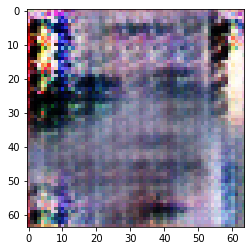

In [12]:
error_d_m3, error_g_m3, prediccion_falsa_m3 = entrenar(gan3, 3000, 150, "resultadosGAN-6/modelo3")

gan3.save("resultadosGAN-6/modelo3/GAN.h5")
gan3.layers[0].save("resultadosGAN-6/modelo3/GEN.h5")
gan3.layers[1].save("resultadosGAN-6/modelo3/DIS.h5")

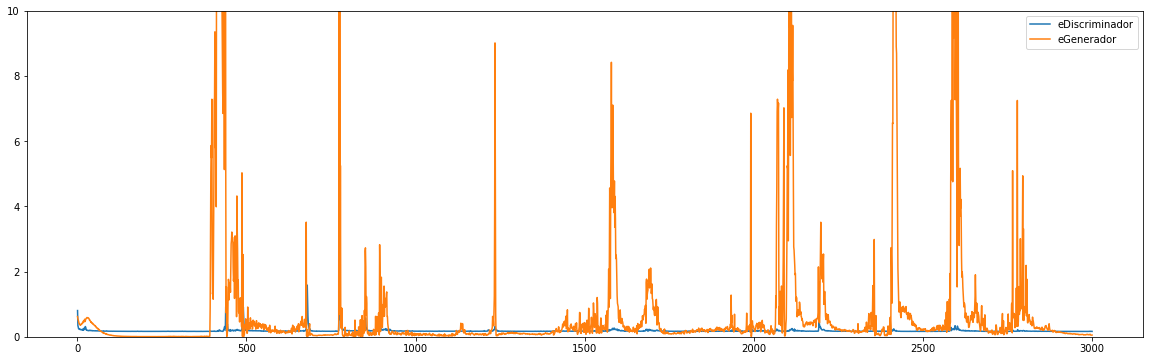

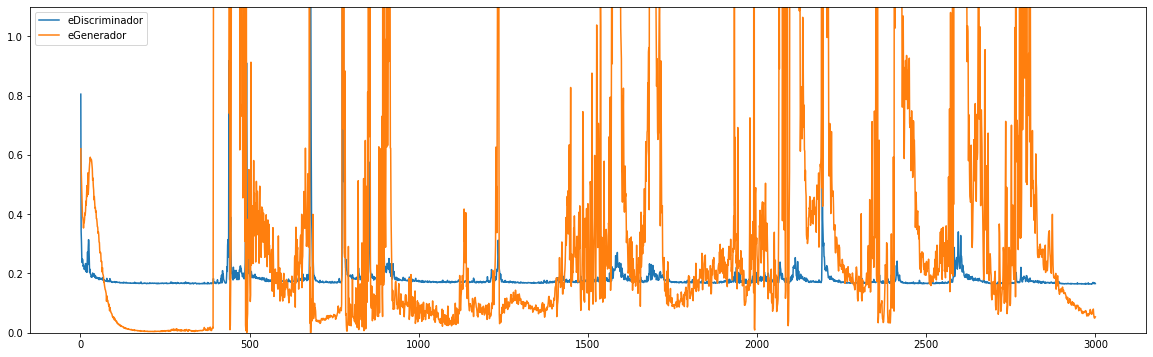

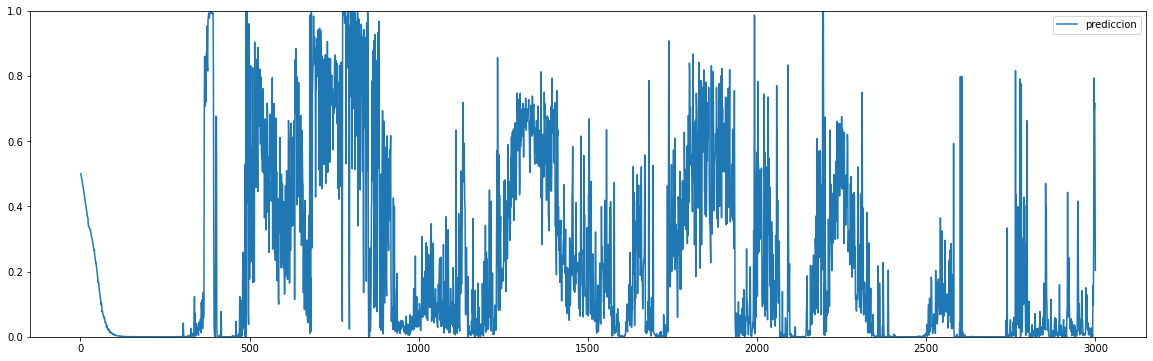

In [14]:
plot_acumulado(len(error_d_m3), 10, eDiscriminador = error_d_m3, eGenerador = error_g_m3)
plot_acumulado(len(error_d_m3), 1.1, eDiscriminador = error_d_m3, eGenerador = error_g_m3)
plot_acumulado(len(prediccion_falsa_m3), 1, prediccion = prediccion_falsa_m3)

Llego a hacer cosas interesantes:

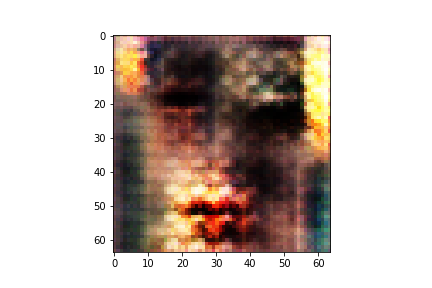

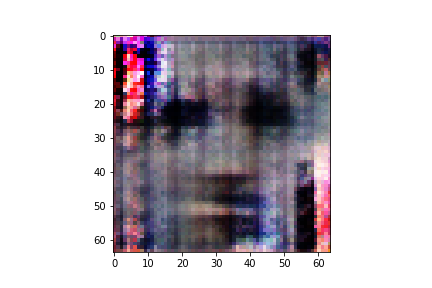

Puede que con mas epocas de entrenamiento llegara hacer cosas mas convincentes, por cuestiones de timepo no se pudo mas